# Identifying Processes Leading to Metastases

## Nevo Raz & Ofir Katz
April 2020

In [1]:
#basic data analysis packages
import numpy as np
import pandas as pd

#basic data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

**Loading Data** From http://acgt.cs.tau.ac.il/multi_omic_benchmark/download.html (SKCM, clinical data) and gtex data

Description: 
- exp: gene expression data
- mirna: micro RNA (miRNA) data
- survival: specifying whether the patient sampled died or not
- clinical data -> melanoma: additional clinical information about the patient
- gtex: healthy people skin data (shared by Nimrod via gmail)

In [2]:
# load data
# description: 

"""
creating dict containing 
- filename (of data provided for the project)
- values: [fist column name, dataset name, separator]
"""

data = {'exp':['gene', 'gene_data', ' '], 
        'mirna': ['micro_rna', 'micro_rna_data', ' '],
        'gtex_data': ['ensemble_id', 'gtex_data', '\t']}

dataframes = {}

"""
load_dataframe will add relevant data to dataframes
"""

def load_dataframe(filename, values):
    title_row = pd.read_csv('{}.csv'.format(filename), header=None, nrows=1) #read table column names as row
    names = title_row.iloc[0, 0].replace('"', '').split(values[2]) #create colum title list
    if filename == 'gtex_data':
        names[0] = values[0]
    else:
        names = [values[0]] + names
    dataframes[values[1]] = pd.read_csv('{}.csv'.format(filename), names=names, skiprows=1, sep=values[2]) #read data    

for x in data.keys():
    load_dataframe(x, data[x])

In [3]:
# data exploration: delete irrelevant genes from data

# removing rows from 'exp' where genes begin in "X.." (following discussion with Nimrod, they are irrelevant)
dataframes['gene_data'] = dataframes['gene_data'][~dataframes['gene_data'].gene.str.contains("X..")] 

In [4]:
# data exploration: delete irrelevant samples from data

#sample types should be '01' or '06', but data exploration showed us that some other samples exist
def delete_irrelevant_samples(dataframe, title):
    sample_types = [x[-2:] for x in dataframe.columns[1:]]
    columns_to_remove = []
    for x in range(len(sample_types)):
        if sample_types[x] not in ['01', '06']:
            columns_to_remove.append(dataframe.columns[x + 1])
    print("removing following columns from {}:".format(title), columns_to_remove)
    dataframe = dataframe.drop(columns=columns_to_remove)
    return dataframe

dataframes['gene_data'] = delete_irrelevant_samples(dataframes['gene_data'], "gene expression data")
dataframes['micro_rna_data'] = delete_irrelevant_samples(dataframes['micro_rna_data'], "micro RNA data")

removing following columns from gene expression data: ['TCGA.D3.A1QA.07', 'TCGA.GN.A4U8.11']
removing following columns from micro RNA data: ['TCGA.D3.A1QA.07', 'TCGA.FW.A3R5.11', 'TCGA.GN.A4U8.11']


In [5]:
# create a copy of dataframes before normalization, to be later used for differential gene expression alaysis
not_normalized_dataframes = dataframes.copy()

In [6]:
# load survival data

"""
survival data needs to be loaded in a different way (based on data observation)
we will load it and add it to our dataframes dictionary (for consistency)

the column named "Death" has been renamed as "isDead" for clarity
"""
survival = pd.read_csv('survival.csv', names=['PatientID', 'Survival', 'isDead'], skiprows=1, sep='\t')

dataframes['survival_data'] = survival

In [7]:
# load clinical data data (clinical data -> melanoma)

"""
loading with python or excel: problem with rwos 38, 39!!

the data has a problem in line 38, 39:
they are series with 3 elements (total values: 105, unlike total 103 in other rows)
we discluded this data

we tried to load this data with RStudio but it didnt work
"""

clinical_titles = pd.read_csv('melanoma.txt', header=None, nrows=1) 
clinical_data_titles = clinical_titles.iloc[0, 0].split('\t')

clinical_data = pd.read_csv('melanoma.txt', header=None, names=clinical_data_titles, skiprows=[0, 38,39], sep='\t') 

dataframes['clinical_data'] = clinical_data

# Normalize Data

**Normalize Gene Expression and Micro RNA Data**

Steps: 
1. perform log2(val + 1)
3. remove features with low variance (we chose to remove values with variance below the 45th percentile, but this as a parameter that can be changed)
4. subtract mean and divide by std

**Normalize GTEX data**

Steps: 
1. check if data is normalized or partially normalized (--> we discovered the mean was already 0, the std was not 1)
2. normalize if necessary based on missing steps (--> the step left was only divide by std)

**<u>Gene Expression and Micro RNA Normalization</u>**

In [8]:
def perform_log(dataframe, column_name):
    # perform log2 (val+1)
    dataframe = dataframe.apply(lambda x: np.log2(x + 1) if x.name != column_name else x)
    return dataframe

def plot_relationship_between_mean_and_std(dataframe, title):
    mean_vals = dataframe.mean(axis=1) #these are the expected values 
    std_vals = dataframe.std(axis=1) #this is the variance
    plt.figure(figsize=(7, 7)) # set figure size
    plt.title("plotting relationship between mean (after log) and std: {}".format(title)) # set title
    plt.xlabel('mean (log)') # label x axis
    plt.ylabel('standard deviation') # label y axis
    plt.scatter(mean_vals, std_vals)
    plt.show()
    
    
def remove_low_variance_features(dataframe, percentile_to_remove):
    # find variance per row
    dataframe['std'] = dataframe.std(axis=1)
    # find relevant quantile for variance column
    quantile_value = dataframe['std'].quantile(percentile_to_remove)
    # retain only rows with variance greater than selected quantile
    dataframe = dataframe[dataframe['std'] > quantile_value]
    # drop current varinace column in order to not interfere in future calcuations on full rows
    dataframe = dataframe.drop(['std'], axis=1)
    return dataframe

def subtract_mean_divide_std(dataframe):
    # find mean per row
    mean_vals = dataframe.mean(axis=1) #these are the expected values
    # find std per row
    std_vals = dataframe.std(axis=1) #this is the variance
    # subtract means and divide by std
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].subtract(mean_vals, axis=0).divide(std_vals, axis=0)
    return dataframe    

"""
normalize data gets 
- a dataframe
- the name of the first column of the dataframe
- the percentile of variance values below which to remove features (to remove features with low variance)
- the tilte to add to the graph of mean (log) vs std
"""
def normalize_data(dataframe, column_name, percentile_to_remove):
    dataframe = perform_log(dataframe, column_name)
    dataframe = remove_low_variance_features(dataframe, percentile_to_remove)
    dataframe = subtract_mean_divide_std(dataframe)
    return dataframe

def log_and_plot(dataframe, column_name, title):
    x = perform_log(dataframe, column_name)
    plot_relationship_between_mean_and_std(x, title)
    

# check if datasets are normalized
def check_if_normalized(dataframe, data_description):
    print("checking {}:".format(data_description))
    max_mean = round(dataframe.mean(axis = 1), 1).max()
    min_mean = round(dataframe.mean(axis = 1), 1).min()
    max_std = round(dataframe.std(axis = 1), 1).max()
    min_std = round(dataframe.std(axis = 1), 1).min()
    # max/min mean values
    print("\nmean:")
    print("max value: ", max_mean)
    print("min value: ", min_mean)
    # max/min std values
    print("\nstd:")
    print("max value: ", max_std)
    print("min value: ", min_std)
    if max_mean == 0 and min_mean == 0:
        print("\nmean result is correct")
    else:
        print("\nmean result is not correct")
    if max_std == 1 and min_std == 1:
        print("\nstd result is correct")
    else:
        print("\nstd result is not correct")
        


In [9]:
dataframes['gene_data'] = normalize_data(dataframes['gene_data'], 'gene', 0.45)
dataframes['micro_rna_data'] = normalize_data(dataframes['micro_rna_data'], 'micro_rna', 0.45)

In [10]:
check_if_normalized(dataframes['gene_data'], "gene expression data")

checking gene expression data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.0
min value:  1.0

mean result is correct

std result is correct


**<u>GTEX Normalization</u>**

In [11]:
# check if gtex is normalized

check_if_normalized(dataframes['gtex_data'], "gtex data")

checking gtex data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.4
min value:  0.0

mean result is correct

std result is not correct


In [12]:
# these results mean that we have to partially normalize gtex_data: we'll divide each row by its std

def normalize_gtex(dataframe):
    std_vals = dataframe.std(axis=1)
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].divide(std_vals, axis=0)
    return dataframe    

dataframes['gtex_data'] = normalize_gtex(dataframes['gtex_data'])

In [13]:
# check if gtex is normalized now
check_if_normalized(dataframes['gtex_data'], "gtex data")

checking gtex data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.0
min value:  1.0

mean result is correct

std result is correct


# Main Methods Used In This Project

**CLUSTERING**

**What is clustering?**
Clustering is a technique to group similar data points in a way that places more similar points in the same group.
A cluster is a group of similar points. In the following project we will use the <u>Hierarchical Clustering</u> method.

**Hierarchical Clustering**

There are 2 types of hierarchical clustering, agglomerative and divisive.
- <u>agglomerative</u>: data points are clustered using a bottom-up approach starting with individual data points
- <u>divisive</u>: data points are clustered using top-down approach 

In this project, we will use the agglomerative technique: the clustering works as follows:
1. Each data point will be considered a separate cluster (we will have k clusters for k data points)
2. The two closest data points will be joined, creating k-1 clusters
3. Keep iteratively joining the two closest clusters until we get one cluster

The clustering results can be visualized using a **dendrogram**

**Hierarchical Clustering Methods:**

we will describe 3 methods, that according to our research are the most commonly used methods in studies, though more methods exist:

1. <u>complete/max/farthest neighbor</u>: the distance between two clusters is defined as the longest distance between two points in each cluster.
2. <u>average</u>: the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.
3. <u>ward/minimal increase of sum-of-squares</u>: uses ward's method: similar to average, but using the sum of the square of the distances. Proximity between two clusters is the magnitude by which the summed square in their joint cluster will be greater than the combined summed square in these two clusters.

<u>How can we select a method to use?</u>
- One possibility is to use the to calculate the cophenet, because the correlation between the distance matrix and the cophenetic distance can help suggest clustering method to choose. We want to select the method where the correlation between the original distances and the cophenetic distances is high.

<u>Which packages will we use for the analysis?</u>
- we used scipy for selecting a clustering method, performing hierarchical clustering and displaying a dendrogram

**PCA**

**What is PCA?** 
- Principal Component Analysis (PCA) is a statistical procedure used to convert a set of observations with multiple dimensions (features, variables) that might be correlated into a group of linearly uncorrelated variables (principal components) using orthogonal transformation.
- The variables are transformed into a new set of variables, known as principal components (PCs) that ar orthogonal and ordered in a way where the variation present in the PCs decrease as we move from the 1st PC to the last one
- PCA is an unsupervised method and it’s difficult to interpret the features used to create the main resulting PCs as they are some complex mixture of the original features.

Without getting into math, PCA works as follows:
1. Normalize the data
2. Calculate a matrix that summarizes how our variables are related (the covariance matrix)
2. Break the matrix down into separate components of direction and magnitude
3. Transform the original data to align with the important directions we found


<u>How can we select the number of principal components to use in our calculation?</u>
- When we graph, we can use only 2 PCs for a 2D graph and 3 PCs for a 3D graph
- However, we need to select a relevant number of components to be used in our calculation
- Various methods exist to select, we will plot the cumulative explained variance per component and select a number of components before where the graph slope becomes relatively steady


<u>Which packages will we use for the analysis?</u>
- we used sklearn for performing PCA

**DIFFERENTIAL EXPRESSION ANALYSIS**

**What is Differential Expression Analysis?**:
- Differential gene expression analysis is a group of statistical tests used to determine if per gene there is a significant variation across a set of tested conditions. 
- These tests can be used to compare between expression in two groups of samples, for example: a comparison between expression in primary (01) samples vs metastases samples (06) or a comparison between healthy skin samples (gtex) vs tumor samples (tcga gene expression)
- We will use differential expression analysis for analyzing gene expression and micro RNA expression
    
We selected to use 2 different methods for DE Analysis:
- **Welch's t-tests**: a two-sample location test which is used to test the hypothesis that two populations have equal means.
- **Rank Sum tests**: a test based on ranking observations of the combined samples so that each observation gets a rank (1 for the smallest, 2 for then next, and so on), and the rank-sum test statistic is the sum of the ranks for observations from one of the sample types.


**How do we define a highly-expressed/slightly-expressed gene?**
- To determine if a gene has been significantly expressed, we will use genes/miRNAs where:
    - **P-value: is less than 0.01** (this was an arbitrary selection because we got *a lot* of results for 0.05)
    - **log2FoldChange:** we read that fold-change of **+/- 2** is often used as the threshold for defining significant differential expression, therefore we will use a minimum of log fold-change +2 to define highly-expressed genes and a maximum of -2 to define slightly expressed genes. However, we will select actual values to use by examining an MA-Plot and seeing outlying values graphically. (specifically, we noticed that with our data, the limits of -7.5/+7.5 were actually better in many cases)
- When we say a gene/miRNA is highly/slightly expressed, we mean that we got it as a result from t-test, rank sum tests, or both. After we perform each test, we combine the results in order to get a more robust result.

<u>Which packages will we use for the analysis?</u>
- differential expression analysis using diffxpy (installation instructions: https://github.com/theislab/diffxpy/blob/master/docs/installation.rst)

# Data Analysis

Research Questions and Analysis Methodology:

<u>Question # 1</u>

**Question: If we look at gene expression data of primary tumors and metastases together, is there a clear distinction between them? Does such a distinction exist for micro RNA?**

***Analysis Description:*** <br />
<u>General Description:</u> In order to find a distinction between primary tumors and metastases, we will attempt to cluster our data by sample to create clusters of primary samples ('01') and clusters of metastases samples ('06'), using hierarchical clustering. We will then perform PCA and graph the results of clustering on the main PCs, so that we can visually compare plots of actual primary/metastases samples to plots as a result of cluestering. If we find similar results, we will have found a clear distinction between primary and metastases samples. <br />

The following process was be performed once with normalized gene expression data and once with normalized miRNA expression data.<br />
- A method for hierarchical clustering was selected by comparing the cophenet of 3 possible methods: 'ward', 'complete', 'average'
- Clustering was performed by sample (01, 06 samples) using 2 separate methods
- Results of clustering were displayed using a dendrogram (a useful tool to display biological clustering)
- Results of clustering were analyzed as follows:
    - Clustering results were examined for k # of clusters = [2, 4, 10, 15, 25, / 35, 45] (additionals for miRNA)
    - Per k, each cluster was examined:
        - We checked if the cluster has resulted in a higher percent of actual 01 samples / actual 06 samples
        - Based on the analysis, we defined each cluster as 'primary', 'metastases' or 'unknown'
- We selectd one of the clustering methods for a specific k for further analysis 
    - for gene expression: k = 25, method = 'complete'
    - for miRNA: k = 45, method = 'ward'
- We displayed the data matrix graphically as a scatter plot in 2D (this shouldn't make much sense because data is multi-dimensional, but gives a good understanding of data point types and the quality of clustering)
    1. one graph is displayed by actual 01/06 sample
    2. one graph is displayed by cluster
    3. one graph is displayed by 01/06 sample **based on clustering results**
- We performed PCA to find new axis (PC1, PC2, PC3) to display our data on
    - we normalized the data so that all data points are between 0 and 1
    - we performed analysis of a how many components to use for the PCA
    - we performed PCA for number of components selected
        - for gene expression: n_components = 300
        - for miRNA: n_components = 250
    - we calculated the explained variance % per PC and specifically examined the % for PCs 1, 2 and 3
    - we graphed the data in 2D (PC1 as x, PC2 as y) and in 3D ((PC1 as x, PC2 as y, PC3 as z)
        1. one graph section displayed the data points colored by actual sample type (primary, metastases) based on sample name 
        2. one graph section displayed the data points colored by cluster
        3. one graph section displayed the data points colored by cluster sample type (primary, metastases, unknown) **based on clustering results**
   
   
***Conclusion:*** <br />
The clustering process proved difficult as there were few primary samples compared to metastases samples. However,
- For gene expression data, our clustering into k=15 clusters gave relatively good results, and clustering into k=25 clusters gave even better results. Graphing on main PCs shows us that some areas of actual 01 samples are well recognized by our clustering, specifically the top right area of the 3D PCA graph. In our opinion, the distinction between primary and metastases samples was pretty good considering the small number of 01 samples.
- For micro rna expression data, our clustering into small ks resulted in very few distinctly primary clusters. In order to create relatively good graphical results, we had to use large ks, such as k=45. While the results for this k looked better, there is a high risk of overfitting in this case, so in our opinion the distinction between primary and metastases samples was not very good. 

In [14]:
# imports for hierarchial clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

# imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# imports for plotting
import plotly.graph_objs as go
import plotly.offline as offline
from mpl_toolkits.mplot3d import Axes3D  

Question 1: Gene Expression Analysis

In [15]:
#transpose data to get a matrix of samples for rows, dimensions (genes) for columns

def transform_data(dataframe):
    a = dataframe.T
    a.columns = a.iloc[0]
    a = a.iloc[1:, :]
    X = a.to_numpy() # convert a to numpy array (no row, column names) because algos we will use need this
    return a, X
    
a, X = transform_data(dataframes['gene_data'])

a.head()

gene               A1BG.1 A2BP1.54715 A2LD1.87769 A2ML1.144568     A2M.2  \
TCGA.3N.A9WB.06  0.703106   -0.413022     1.75643     0.219317  -2.15274   
TCGA.3N.A9WC.06 -0.271476   -0.413022     1.03666    -0.712711   1.85089   
TCGA.3N.A9WD.06  0.623738     2.57316    0.220533    -0.712711 -0.204097   
TCGA.BF.A1PU.01 -0.418624    0.830254     1.06153     0.246341  -1.12695   
TCGA.BF.A1PV.01 -0.118319   -0.413022   -0.534805    -0.505992  -2.37279   

gene            A4GALT.53947 AACSL.729522 AADACL2.344752 AADACL3.126767  \
TCGA.3N.A9WB.06      -1.0512    -0.634155       0.939575       -0.16196   
TCGA.3N.A9WC.06     0.140153    -0.415142      -0.344445       -0.16196   
TCGA.3N.A9WD.06     0.816695   -0.0611561      -0.344445       -0.16196   
TCGA.BF.A1PU.01     0.450017    -0.634155       0.260928       -0.16196   
TCGA.BF.A1PV.01    -0.964558    -0.634155      -0.344445       -0.16196   

gene            AADAC.13  ... ZSCAN18.65982 ZSCAN1.284312 ZSCAN23.222696  \
TCGA.3N.A9WB.06 -0.53831  ...     -0.690519     -0.697552       -1.12202   
TCGA.3N.A9WC.06 -0.53831  ...       1.47795     0.0771556      -0.366684   
TCGA.3N.A9WD.06 -0.53831  ...       1.32464      0.463101      -0.571297   
TCGA.BF.A1PU.01 -0.53831  ...       1.16722     -0.327994       0.474251   
TCGA.BF.A1PV.01 -0.53831  ...       1.14218     -0.353843       -1.17547   

gene            ZSCAN4.201516 ZSCAN5A.79149 ZSCAN5B.342933 ZSWIM5.57643  \
TCGA.3N.A9WB.06      -0.64468      -1.51789       -1.15626    0.0902101   
TCGA.3N.A9WC.06      -0.64468      0.113756      -0.628801    -0.580616   
TCGA.3N.A9WD.06     0.0615025      0.738158       0.223716      1.56847   
TCGA.BF.A1PU.01      -0.64468     -0.661544       -1.15626     0.201055   
TCGA.BF.A1PV.01      -0.64468     0.0867665      -0.747601     -1.92418   

gene            ZUFSP.221302 ZYG11A.440590 psiTPTE22.387590  
TCGA.3N.A9WB.06    -0.141193        0.9863        -0.876562  
TCGA.3N.A9WC.06    0.0554014     -0.435242        -0.520554  
TCGA.3N.A9WD.06     0.104382       1.63676          2.47852  
TCGA.BF.A1PU.01    0.0906005     -0.985369        -0.929176  
TCGA.BF.A1PV.01    -0.216158     -0.985369         -1.14425  

[5 rows x 10650 columns]

In [16]:
# defining sample labels with only "06", "01" for clarity     
samples_label_list = [x[-2:] for x in list(a.index)]

In [17]:
# selecting clustering methods for use

def select_clustering_method(data_matrix, method_list):
    print("method; cophenet;")
    for method in method_list:
        l = linkage(data_matrix, method=method)
        c, coph_dists = cophenet(l, pdist(data_matrix))
        print(method, c)

select_clustering_method(X, ['complete', 'average', 'ward'])
    
# select optimal linkage method: chopenet should be closest to 1   
# methods selected: 'complete' and 'average'

method; cophenet;
complete 0.5378570666061107
average 0.7461720517220348
ward 0.4547375338222622


In [18]:
# cluster gene expression by samples (primary vs metastases) and plot resulting dendrogram

def cluster_by_sample_and_plot_dendrogram(data, labels, method):
    plt.figure(figsize=(25, 10)) # define figure size
    plt.title('Hierarchical Clustering Dendrogram, Method: {} - Cluster By Sample'.format(method.capitalize())) # add figure title
    plt.xlabel('samples') # label x axis
    plt.ylabel('distance') # label y axis
    samples_dist = pdist(data) # computing the distance
    samples_link = linkage(samples_dist,  metric='correlation', method=method) # computing the linkage
    dendrogram(samples_link,labels=labels)
    plt.show()
    return samples_link # return the linkage, it is needed for additional functions

# divide sample results of dendrogram into k clusters
def divide_samples_into_clusters(k, samples_link, samples_label_list):
    fl = fcluster(samples_link, k,criterion='maxclust') # list leaves by cluster      
    sample_clusters = fl.tolist() # sample_clusters will be a list of cluster numbers (1-k)
    sample_cluster_dict = {} # based on cluster results, create dict mapping to a list of samples in each cluster
    for num in range(1, k+1):
        sample_cluster_dict[num] = [] # initialize k empty lists in dict
    for x in range(len(sample_clusters)):
        sample_cluster_dict[sample_clusters[x]].append(samples_label_list[x]) # add the relevent label from samples_label_list to cluster list
    return sample_cluster_dict

# for each cluster, check if it is mostly 01 or 06 and print out results
def analyze_sample_clusters(sample_cluster_dict):
    print("\nk = {}".format(len(sample_cluster_dict)))
    print("cluster\t\tcluster_type\t\tprimary_cases\tmetastases_cases\ttotal_cases")   
    for key in sample_cluster_dict.keys(): # perform per cluster
        num_01 = num_06 = 0
        for element in sample_cluster_dict[key]: # count 01, 06 elements in cluster
            if element == '01':
                num_01+= 1
            elif element == '06':
                num_06+= 1
        total = num_01 + num_06 # total number of elements in cluster
        if total > 0:
            num_01 = (num_01/total)*100 # percent of 01 in cluster
            num_06 = (num_06/total)*100 # percent of 06 in cluster
            if round(num_01, 2) > round(num_06, 2): # greater percent of 01 is primary clsuter
                cluster_type = 'primary (01)'
            elif round(num_01, 2) < round(num_06, 2): # greater percent of 06 is metastases clsuter
                cluster_type = 'metastases (06)'
            else: # if the percent is equal, this cluster type is unknown
                cluster_type = 'unclear    '
            print("{}\t\t{}\t\t{}%\t\t{}%\t\t\t{}".format(key, cluster_type, round(num_01, 2), round(num_06, 2), total))

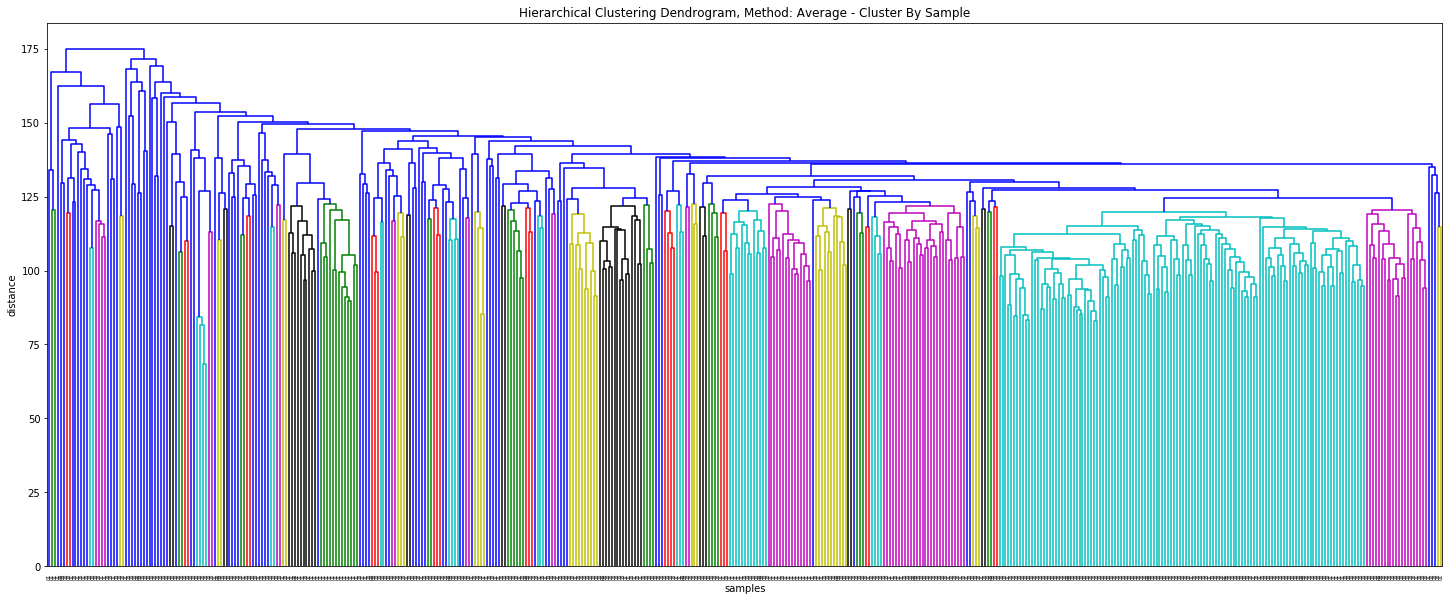


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.46%		61.54%			26
2		metastases (06)		20.9%		79.1%			445

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.46%		61.54%			26
2		metastases (06)		12.5%		87.5%			8
3		metastases (06)		21.1%		78.9%			436
4		metastases (06)		0.0%		100.0%			1

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		primary (01)		100.0%		0.0%			3
2		metastases (06)		27.27%		72.73%			22
3		primary (01)		100.0%		0.0%			1
4		metastases (06)		0.0%		100.0%			3
5		metastases (06)		0.0%		100.0%			2
6		metastases (06)		0.0%		100.0%			2
7		primary (01)		100.0%		0.0%			1
8		metastases (06)		0.0%		100.0%			3
9		metastases (06)		21.25%		78.75%			433
10		metastases (06)		0.0%		100.0%			1

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		primary (01)		100.0%		0.0%			3
2		metastases (06)		31.58%		68.42%			19
3		metastases (06)		0.0%		100.0

In [19]:
### Clustering with 'average' method ###

# cluster and plot dendrogram with 'average' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'average')

# choose best k for 'average' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

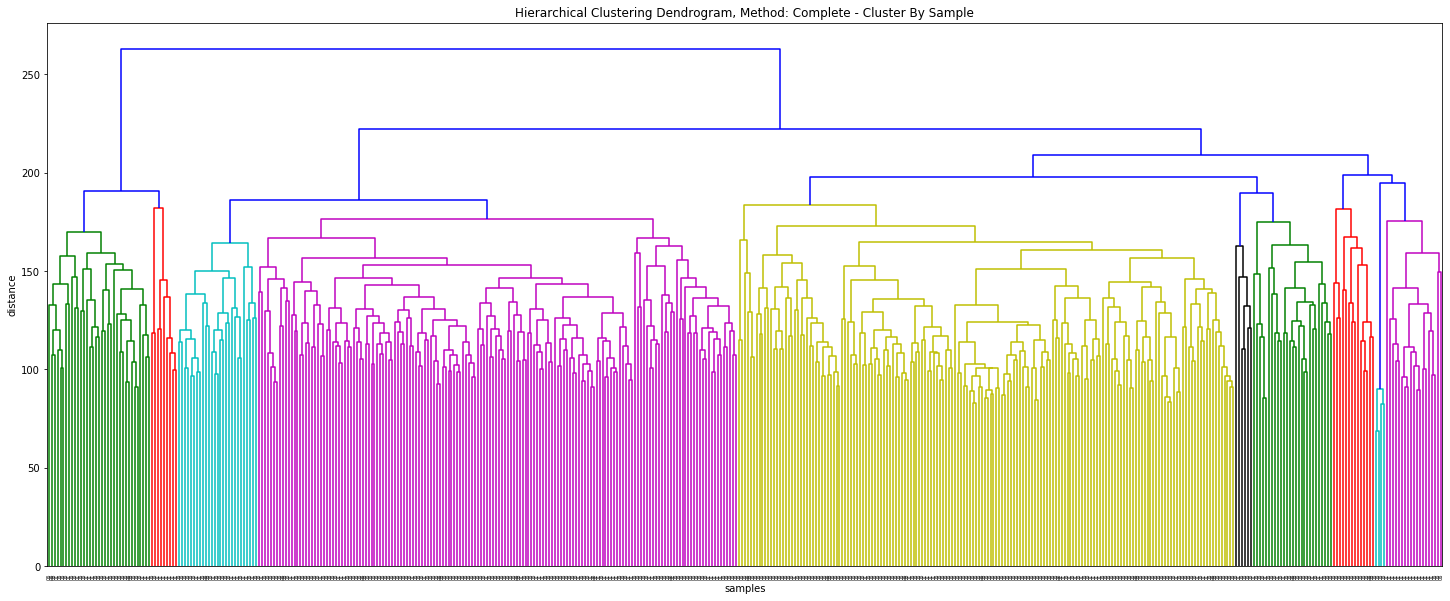


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.64%		61.36%			44
2		metastases (06)		20.14%		79.86%			427

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.64%		61.36%			44
2		metastases (06)		22.22%		77.78%			189
3		metastases (06)		13.93%		86.07%			201
4		metastases (06)		43.24%		56.76%			37

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		28.57%		71.43%			35
2		primary (01)		77.78%		22.22%			9
3		metastases (06)		33.33%		66.67%			27
4		metastases (06)		20.37%		79.63%			162
5		metastases (06)		11.9%		88.1%			168
6		metastases (06)		16.67%		83.33%			6
7		metastases (06)		25.93%		74.07%			27
8		metastases (06)		0.0%		100.0%			14
9		metastases (06)		0.0%		100.0%			4
10		primary (01)		84.21%		15.79%			19

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		28.57%		71.43%			35
2		metastases (06)		0.0%		100.0%			

In [20]:
### Clustering with 'complete' method ###

# cluster and plot dendrogram with 'complete' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'complete')

# choose best k for 'complete' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

In [21]:
# select clustering method

# set chosen k based on previous analysis and chosen method
k = 25

# define clusters
clusters = fcluster(samples_link, k, criterion='maxclust')

In [22]:
# scatter plot of clusters

# this function takes a data matrix and plots its points
# results shouldn't make much sense because we have many dimensions!
def scatter_plot_samples(data, color_values, title):
    plt.figure(figsize=(25, 7)) # set figure size
    plt.title(title) # set title
    plt.xlabel('genes expression value') # label x axis
    plt.ylabel('samples') # label y axis
    plt.scatter(data[:,0], data[:,1], c=color_values, cmap='prism')
    plt.show()

In [23]:
def define_cluster_types(dataset, k, samples_link, clusters):
    samples_full_label_list = list(dataset.index)
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_full_label_list)    
    cluster_types = []
    for key in sample_cluster_dict.keys():
        num_01 = num_06 = 0
        for element in sample_cluster_dict[key]:
            if element[-2:] == '01':
                num_01+= 1
            elif element[-2:] == '06':
                num_06+= 1
        total = num_01 + num_06
        if total > 0:
            num_01 = (num_01/total)*100
            num_06 = (num_06/total)*100
            if round(num_01, 2) > round(num_06, 2):
                cluster_types.append((key, 'primary'))
            elif round(num_01, 2) < round(num_06, 2):
                cluster_types.append((key, 'metastases'))
            else: 
                cluster_types.append((key, 'unknown'))
    primary_metastases_cluster_list = []
    for cluster in clusters:
        if cluster_types[cluster-1][1] == 'primary':
            primary_metastases_cluster_list.append(1)
        elif cluster_types[cluster-1][1] == 'metastases':
            primary_metastases_cluster_list.append(6)
        else:
            primary_metastases_cluster_list.append(0)
    return cluster_types, primary_metastases_cluster_list

cluster_types, primary_metastases_cluster_list = define_cluster_types(a, k, samples_link, clusters)
primary_metastases_clusters = np.asarray(primary_metastases_cluster_list, dtype=np.int32)

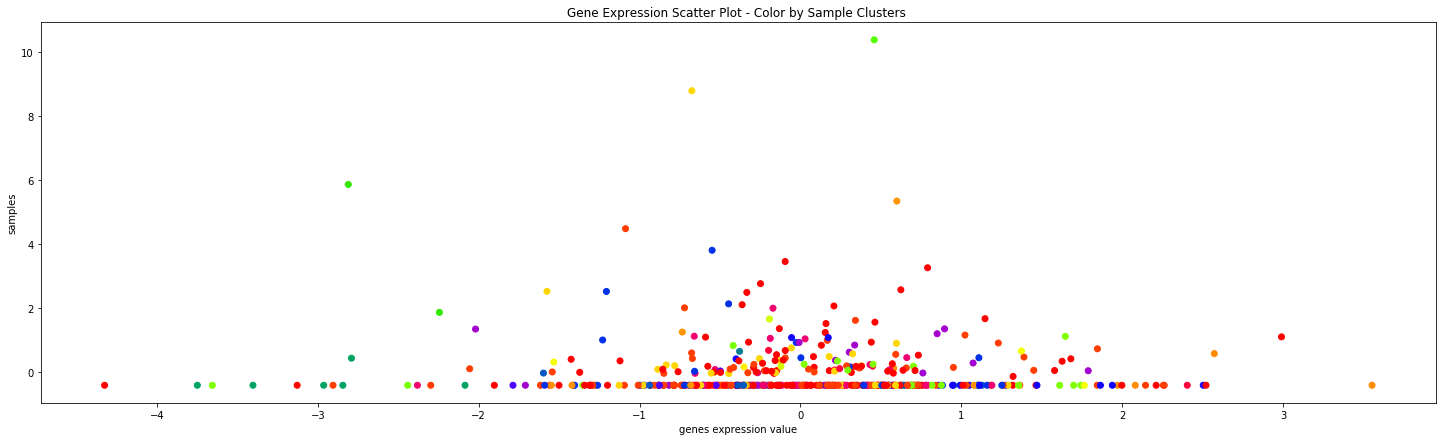

In [24]:
# 1. plot points with color by cluster
scatter_plot_samples(X, clusters, 'Gene Expression Scatter Plot - Color by Sample Clusters ')

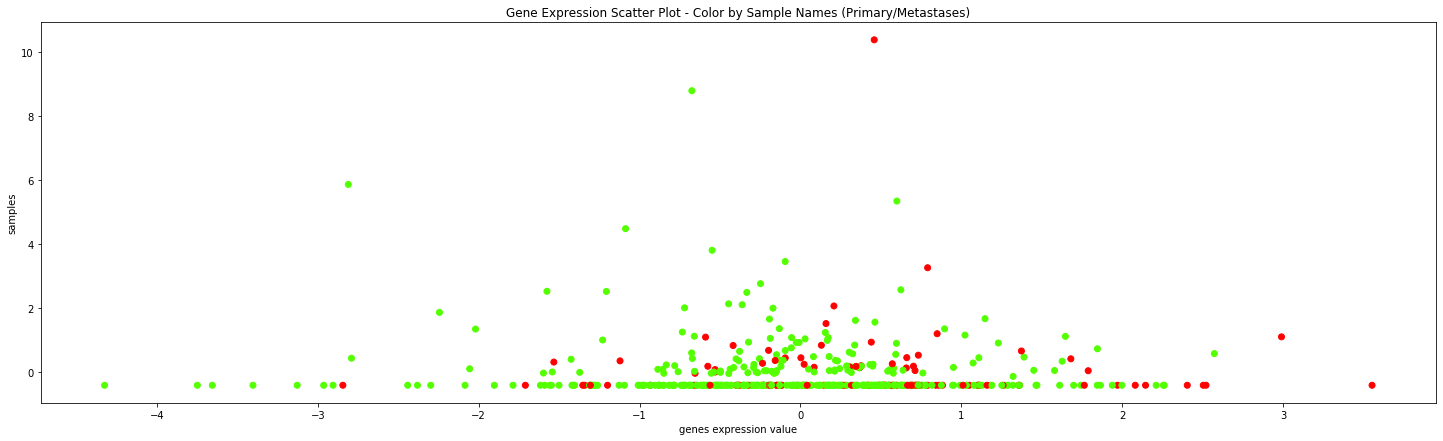

In [25]:
# 2. plot points with color by sample name (01 or 06) (actual tumor type: primary or metastases)

color_values = np.asarray(samples_label_list, dtype=np.int32)
scatter_plot_samples(X, color_values, 'Gene Expression Scatter Plot - Color by Sample Names (Primary/Metastases)')


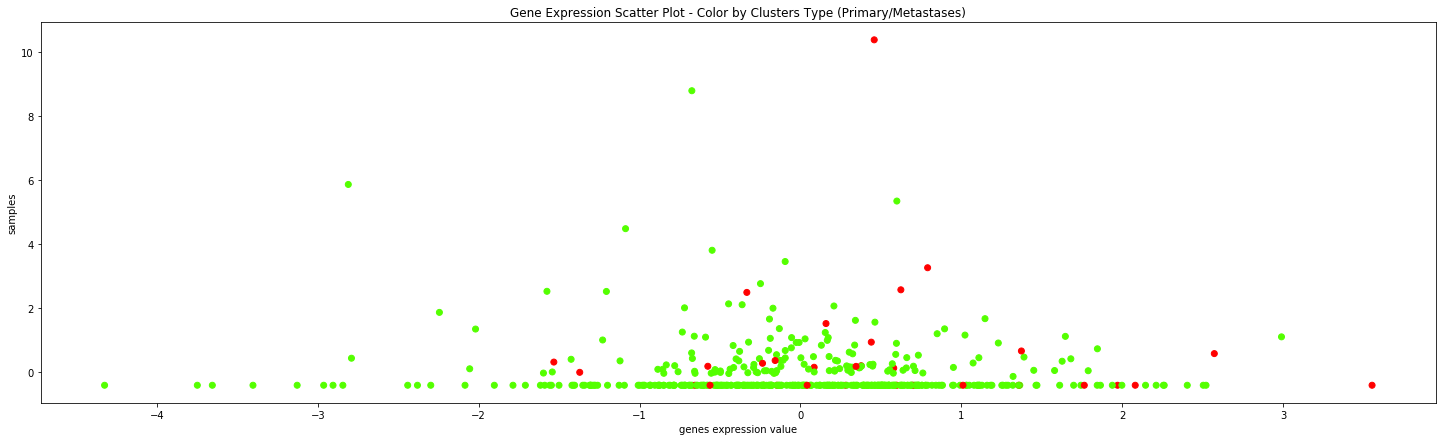

In [26]:
# 3. plot points with color by cluster tumor type (tumor typea as a result of clustering)
scatter_plot_samples(X, primary_metastases_clusters, 'Gene Expression Scatter Plot - Color by Clusters Type (Primary/Metastases)')

In [27]:
# Perform PCA in order to display data points on PCs

In [28]:
# normalize data to values between 0 and 1

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)

print("data has been rescaled")
print("after rescaling: min={}, max={}".format(round(data_rescaled.min(), 2), round(data_rescaled.max(), 2)))

data has been rescaled
after rescaling: min=0.0, max=1.0


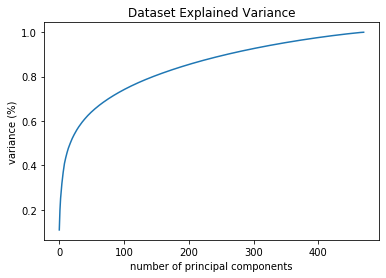

based on graph: selecting 300 principal components that appear to account for 90% of the variance


In [29]:
# Select number of principal components to use for PCA

# the function plots the explained variance for each attribute
def plot_explained_variance(data):
    pca = PCA().fit(data_rescaled) # fitting PCA with our data
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of principal components')
    plt.ylabel('variance (%)') #for each component
    plt.title('Dataset Explained Variance')
    plt.show()
    
plot_explained_variance(data_rescaled)

# based on this graph we need to decide how many principal components to use
# we will not select the maximum possible, in order to preserve only principal components
# however, we want to select a number of components where the graph slope is not very big

# we will decide to use 300 principal components

print("based on graph: selecting 300 principal components that appear to account for 90% of the variance")

In [30]:
# functions for PCA and understanding explained varinace of PCs

def plot_explained_variance_and_cumsum(components, var_exp, cum_var_exp):
    # plot the explained variance
    x = ["PC%s" %i for i in range(1, components)]
    trace1 = go.Bar(x = x , y = list(var_exp), name = "explained variance")
    trace2 = go.Scatter(x = x, y = cum_var_exp, name = "cumulative variance")
    layout = go.Layout(title = 'Explained Variance', xaxis = dict(title = 'principle components', tickmode = 'linear'))
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    offline.iplot(fig)
    
def perform_pca_and_plot_explained_variance(original_data, rescaled_data, components):
    pca = PCA(n_components=components) 
    dataset = pca.fit_transform(rescaled_data)
    Y = pca.fit(original_data)
    var_exp = Y.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    plot_explained_variance_and_cumsum(components, var_exp, cum_var_exp)
    return dataset

In [31]:
# perform PCA with 300 components

components = 300

print("plotting the explained variance per principal component")
dataset = perform_pca_and_plot_explained_variance(X, data_rescaled, components)

# based on the graph, we can see that: 
# PC1 + PC2 are responsible for nearly 21% of the explained variance
# PC1 + PC2 + PC3 are responsible for nearly 26% of the explained variance
# we will use these 3 PCs to graph the points on these axis

plotting the explained variance per principal component


In [32]:
# PC1 + PC2 are responsible for 21% of the explained variance

In [33]:
def add_cluster_info_to_dataset(a, clusters, cluster_types):
    a['tumor_type'] = np.asarray(['primary' if x[-2:] == '01' else 'metastases' for x in list(a.index)])
    a['cluster'] = clusters
    a['tumor_type_by_clustering'] = np.asarray([cluster_types[x-1][1] for x in clusters])
    
add_cluster_info_to_dataset(a, clusters, cluster_types)

In [34]:
# plotting graphs with PCs as axes


def plot_2D(dataset, labels, colors, labl, title, marker=None, alpha=None):
    # Plot PCA1 and PCA2 by primary, metastases (samples)
    Xax = dataset[:,0]
    Yax = dataset[:,1]
    labels = labels
    cdict = colors
    labl = labl
    if marker and alpha:
        marker = marker
        alpha = alpha
    fig,ax=plt.subplots(figsize=(10,10))
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        if marker and alpha:
            ax.scatter(Xax[ix], Yax[ix], c = cdict[l], s = 40, label = labl[l], marker = marker[l], alpha = alpha[l])
        else:
            ax.scatter(Xax[ix], Yax[ix], s = 40, label = labl[l])
    plt.xlabel("first principal component (PC1)")
    plt.ylabel("second principal component (PC2)")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_3D(dataset, labels, colors, labl, title, marker=None, alpha=None):
    # Plot PCA1, PCA2 and PCA3 by clusters for k
    Xax = dataset[:,0]
    Yax = dataset[:,1]
    Zax = dataset[:,2]
    labels = labels
    cdict = colors
    labl = labl
    if marker and alpha:
        marker = marker
        alpha = alpha
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        if marker and alpha:
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], c = cdict[l], s = 40, label = labl[l], marker = marker[l], alpha = alpha[l])
        else:
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], s = 40, label = labl[l])
    ax.set_xlabel('first principal component (PC1)')
    ax.set_ylabel('second principal component (PC2)')
    ax.set_zlabel('third principal component (PC3)')
    plt.title(title)
    plt.show()

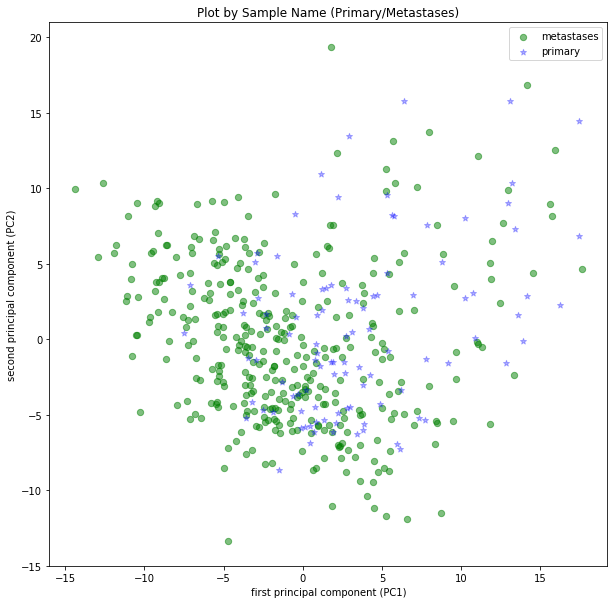

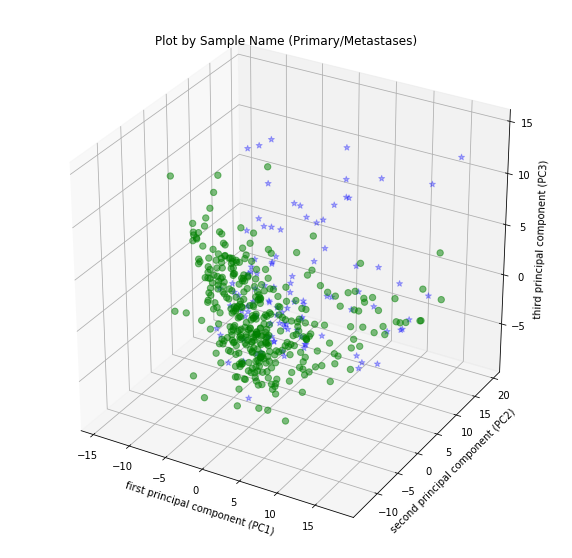

In [35]:
## 2D plot on PC1, PC2 by sample name (primary = 01, metastases = 06) ##

marker = {'primary':'*','metastases':'o'}
alpha = {'primary':.3, 'metastases':.5}

plot_2D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'}, 
        {'primary':'primary','metastases':'metastases'},
        "Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 by sample name (primary = 01, metastases = 06) ##

plot_3D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'},
        {'primary':'primary','metastases':'metastases'},
        "Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

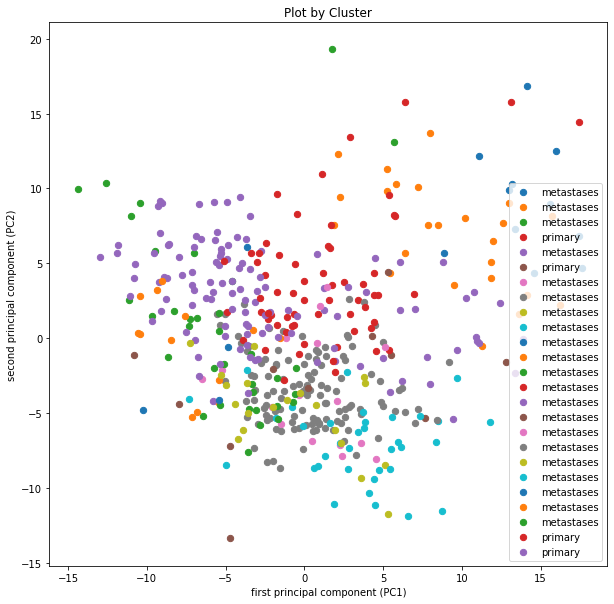

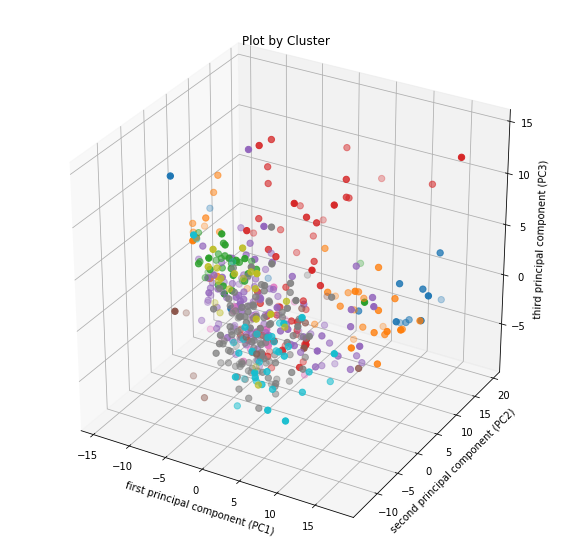

In [36]:
# specify labels
labl_dict = {}
for x in range(1, k+1):
    labl_dict[x] = cluster_types[x-1][1]


## 2D plot on PC1, PC2 by clustering results ##

plot_2D(dataset, a.cluster, a.cluster, labl_dict, "Plot by Cluster")

## 3D plot on PC1, PC2, PC3 by clustering results ##

plot_3D(dataset, a.cluster, a.cluster, labl_dict, "Plot by Cluster")


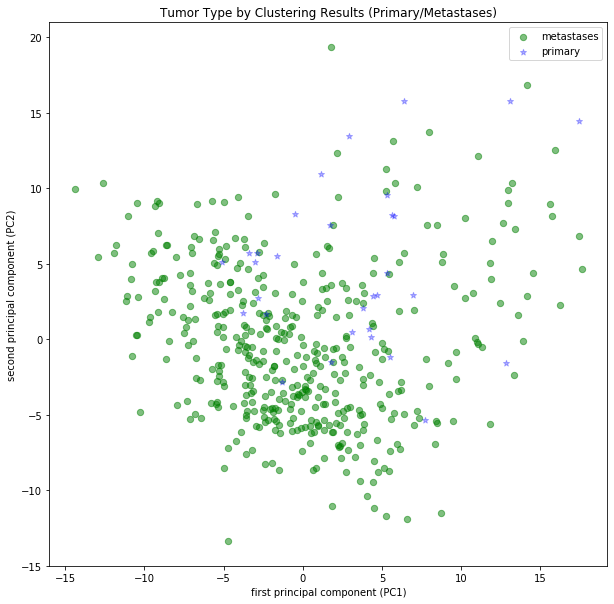

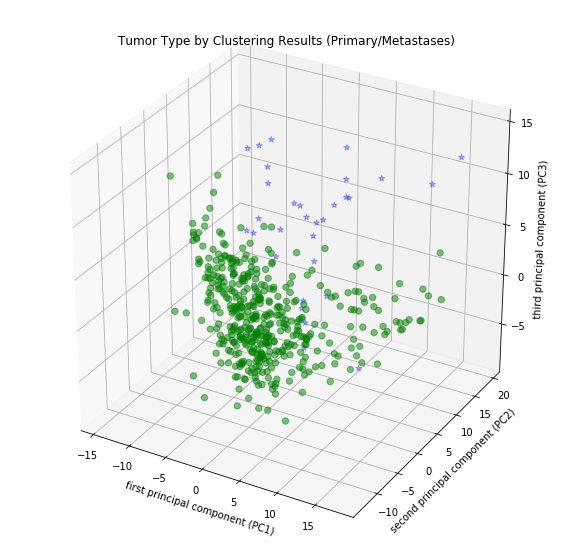

In [37]:
# specify labels

marker = {'primary':'*','metastases':'o', 'unknown':'.'}
alpha = {'primary':.3, 'metastases':.5, 'unknown':.2}

## 2D plot on PC1, PC2 tumor type by clustering results ##

plot_2D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 tumor type by clustering results ##
plot_3D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

Question 1: miRNA Analysis

In [38]:
#transpose data to get a matrix of samples for rows, dimensions (miRNA) for columns
    
a, X = transform_data(dataframes['micro_rna_data'])

a.head()

micro_rna       hsa.let.7a.1 hsa.let.7a.2 hsa.let.7a.3 hsa.let.7b hsa.let.7c  \
TCGA.3N.A9WC.06     0.236728     0.222467     0.223786  -0.223227   -1.57813   
TCGA.3N.A9WD.06      1.41113      1.40648      1.41593   0.832507    2.19501   
TCGA.BF.A1PU.01      1.26298       1.2625      1.26297    1.42773   0.267714   
TCGA.BF.A1PV.01     0.185005     0.178666     0.155951  -0.256784   0.224654   
TCGA.BF.A1PX.01    0.0938264     0.110214     0.112603    1.30777   0.885622   

micro_rna       hsa.let.7d hsa.let.7e hsa.let.7f.1 hsa.let.7f.2 hsa.let.7g  \
TCGA.3N.A9WC.06   0.933032   0.104533     0.648021     0.199685   0.630162   
TCGA.3N.A9WD.06   0.280042    1.27134     0.839795      1.11564   0.994296   
TCGA.BF.A1PU.01  -0.495464    1.39041     0.799974     0.754727  -0.132817   
TCGA.BF.A1PV.01   -1.07188    1.33215    -0.603771     0.622544  -0.500857   
TCGA.BF.A1PX.01  -0.516688  0.0165566     -0.23625    -0.565286   -1.22644   

micro_rna        ... hsa.mir.937 hsa.mir.939 hsa.mir.940 hsa.mir.942  \
TCGA.3N.A9WC.06  ...    0.173835   -0.210296   -0.697373   -0.528136   
TCGA.3N.A9WD.06  ...    -1.17238    -1.10657    -1.43735    0.317472   
TCGA.BF.A1PU.01  ...    -1.23311    0.417562    -1.08156    -1.95351   
TCGA.BF.A1PV.01  ...    0.780597    0.999319    0.365494   -0.780081   
TCGA.BF.A1PX.01  ...   -0.103274    0.064687     1.07662   -0.154665   

micro_rna       hsa.mir.944 hsa.mir.95 hsa.mir.96 hsa.mir.98 hsa.mir.99a  \
TCGA.3N.A9WC.06   0.0459025   -1.10105   -1.01621   0.788233    -1.22283   
TCGA.3N.A9WD.06     1.05893   0.852694    1.93228  -0.305046     1.95442   
TCGA.BF.A1PU.01   -0.853568  -0.758042  -0.623808  -0.299624   -0.317983   
TCGA.BF.A1PV.01  -0.0743113   -1.10932  -0.755022    1.05446 -0.00787284   
TCGA.BF.A1PX.01     2.11916   0.606579  -0.535643  -0.133948    0.281251   

micro_rna       hsa.mir.99b  
TCGA.3N.A9WC.06    0.757963  
TCGA.3N.A9WD.06    0.317916  
TCGA.BF.A1PU.01  0.00876691  
TCGA.BF.A1PV.01   -0.235655  
TCGA.BF.A1PX.01    0.842755  

[5 rows x 575 columns]

In [39]:
# defining sample labels with only "06", "01" for clarity     
samples_label_list = [x[-2:] for x in list(a.index)]

In [40]:
# selecting clustering methods for use

select_clustering_method(X, ['complete', 'average', 'ward'])
    
# select optimal linkage method: chopenet should be closest to 1   
# methods selected: 'ward' and 'average'

method; cophenet;
complete 0.39044004884051225
average 0.8314533858105708
ward 0.4930703761275736


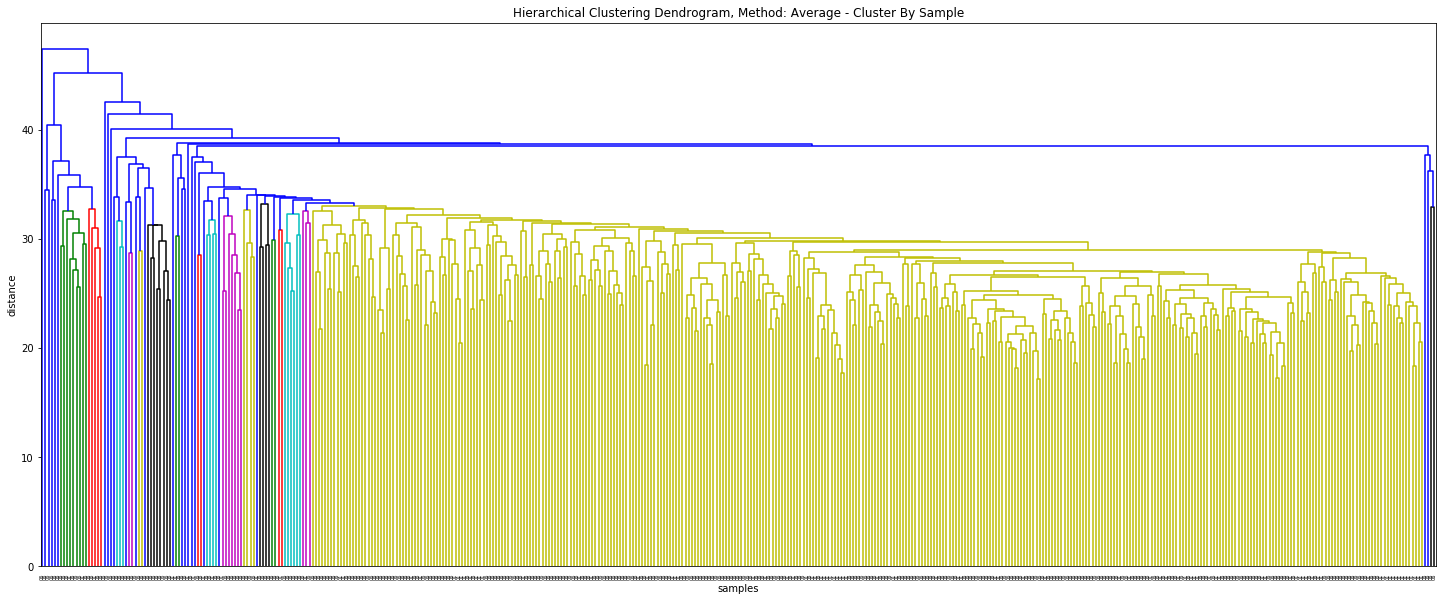


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		21.65%		78.35%			448
2		metastases (06)		0.0%		100.0%			1

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		15.79%		84.21%			19
2		metastases (06)		21.96%		78.04%			428
3		metastases (06)		0.0%		100.0%			1
4		metastases (06)		0.0%		100.0%			1

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		0.0%		100.0%			2
2		metastases (06)		17.65%		82.35%			17
3		metastases (06)		0.0%		100.0%			19
4		metastases (06)		40.0%		60.0%			5
5		metastases (06)		22.69%		77.31%			401
6		primary (01)		100.0%		0.0%			1
7		metastases (06)		0.0%		100.0%			1
8		metastases (06)		0.0%		100.0%			1
9		metastases (06)		0.0%		100.0%			1
10		metastases (06)		0.0%		100.0%			1

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		0.0%		100.0%			2
2		metastases (06)		17.65%		82.35%			17
3		metastases (06)		

In [41]:
### Clustering with 'average' method ### --> TERRIBLE!

# cluster and plot dendrogram with 'average' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'average')

# choose best k for 'average' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

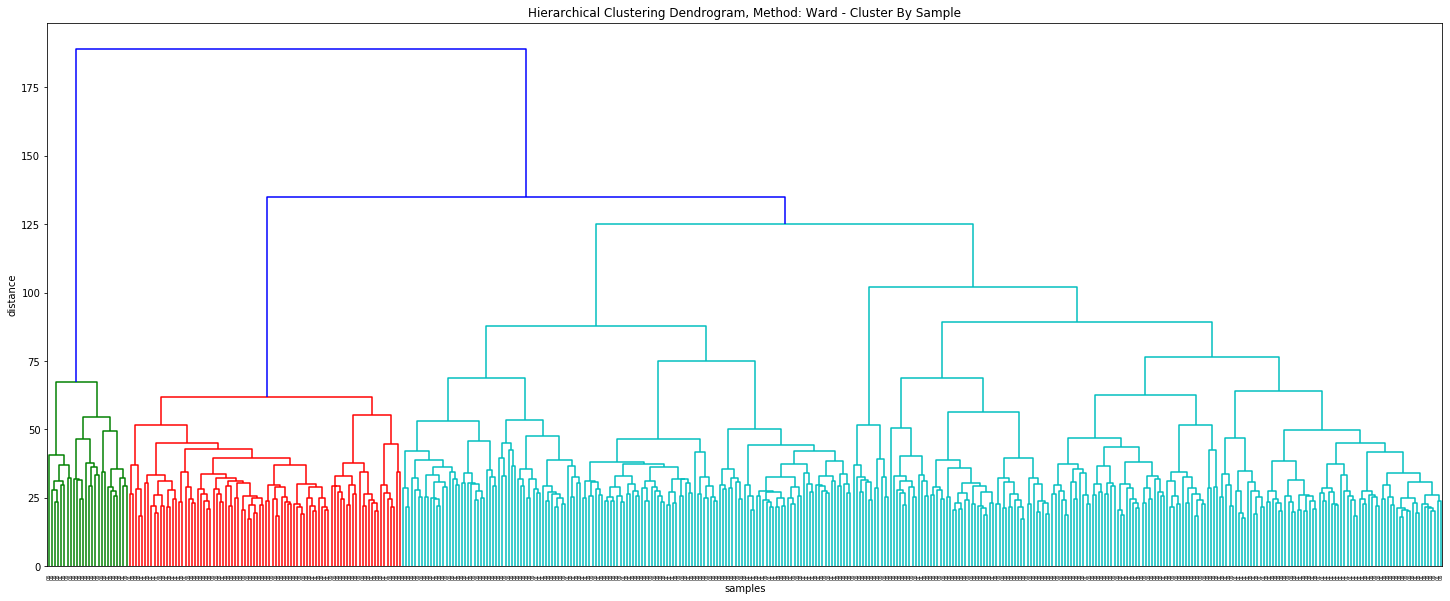


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		11.54%		88.46%			26
2		metastases (06)		22.22%		77.78%			423

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		11.54%		88.46%			26
2		metastases (06)		21.59%		78.41%			88
3		metastases (06)		22.76%		77.24%			145
4		metastases (06)		22.11%		77.89%			190

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		11.54%		88.46%			26
2		metastases (06)		21.59%		78.41%			88
3		metastases (06)		9.68%		90.32%			31
4		metastases (06)		18.52%		81.48%			27
5		metastases (06)		20.45%		79.55%			44
6		metastases (06)		37.21%		62.79%			43
7		metastases (06)		0.0%		100.0%			12
8		metastases (06)		5.77%		94.23%			52
9		metastases (06)		9.26%		90.74%			54
10		metastases (06)		47.22%		52.78%			72

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		12.5%		87.5%			8
2		metastases (06)		11.11%		88

In [42]:
### Clustering with 'ward' method ### --> Not great, but less terrible!

# cluster and plot dendrogram with 'ward' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'ward')

# choose best k for 'ward' clustering:
for k in [2, 4, 10, 15, 25, 35, 45]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)
    

In [43]:
# select clustering method

# set chosen k based on previous analysis and chosen method
k = 45

# define clusters
clusters = fcluster(samples_link, k, criterion='maxclust')

In [44]:
cluster_types, primary_metastases_cluster_list = define_cluster_types(a, k, samples_link, clusters)
primary_metastases_clusters = np.asarray(primary_metastases_cluster_list, dtype=np.int32)

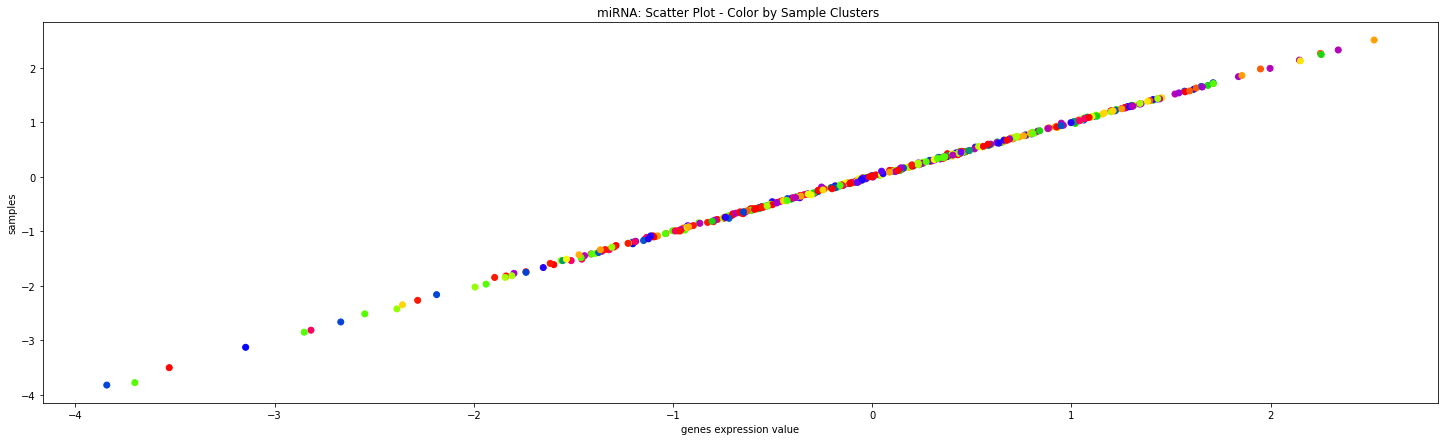

In [45]:
# 1. plot points with color by cluster
scatter_plot_samples(X, clusters, 'miRNA: Scatter Plot - Color by Sample Clusters ')

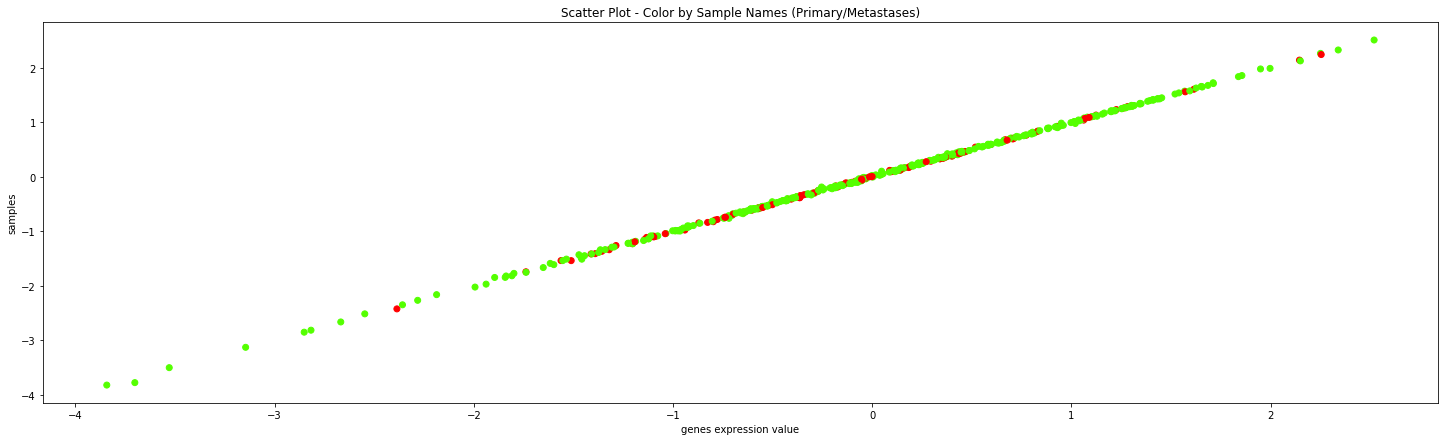

In [46]:
# 2. plot points with color by sample name (01 or 06) (actual tumor type: primary or metastases)

color_values = np.asarray(samples_label_list, dtype=np.int32)
scatter_plot_samples(X, color_values, 'Scatter Plot - Color by Sample Names (Primary/Metastases)')


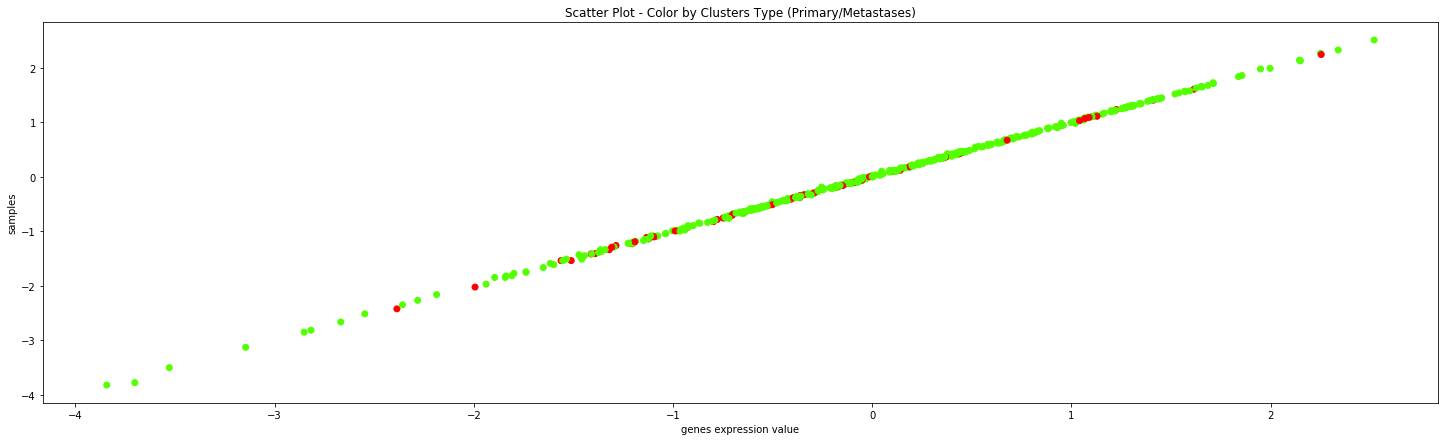

In [47]:
# 3. plot points with color by cluster tumor type (tumor typea as a result of clustering)
scatter_plot_samples(X, primary_metastases_clusters, 'Scatter Plot - Color by Clusters Type (Primary/Metastases)')

In [48]:
# Perform PCA in order to display data points on PCs

In [49]:
# normalize data to values between 0 and 1

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)

print("data has been rescaled")
print("after rescaling: min={}, max={}".format(round(data_rescaled.min(), 2), round(data_rescaled.max(), 2)))

data has been rescaled
after rescaling: min=0.0, max=1.0


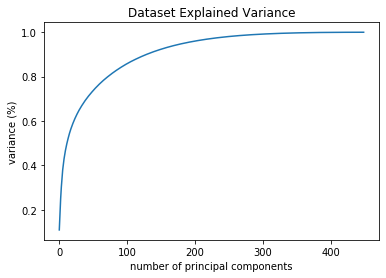

based on graph: selecting 200 principal components that appear to account for close to 100% of the variance


In [50]:
# Select number of principal components to use for PCA
    
plot_explained_variance(data_rescaled)

# based on this graph we need to decide how many principal components to use
# we will not select the maximum possible, in order to preserve only principal components
# however, we want to select a number of components where the graph slope is not very big

# we will decide to use 200 principal components

print("based on graph: selecting 200 principal components that appear to account for close to 100% of the variance")

In [51]:
# perform PCA with 300 components

components = 200

print("plotting the explained variance per principal component")
dataset = perform_pca_and_plot_explained_variance(X, data_rescaled, components)

# based on the graph, we can see that: 
# PC1 + PC2 are responsible for nearly 18% of the explained variance
# PC1 + PC2 + PC3 are responsible for nearly 25% of the explained variance
# we will use these 3 PCs to graph the points on these axis

plotting the explained variance per principal component


In [52]:
# PC1 + PC2 are responsible for 21% of the explained variance

In [53]:
add_cluster_info_to_dataset(a, clusters, cluster_types)

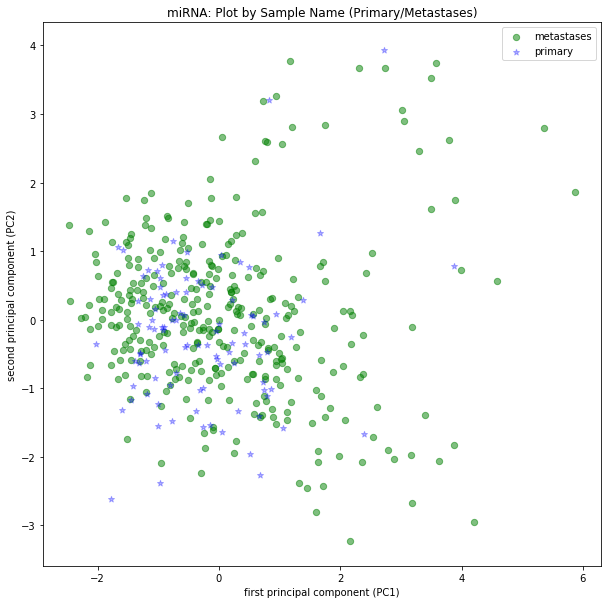

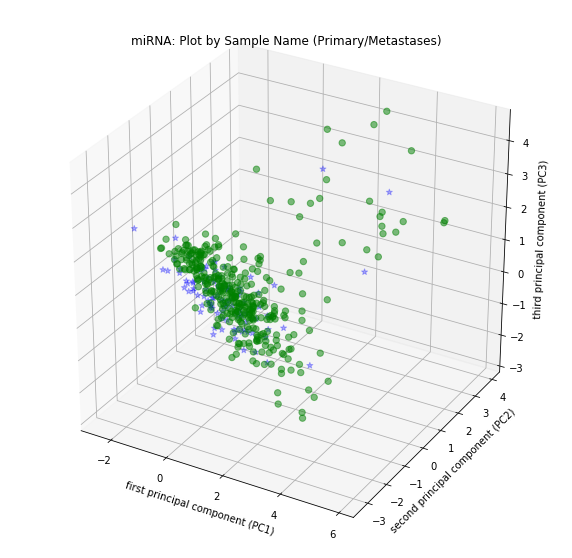

In [54]:
## 2D plot on PC1, PC2 by sample name (primary = 01, metastases = 06) ##

marker = {'primary':'*','metastases':'o'}
alpha = {'primary':.3, 'metastases':.5}

plot_2D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'}, 
        {'primary':'primary','metastases':'metastases'},
        "miRNA: Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 by sample name (primary = 01, metastases = 06) ##

plot_3D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'},
        {'primary':'primary','metastases':'metastases'},
        "miRNA: Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

# resulting picture is really similar to gene expression picture!

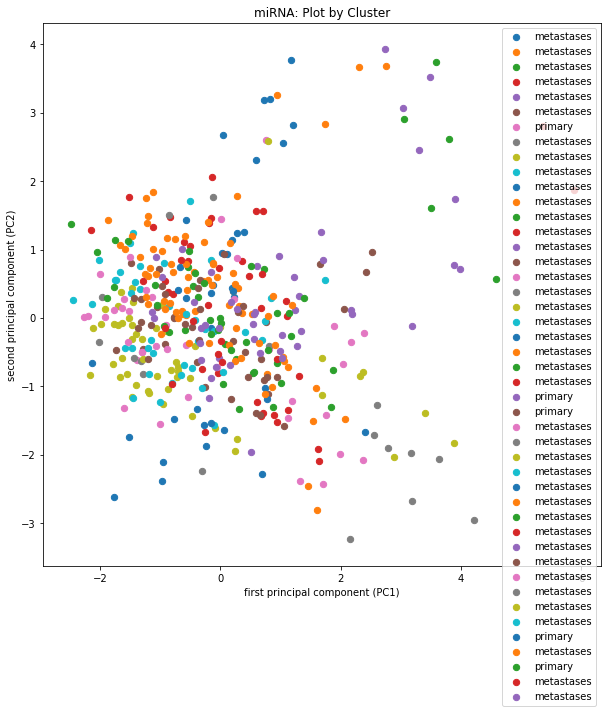

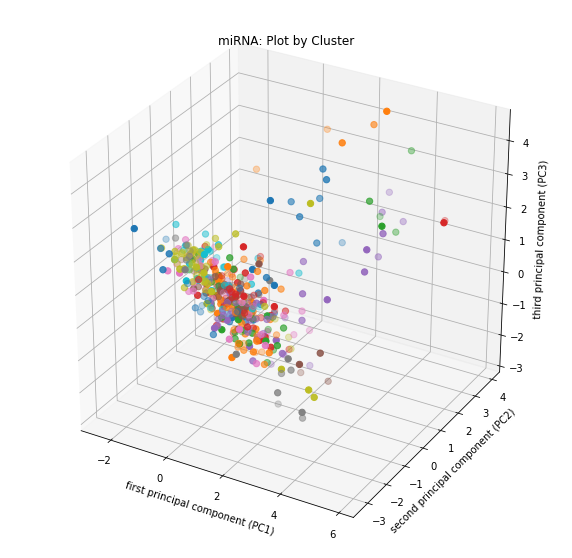

In [55]:
# specify labels
labl_dict = {}
for x in range(1, k+1):
    labl_dict[x] = cluster_types[x-1][1]


## 2D plot on PC1, PC2 by clustering results ##

plot_2D(dataset, a.cluster, a.cluster, labl_dict, "miRNA: Plot by Cluster")

## 3D plot on PC1, PC2, PC3 by clustering results ##

plot_3D(dataset, a.cluster, a.cluster, labl_dict, "miRNA: Plot by Cluster")


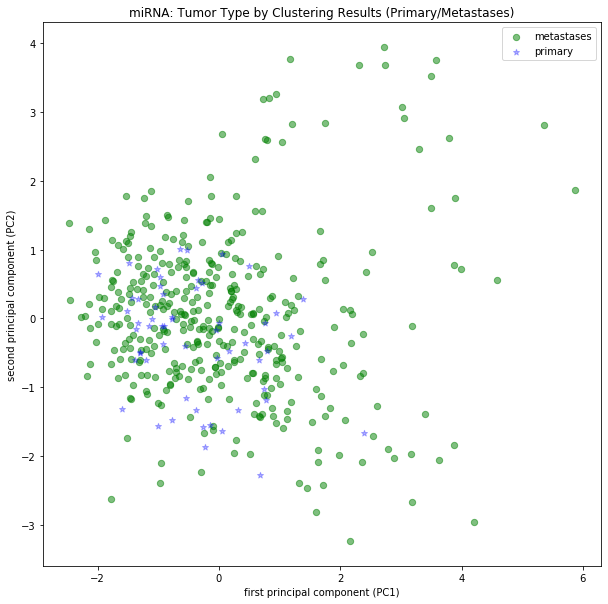

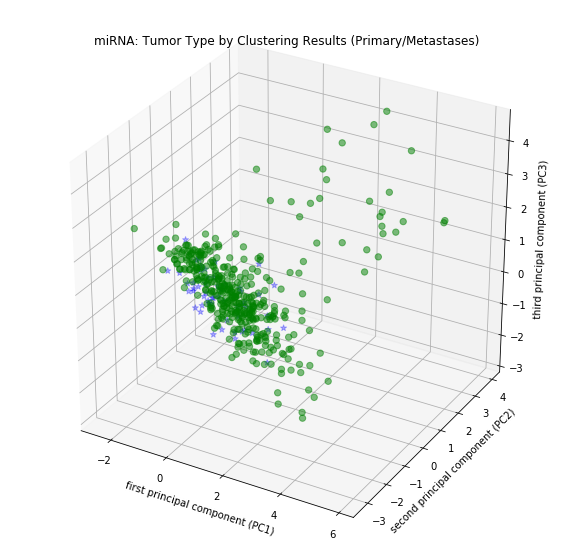

In [56]:
# specify labels

marker = {'primary':'*','metastases':'o', 'unknown':'.'}
alpha = {'primary':.3, 'metastases':.5, 'unknown':.2}

## 2D plot on PC1, PC2 tumor type by clustering results ##

plot_2D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "miRNA: Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 tumor type by clustering results ##
plot_3D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "miRNA: Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

Research Questions and Analysis Methodology:
    
<u>Question # 2</u>

**Qustion:**

**a) Which genes and miRNA have a higher expression in local skin metastases vs primary tumor?<br />
b) Which genes and miRNA have a higher expression in distant metastases?<br />
c) Which genes and miRNA have a higher expression in lymph nodes?<br />
d) Are the genes in the various organs similar?<br />**



Defining highly-expressed genes
Differential Gene Expression (DGE) Analysis: (see description in "Methods" section)
- This analysis is designed to be performed on counts (expression), not normalized data!
- To determine if a gene has been significantly expressed, we will use in this section:
       - P-value < 0.01
       - log2FoldChange: see values in the code (the usual boundary is +/-2)

        
**Analysis Description:**

Perform Differential Gene Expression (DGE) Analysis
- (a) Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe. As part of this process:
       - Divide dataframe into to 4 mini dataframes: primary tumor,local skin metastasis, distant metastasis, lymph nodes
       - Plot the relationship between mean and std for each mini dataframe.
       - Transpose full dataframe to get a matrix where samples are rows, dimensions (genes/miRNA) for columns 
       - Create a sample types dataset, where the condition is defined as: if type one: 1, otherwise 0 (type one is each one of the mini dataframes every time).
       - Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
- (b) Perform differential expression analysis
       - Run 2 types of tests on the data: Welch's t-test and rank sum test
       - Display an MA plot (this should be used to help define limits used to limit log2foldchange for high, low expression)
       - Graph volcano plots based on both tests to help differentiate significant values
       - Plot a comparison of both tests
       - Create a dataset of highly expressed genes/miRNAs and slightly expressed genes/miRNAs using p-value=0.01 (or different values),  log2foldchange: see values in the code for slightly expressed and highly expressed.
       - merge all highly expressed genes into one dataframe, slightly expressed genes into one dataframe
       - return highly expressed and slightly expressed dataframes for:
            - Distant metastasis
            - Lymph
            - Local skin metastasis
            - Primary tumor

- (c) Finding common highly and slightly genes and miRNAs in those groups:
        - Local skin metastases and primary tumor
        - Local skin metastases, distant metastases, lymph nodes
        - Primary tumor, local skin metastases, distant metastases, lymph nodes


**Question 2 Conclusion**
- When we obtain highly-expressed genes for local skin metastasis vs primary there are no gene similarities.
- When we obtain highly-expressed genes for lymph metastasis vs local skin metastasis vs distant tissues in the different methods we devised, there are gene similarities. 
- However, if we use the method we created to analyze lymph metastasis vs local skin metastasis vs distant tissues, we find similarities in some of our resulting genes.


In [57]:
# differential expression analysis using diffxpy 
# (installation instructions: https://github.com/theislab/diffxpy/blob/master/docs/installation.rst)

# import relevant packages for differential expression analysis
import anndata
import logging
import scipy.stats
import batchglm
import diffxpy.api as de

In [58]:
# function to add dataframes after data editing
def add_not_normalized_dataframe(name, dataframe, data_type, column_name):
    not_normalized_dataframes[name] = dataframe.iloc[1:, :]
    not_normalized_dataframes[name].columns = ['metastases_type'] + list(not_normalized_dataframes[data_type][column_name])
    not_normalized_dataframes[name]['metastases_type'] = name

# Part (a)
def divide_damples_by_organs(dataframe_name, column_name):
    def create_same_keys(df, column_name):
        """
        this function updates the sampleID row in the dataframes[dataframe_name] (miRNA or all the genes data)
        to match the first row in dataframes['clinical_data']
        """
        for i in df.index:
            value = df.at[i, column_name].replace('-', '.')
            df.at[i, column_name] = value

    create_same_keys(dataframes['clinical_data'], 'sampleID')

    data_transpose = not_normalized_dataframes[dataframe_name].T
    data_transpose.reset_index(
        inplace=True)  # create a column from the row headers, so the sample name is a column

    # this is only the clinical data divided according to 'tumor_tissue_site':
    lymph_clinical_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                            ['tumor_tissue_site'] == 'Regional Lymph Node'].filter(
        items=['sampleID'])

    distant_metastasisc_linical_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                                         [
                                                                             'tumor_tissue_site'] == 'Distant Metastasis'].filter(
        items=['sampleID'])

    primary_tumor_clinical_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                                    ['tumor_tissue_site'] == 'Primary Tumor'].filter(
        items=['sampleID'])

    local_skin_metastasis_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                                   ['tumor_tissue_site'] ==
                                                                   'Regional Cutaneous or Subcutaneous Tissue (includes satellite and in-transit metastasis)']. \
        filter(items=['sampleID'])

    # those are the genes data in every tumor_tissue_site:
    lymph_genes = pd.merge(lymph_clinical_data,
                           data_transpose,
                           right_on='index',
                           left_on='sampleID',
                           how='inner').drop(['sampleID'],
                                             axis=1)

    distant_metastasis_genes = pd.merge(distant_metastasisc_linical_data,
                                        data_transpose,
                                        right_on='index',
                                        left_on='sampleID',
                                        how='inner').drop(['sampleID'],
                                                          axis=1)

    primary_tumor_genes = pd.merge(primary_tumor_clinical_data,
                                   data_transpose,
                                   right_on='index',
                                   left_on='sampleID',
                                   how='inner').drop(['sampleID'],
                                                     axis=1)

    local_skin_metastasis_genes = pd.merge(local_skin_metastasis_data,
                                           data_transpose,
                                           right_on='index',
                                           left_on='sampleID',
                                           how='inner').drop(['sampleID'],
                                                             axis=1)

    add_not_normalized_dataframe(name='lymph',
                                   dataframe=lymph_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

    add_not_normalized_dataframe(name='distant_metastasis',
                                   dataframe=distant_metastasis_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

    add_not_normalized_dataframe(name='primary_tumor',
                                   dataframe=primary_tumor_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

    add_not_normalized_dataframe(name='local_skin_metastasis',
                                   dataframe=local_skin_metastasis_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

In [59]:
# Part (a)
"""
This function graphes the mean and median gene expression/miRNAand 
edits the datasets to use the tests in part (c)
"""

def create_data_to_find_highly_expressed_genes(dataframe_names, single_df=False):
    if single_df:
        print(f'current data is: {dataframe_names[0]}')
    else:
        print(f'current datasets are: {dataframe_names[0]} and {dataframe_names[1]}')
    # concat dataframes
    df = not_normalized_dataframes[dataframe_names[0]]

    for name in dataframe_names[1:]:
        df = pd.concat(
            [df, not_normalized_dataframes[name]], sort=False)

    def perform_log_metastasis_type(dataframe, column_name):
        # perform log2 (val+1)
        dataframe = dataframe.apply(lambda x: np.log2(x.astype("float64") + 1) if x.name != column_name else x)
        return dataframe

    def plot_relationship_between_mean_and_std_metastasis_type(dataframe, title):
        mean_vals = dataframe.mean()  # these are the expected values
        std_vals = dataframe.std()  # this is the variance
        plt.figure(figsize=(7, 7))  # set figure size
        plt.title("plotting relationship between mean (after log) and std: {}".format(title))  # set title
        plt.xlabel('mean (log)')  # label x axis
        plt.ylabel('standard deviation')  # label y axis
        plt.scatter(mean_vals, std_vals)
        plt.show()

    def log_and_plot(dataframe, column_name, title):
        x = perform_log_metastasis_type(dataframe, column_name)
        plot_relationship_between_mean_and_std_metastasis_type(x, title)

    # plotting mean (after log) vs std, for each dataframe
    if single_df:
        log_and_plot(not_normalized_dataframes[dataframe_names[0]], 'metastases_type', dataframe_names[0])

    else:
        for dataframe_name in dataframe_names:
            log_and_plot(not_normalized_dataframes[dataframe_name], 'metastases_type', dataframe_name)

    # plotting mean (after log) vs std, combined dataframe
    log_and_plot(df, 'metastases_type', f'combined dataframes:{dataframe_names}')

    # no need to transform data, it is already in the correct format, we just need to exclude the column 'metastases_type'
    X = df.iloc[:, 1:].to_numpy()

    def create_sample_description_dataset(dataframe):
        sample_descriptions = pd.DataFrame(
            [dataframe_names.index(x) if x in dataframe_names else 8 for x in list(dataframe.metastases_type)])
        if single_df:
            sample_descriptions = pd.DataFrame(
                [1 if x == dataframe_names[0] else 0 for x in list(dataframe.metastases_type)])
        else:
            sample_descriptions = pd.DataFrame(
                [dataframe_names.index(x) if x in dataframe_names else 8 for x in list(dataframe.metastases_type)])
        sample_descriptions['batch'] = 0
        sample_descriptions.columns = ['condition', 'batch']
        return sample_descriptions

    sample_descriptions = create_sample_description_dataset(df)

    # create a column list that includes all genes and does not include 'metastases_type'
    cols = list(df.columns)[1:]

    data = anndata.AnnData(
        X=X,
        var=pd.DataFrame(index=cols),
        obs=sample_descriptions
    )

    return data


In [60]:
# part (b)
def differential_expression_analysis_multiple_groups(data, 
                                                     axis_name, 
                                                     log2fc_bottom=-7.5, 
                                                     log_2fc_top=7.5,
                                                     p_value=0.01):
    """
    Running differential expression tests:

    1. Welch's t-test
    2. Rank sum test

    For t-tests and rank sum tests, the grouping argument indicates the the name of the relevant condition column
    in the sample description
    """

    print("Performing differential expression tests and displaying sample results\n")

    print("Running Welch's T-Test:\n")

    # Welch's t-test
    test_tt = de.test.t_test(
        data=data,
        grouping="condition")

    print(test_tt.summary().iloc[:5, :-2])

    print("\nRunning Rank-Sum Test:\n")
    # Rank sum test
    test_rank = de.test.rank_test(
        data=data,
        grouping="condition"
    )
    print(test_rank.summary().iloc[:5, :-2])

    """
    MA Plot
    An MA-plot is a 2D plot that shows the log2-fold change vs mean expression
    """
    print("\nPrinting MA plot: shows log2-fold changes vs mean expression")
    test_tt.plot_ma()

    """
    Volcano Plot
    A volcano plot is a 2D scatter plot shaped like a volcano
    It is used to show statistically significant gene expression changes from two different conditions
    It displayes log fold change vs p-value

    """
    print("\nGraphing volcano plot: shows log fold change vs p-value\n")

    print("T-Test volcano plot:\n")
    test_tt.plot_volcano()

    print("Rank-Sum test volcano plot:\n")
    test_rank.plot_volcano()

    """
    Scatter plot of log10_pval for t-test vs log10_pval for rank sum test:
    """

    print("Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)")
    # compare 2 results
    sns.scatterplot(x=test_tt.log10_pval_clean(), y=test_rank.log10_pval_clean())
    plt.show()

    """
    Returning Highly and Slightly Expressed Genes
    To determine if a gene has been significantly expressed, we use:
    1. P-value: 0.01 by default
    2. log2FoldChange: we add as a parameter to the function. 
        we read that fold-change of +/- 2 is often used as the threshold for defining significant differential 
        expression, therefore we will use a minimum of log fold-change +2 to define highly-expressed genes and
        a maximum of -2 to define slightly expressed genes. However, we will select actual values to use by 
        examining an MA-Plot and seeing outlying values graphically.     
    """

    print("\nDetermining which genes are highly/slightly expressed using:")
    print(f"p-value: {p_value} or lower")
    print("log2FoldChange: {} or greater for highly expressed, {} or lower for slightly expressed".format(log_2fc_top, log2fc_bottom))

    # defining highly-expressed genes based on t-test
    highly_expressed_tt = test_tt.summary()
    highly_expressed_tt = highly_expressed_tt[(highly_expressed_tt.pval < p_value) & (highly_expressed_tt.log2fc >= log_2fc_top)]

    # defining slightly-expressed genes based on t-test
    slightly_expressed_tt = test_tt.summary()
    slightly_expressed_tt = slightly_expressed_tt[
        (slightly_expressed_tt.pval < p_value) &
        (slightly_expressed_tt.log2fc <= log2fc_bottom)]
    print("\nT-Test Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_tt)

    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_tt)

    # defining highly-expressed genes based on rank-sum test
    highly_expressed_rt = test_rank.summary()
    highly_expressed_rt = highly_expressed_rt[(highly_expressed_rt.pval < p_value) & (highly_expressed_rt.log2fc >= log_2fc_top)]

    # defining slightly-expressed genes based on t-test
    slightly_expressed_rt = test_rank.summary()
    slightly_expressed_rt = slightly_expressed_rt[
        (slightly_expressed_rt.pval < p_value) &
        (slightly_expressed_rt.log2fc <= log2fc_bottom)]
    print("\nRank-Sum Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_rt)

    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_rt)

    # combine hightly-expressed dataframes
    highly_expressed = pd.merge(
        highly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']],
        highly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']],
        on='gene',
        how='outer')

    slightly_expressed = pd.merge(
        slightly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']],
        slightly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']],
        on='gene',
        how='outer')

    print("\nOverall highly expresed:")
    display(highly_expressed)
    print("\nOverall slightly expresed:")
    display(slightly_expressed)

    return highly_expressed, slightly_expressed


In [61]:
# Running  the analysis
# Part (a) Genes expression:
divide_damples_by_organs(dataframe_name='gene_data', column_name='gene')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



current data is: distant_metastasis


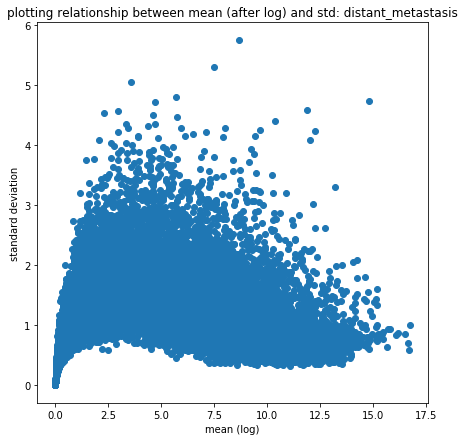

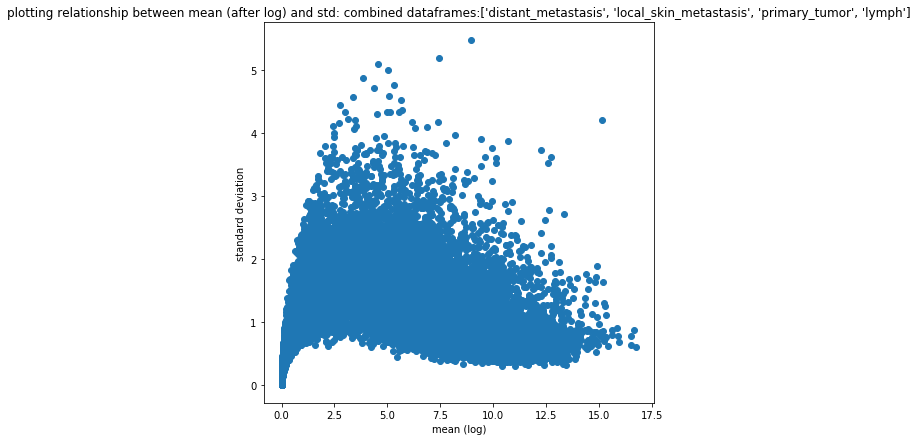

Transforming to str index.


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.854047  0.951536 -0.025767  295.096493
1    A1CF.29974  0.699669  0.887999 -0.248840    0.177044
2   A2BP1.54715  0.328710  0.673377 -1.755027    4.772782
3   A2LD1.87769  0.031410  0.247085  0.295815  100.737705
4  A2ML1.144568  0.001659  0.050611 -2.197210  255.480630

Running Rank-Sum Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.764449  0.925845 -0.025767  295.096493
1    A1CF.29974  0.231611  0.607258 -0.248840    0.177044
2   A2BP1.54715  0.482355  0.794597 -1.755027    4.772782
3   A2LD1.87769  0.014209  0.168489  0.295815  100.737705
4  A2ML1.144568  0.091585  0.411069 -2.197210  255.480630

Printing MA plot: shows log2-fold changes vs mean expression


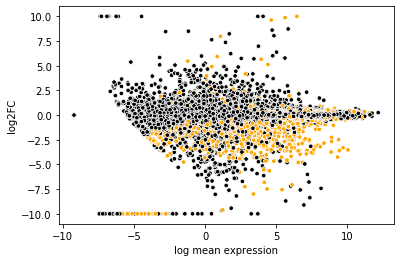


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



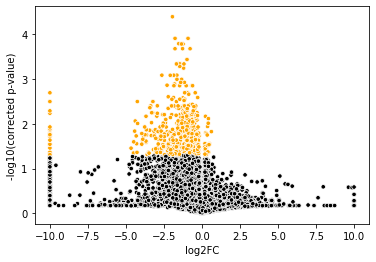

Rank-Sum test volcano plot:



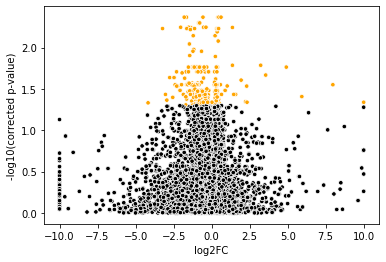

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


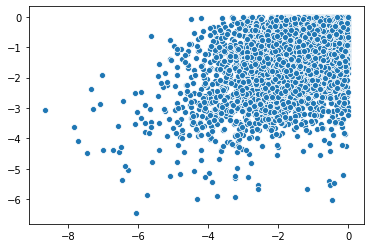


Determining which genes are highly/slightly expressed using:
p-value: 0.015 or lower
log2FoldChange: 4.5 or greater for highly expressed, -7.5 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



gene      pval      qval    log2fc       mean  zero_mean  \
15394  SLC34A2.10568  0.011639  0.146399  5.120781  82.492832      False   

       zero_variance  
15394          False


Slightly Expressed Genes:



gene      pval      qval       log2fc       mean  \
8                AAA1.404744  0.001269  0.043664 -1067.555336   0.009819   
772              APOBEC1.339  0.005498  0.099568 -1067.226593   0.007818   
1385            BEYLA.497634  0.006615  0.109361 -1067.449083   0.009122   
1619         C10orf96.374355  0.001968  0.055830 -1068.275012   0.016170   
3833              CNGA2.1260  0.010267  0.136330 -1067.393118   0.008775   
4120              CRYGA.1418  0.000551  0.027846 -1068.564210   0.019760   
4570             DEFB4A.1673  0.007659  0.118058    -7.989352  29.715205   
5570          FAM138D.677784  0.005763  0.102122 -1067.760017   0.011316   
5768           FAM71B.153745  0.000214  0.016137 -1068.350779   0.017042   
5782          FAM74A4.401508  0.005605  0.100636 -1069.454308   0.036621   
6051         FLJ25328.148231  0.000154  0.013795 -1068.512992   0.019070   
6557                GK2.2712  0.001817  0.053383 -1067.676818   0.010682   
6730           GOT1L1.137362  0.001393  0.045729 -1067.534400   0.009678   
7483              HPVC1.3262  0.011017  0.141468 -1066.813985   0.005874   
8857            LCE3A.353142  0.004020  0.084057    -9.605662   3.443921   
9223        LOC151658.151658  0.000008  0.003168 -1068.920386   0.025293   
9314        LOC285627.285627  0.008668  0.124148 -1066.907094   0.006265   
9328        LOC286094.286094  0.002545  0.064373 -1067.842091   0.011978   
9362        LOC360030.360030  0.001221  0.042790 -1067.839904   0.011960   
9833             LYZL6.57151  0.010659  0.138736 -1067.051778   0.006926   
10084           MCCD1.401250  0.000134  0.012838 -1068.368134   0.017249   
10273        MGC26647.219557  0.007245  0.114113 -1068.991570   0.026572   
11584              OCM2.4951  0.002932  0.069408 -1068.354704   0.017089   
11654           OR10A3.26496  0.009075  0.127293 -1068.500454   0.018905   
11670           OR10H3.26532  0.011917  0.147555 -1066.679994   0.005353   
11675          OR10J5.127385  0.009079  0.127293 -1066.654684   0.005260   
11693           OR12D2.26529  0.000298  0.018984 -1069.032655   0.027340   
11697          OR13C3.138803  0.005280  0.097045 -1066.852614   0.006033   
11705          OR13H1.347468  0.003194  0.073705 -1068.088380   0.014208   
11716             OR1D4.8385  0.000608  0.029137 -1068.128946   0.014613   
...                      ...       ...       ...          ...        ...   
11790          OR2T34.127068  0.008059  0.120005 -1067.005655   0.006708   
11806           OR3A4.390756  0.000839  0.034488 -1068.253736   0.015934   
11822          OR4D11.219986  0.002435  0.063007 -1068.058757   0.013919   
11828            OR4E2.26686  0.010351  0.136683 -1066.927931   0.006356   
11833            OR4F4.26682  0.004340  0.087190 -1067.825924   0.011845   
11837          OR4K14.122740  0.003623  0.078674 -1067.503056   0.009470   
11851           OR4Q3.441669  0.002137  0.058202 -1067.947528   0.012887   
11860          OR51B6.390058  0.004553  0.089048 -1067.813162   0.011741   
11890          OR52J3.119679  0.003209  0.073721 -1067.192353   0.007635   
11899          OR52R1.119695  0.006300  0.107274 -1068.940791   0.025653   
11954           OR5W2.390148  0.000579  0.028466 -1068.225756   0.015628   
11962           OR6C4.341418  0.004229  0.086067 -1067.728139   0.011069   
11964          OR6C68.403284  0.014451  0.163730 -1066.546647   0.004880   
11980           OR6T1.219874  0.003225  0.073836 -1067.678509   0.010694   
11983           OR6Y1.391112  0.013730  0.158858 -1066.812552   0.005868   
12002           OR8B3.390271  0.003287  0.074516 -1067.399460   0.008814   
13180        PRAMEF16.654348  0.000004  0.002015 -1069.190403   0.030499   
13227             PRG3.10394  0.000408  0.023088 -1068.146642   0.014794   
14001          RESP18.389075  0.004006  0.083853 -1068.391768   0.017533   
15749         SNORA38.677820  0.012934  0.154042 -1068.015353   0.013507   
15773         SNORA5B.677795  0.008362  0.122083 -1066.989117   0.006632


Rank-Sum Results:

Highly Expressed Genes:



gene      pval      qval       log2fc        mean  \
407        AGR3.155465  0.000037  0.017215     4.913182    1.603748   
2209   C20orf85.128602  0.004395  0.098815     7.631857    1.585217   
4328      CYP17A1.1586  0.003639  0.090106     8.725952  341.671708   
6562       GKN2.200504  0.013958  0.167086     5.465406    0.295815   
8309        KERA.11081  0.006546  0.118048     5.697556   30.779426   
11843     OR4L1.122742  0.009912  0.141472     5.372006    0.005406   
12523         PGC.5225  0.014773  0.171237     4.917940    3.760208   
14581        S100G.795  0.000587  0.045789  1067.772258    0.001931   
14713     SCGB1A1.7356  0.000925  0.052591    11.615742   58.641105   
15020     SFTA2.389376  0.000385  0.039099     5.933898    2.331057   
15021     SFTA3.253970  0.000120  0.028099     7.974193    2.942370   
16399        STAR.6770  0.001462  0.061329     6.376298  151.118058   

       zero_mean  zero_variance  
407        False          False  
2209       False          False  
4328       False          False  
6562       False          False  
8309       False          False  
11843      False          False  
12523      False          False  
14581      False          False  
14713      False          False  
15020      False          False  
15021      False          False  
16399      False          False


Slightly Expressed Genes:



gene      pval      qval     log2fc       mean  zero_mean  \
8683    KRT85.3891  0.002259  0.074146 -10.715131  40.471987      False   
8857  LCE3A.353142  0.006451  0.117377  -9.605662   3.443921      False   

      zero_variance  
8683          False  
8857          False


Overall highly expresed:


gene    pval_x  log2fc_x     mean_x    pval_y     log2fc_y  \
0     SLC34A2.10568  0.011639  5.120781  82.492832       NaN          NaN   
1       AGR3.155465       NaN       NaN        NaN  0.000037     4.913182   
2   C20orf85.128602       NaN       NaN        NaN  0.004395     7.631857   
3      CYP17A1.1586       NaN       NaN        NaN  0.003639     8.725952   
4       GKN2.200504       NaN       NaN        NaN  0.013958     5.465406   
5        KERA.11081       NaN       NaN        NaN  0.006546     5.697556   
6      OR4L1.122742       NaN       NaN        NaN  0.009912     5.372006   
7          PGC.5225       NaN       NaN        NaN  0.014773     4.917940   
8         S100G.795       NaN       NaN        NaN  0.000587  1067.772258   
9      SCGB1A1.7356       NaN       NaN        NaN  0.000925    11.615742   
10     SFTA2.389376       NaN       NaN        NaN  0.000385     5.933898   
11     SFTA3.253970       NaN       NaN        NaN  0.000120     7.974193   
12        STAR.6770       NaN       NaN        NaN  0.001462     6.376298   

        mean_y  
0          NaN  
1     1.603748  
2     1.585217  
3   341.671708  
4     0.295815  
5    30.779426  
6     0.005406  
7     3.760208  
8     0.001931  
9    58.641105  
10    2.331057  
11    2.942370  
12  151.118058


Overall slightly expresed:


gene    pval_x     log2fc_x     mean_x    pval_y  \
0             AAA1.404744  0.001269 -1067.555336   0.009819       NaN   
1             APOBEC1.339  0.005498 -1067.226593   0.007818       NaN   
2            BEYLA.497634  0.006615 -1067.449083   0.009122       NaN   
3         C10orf96.374355  0.001968 -1068.275012   0.016170       NaN   
4              CNGA2.1260  0.010267 -1067.393118   0.008775       NaN   
5              CRYGA.1418  0.000551 -1068.564210   0.019760       NaN   
6             DEFB4A.1673  0.007659    -7.989352  29.715205       NaN   
7          FAM138D.677784  0.005763 -1067.760017   0.011316       NaN   
8           FAM71B.153745  0.000214 -1068.350779   0.017042       NaN   
9          FAM74A4.401508  0.005605 -1069.454308   0.036621       NaN   
10        FLJ25328.148231  0.000154 -1068.512992   0.019070       NaN   
11               GK2.2712  0.001817 -1067.676818   0.010682       NaN   
12          GOT1L1.137362  0.001393 -1067.534400   0.009678       NaN   
13             HPVC1.3262  0.011017 -1066.813985   0.005874       NaN   
14           LCE3A.353142  0.004020    -9.605662   3.443921  0.006451   
15       LOC151658.151658  0.000008 -1068.920386   0.025293       NaN   
16       LOC285627.285627  0.008668 -1066.907094   0.006265       NaN   
17       LOC286094.286094  0.002545 -1067.842091   0.011978       NaN   
18       LOC360030.360030  0.001221 -1067.839904   0.011960       NaN   
19            LYZL6.57151  0.010659 -1067.051778   0.006926       NaN   
20           MCCD1.401250  0.000134 -1068.368134   0.017249       NaN   
21        MGC26647.219557  0.007245 -1068.991570   0.026572       NaN   
22              OCM2.4951  0.002932 -1068.354704   0.017089       NaN   
23           OR10A3.26496  0.009075 -1068.500454   0.018905       NaN   
24           OR10H3.26532  0.011917 -1066.679994   0.005353       NaN   
25          OR10J5.127385  0.009079 -1066.654684   0.005260       NaN   
26           OR12D2.26529  0.000298 -1069.032655   0.027340       NaN   
27          OR13C3.138803  0.005280 -1066.852614   0.006033       NaN   
28          OR13H1.347468  0.003194 -1068.088380   0.014208       NaN   
29             OR1D4.8385  0.000608 -1068.128946   0.014613       NaN   
..                    ...       ...          ...        ...       ...   
38           OR3A4.390756  0.000839 -1068.253736   0.015934       NaN   
39          OR4D11.219986  0.002435 -1068.058757   0.013919       NaN   
40            OR4E2.26686  0.010351 -1066.927931   0.006356       NaN   
41            OR4F4.26682  0.004340 -1067.825924   0.011845       NaN   
42          OR4K14.122740  0.003623 -1067.503056   0.009470       NaN   
43           OR4Q3.441669  0.002137 -1067.947528   0.012887       NaN   
44          OR51B6.390058  0.004553 -1067.813162   0.011741       NaN   
45          OR52J3.119679  0.003209 -1067.192353   0.007635       NaN   
46          OR52R1.119695  0.006300 -1068.940791   0.025653       NaN   
47           OR5W2.390148  0.000579 -1068.225756   0.015628       NaN   
48           OR6C4.341418  0.004229 -1067.728139   0.011069       NaN   
49          OR6C68.403284  0.014451 -1066.546647   0.004880       NaN   
50           OR6T1.219874  0.003225 -1067.678509   0.010694       NaN   
51           OR6Y1.391112  0.013730 -1066.812552   0.005868       NaN   
52           OR8B3.390271  0.003287 -1067.399460   0.008814       NaN   
53        PRAMEF16.654348  0.000004 -1069.190403   0.030499       NaN   
54             PRG3.10394  0.000408 -1068.146642   0.014794       NaN   
55          RESP18.389075  0.004006 -1068.391768   0.017533       NaN   
56         SNORA38.677820  0.012934 -1068.015353   0.013507       NaN   
57         SNORA5B.677795  0.008362 -1066.989117   0.006632       NaN   
58  SNORD115.13.100033450  0.007943 -1068.091228   0.014236       NaN   
59         SPATA19.219938  0.000249 -1069.567880   0.039620       NaN   
60         TCP10L2.401285  0.010584 -1067.625328   0.010307       NaN   
61    

In [62]:
# Part (b) distant metastasis vs (local skin metastasis, lymph and primary tumor)
data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['distant_metastasis', 'local_skin_metastasis', 'primary_tumor', 'lymph'], single_df=True)

highly_expressed_genes_distant, slightly_expressed_genes_distant = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-7.5,
                                                                                                        log_2fc_top=4.5,
                                                                                                         p_value=0.015)


current data is: lymph


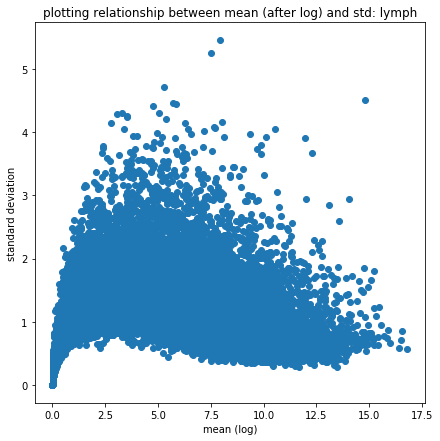

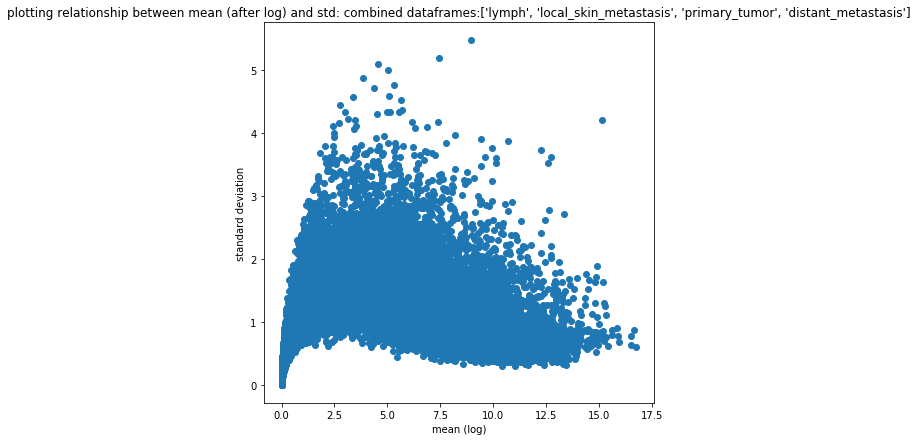

Transforming to str index.


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.004882  0.035273 -0.303475  295.096609
1    A1CF.29974  0.728767  0.844954  0.270092    0.177044
2   A2BP1.54715  0.558872  0.726469 -1.156612    4.772783
3   A2LD1.87769  0.150227  0.347975 -0.123122  100.737685
4  A2ML1.144568  0.000017  0.000587 -4.932567  255.480580

Running Rank-Sum Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.001149  0.007883 -0.303475  295.096609
1    A1CF.29974  0.521507  0.676850  0.270092    0.177044
2   A2BP1.54715  0.294109  0.466368 -1.156612    4.772783
3   A2LD1.87769  0.233615  0.399513 -0.123122  100.737685
4  A2ML1.144568  0.001558  0.010078 -4.932567  255.480580

Printing MA plot: shows log2-fold changes vs mean expression


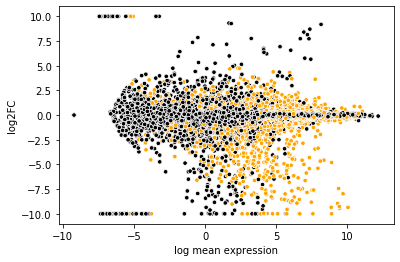


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



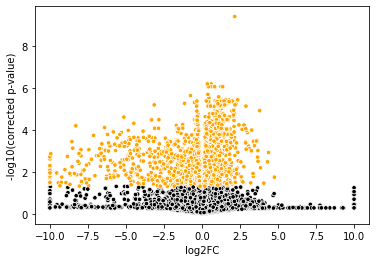

Rank-Sum test volcano plot:



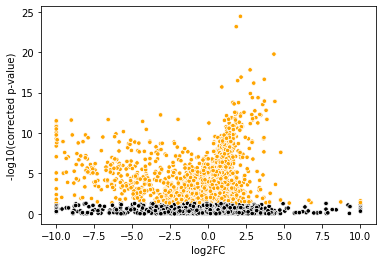

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


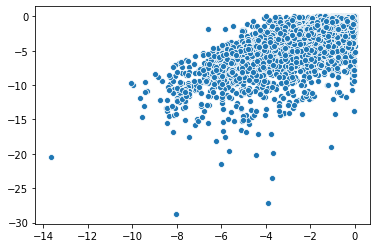


Determining which genes are highly/slightly expressed using:
p-value: 0.015 or lower
log2FoldChange: 4 or greater for highly expressed, -8 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



gene      pval      qval       log2fc        mean  zero_mean  \
3751    CLEC4M.10332  0.001901  0.018242     4.762780    9.984295      False   
4047        CR2.1380  0.000187  0.003395     4.311749  380.066616      False   
5886      FCER2.2208  0.000047  0.001215     4.376797  119.539404      False   
11775  OR2M1P.388762  0.004821  0.035019     4.066347    0.015256      False   
11828    OR4E2.26686  0.010136  0.057953  1067.775928    0.006356      False   

       zero_variance  
3751           False  
4047           False  
5886           False  
11775          False  
11828          False


Slightly Expressed Genes:



gene          pval      qval       log2fc          mean  \
2136   C1orf68.100129271  5.044582e-04  0.007078   -10.554605     29.948235   
2624      C8orf74.203076  2.342325e-03  0.021278 -1069.483532      0.022932   
2856        CARD18.59082  5.866435e-04  0.007905    -9.011834      6.652396   
2878        CASP14.23581  9.754651e-05  0.002060   -11.894106    162.492344   
4570         DEFB4A.1673  7.664040e-03  0.048183    -8.058489     29.715199   
4926           DSG1.1828  6.756193e-07  0.000065    -8.299259    524.928802   
5692       FAM25A.643161  2.277772e-04  0.003934    -8.080093     38.255881   
5693    FAM25B.100132929  6.597930e-04  0.008586   -10.279029      6.658748   
6035         FLG2.388698  8.464437e-05  0.001862    -8.848550    416.870347   
7748        IGFL1.374918  8.928775e-03  0.053493   -10.263872    114.293522   
8091            IVL.3713  3.831936e-04  0.005801    -8.543432    747.953373   
8588          KLK5.25818  1.296260e-03  0.013917    -8.642056    329.667993   
8590           KLK7.5650  2.382618e-05  0.000760    -8.502296    272.301637   
8592         KLK9.284366  1.879110e-03  0.018069    -9.220441     57.352416   
8621         KPRP.448834  1.470917e-02  0.075479    -8.513327    214.872947   
8635          KRT14.3861  5.426025e-03  0.037863    -9.349405  22900.671047   
8637          KRT16.3868  4.526916e-03  0.033598    -9.445064  12779.130629   
8638          KRT17.3872  4.475496e-03  0.033362    -8.947794  10971.677904   
8641           KRT1.3848  3.235913e-04  0.005099   -11.399884   7234.003445   
8666          KRT6B.3854  4.217887e-03  0.032017    -9.253246  12393.103412   
8667        KRT6C.286887  7.374053e-03  0.046823    -9.341629   7011.125347   
8771       KRTDAP.388533  1.206082e-04  0.002462   -10.324842    713.202091   
8848        LCE1B.353132  1.305084e-03  0.013988    -8.241069     38.921348   
8849        LCE1C.353133  1.054209e-03  0.011937    -8.691611     70.998903   
8854         LCE2B.26239  1.740079e-03  0.017162   -13.786269     55.922092   
8855        LCE2C.353140  2.053504e-03  0.019147   -11.415644     50.037221   
8856        LCE2D.353141  1.629715e-03  0.016390   -10.743784     19.499488   
8861        LCE3E.353145  8.202208e-03  0.050371    -9.968233     77.908459   
8864        LCE6A.448835  1.111795e-03  0.012463   -11.233826     13.392996   
8935      LGALS7B.653499  8.821007e-06  0.000366    -8.554753    257.912639   
8936         LGALS7.3963  9.812308e-04  0.011367   -10.056694    772.700112   
9594            LOR.4014  5.099298e-03  0.036366   -10.422465    309.981762   
9793        LY6G6C.80740  1.079660e-03  0.012189    -8.391986    110.801175   
12739     PLA2G4E.123745  5.403769e-05  0.001354    -8.087747     26.361840   
14575     S100A7A.338324  9.939222e-04  0.011479    -9.557346    315.307662   
14577        S100A7.6278  9.172167e-05  0.001965   -10.080200   1940.541552   
14928    SERPINB12.89777  1.737235e-04  0.003205    -8.155267     13.060459   
16233        SPRR1B.6699  9.686799e-03  0.056176    -8.821424   1740.963266   
16240        SPRR2G.6706  5.902522e-03  0.040088    -8.681472    451.948466   
18473      WFDC12.128488  4.264694e-03  0.032277   -11.018365     63.587891   
18478       WFDC5.149708  5.661254e-05  0.001386    -9.940631     61.217601   

       zero_mean  zero_variance  
2136       False          False  
2624       False          False  
2856       False          False  
2878       False          False  
4570       False          False  
4926       False          False  
5692       False          False  
5693       False          False  
6035       False          False  
7748       False          False  
8091       False          False  
8588       False          False  
8590       False          False  
8592       False          False  
8621       False          False  
8635       False          False  
8637       False          False  
8638       False          False  
8641       False          False  
8666       False     


Rank-Sum Results:

Highly Expressed Genes:



gene          pval          qval       log2fc         mean  \
590          AMY2A.279  9.769565e-03  4.013056e-02     6.751576    61.334931   
1697   C12orf50.160419  1.472845e-02  5.460130e-02     4.913866     6.985946   
2204   C20orf70.140683  4.130907e-03  2.107226e-02     6.611009    60.975330   
3751      CLEC4M.10332  3.299583e-10  2.467312e-08     4.762780     9.984295   
4047          CR2.1380  2.707103e-24  1.720634e-20     4.311749   380.066616   
5886        FCER2.2208  9.040895e-18  1.231370e-14     4.376797   119.539404   
11760      OR2F1.26211  3.731203e-03  1.942394e-02     4.747844     0.103331   
11775    OR2M1P.388762  3.211576e-04  2.880449e-03     4.066347     0.015256   
11828      OR4E2.26686  5.156404e-03  2.477995e-02  1067.775928     0.006356   
13182  PRAMEF18.391003  1.181531e-02  4.638549e-02     5.324141     0.628125   
13197        PRB3.5544  1.390133e-02  5.222820e-02     7.738406   799.131004   
13198        PRB4.5545  7.748411e-03  3.379385e-02     8.703873  1567.425694   
14443    RPS4Y2.140032  8.129207e-03  3.501517e-02     4.023030     2.873007   
15738   SNORA2B.677794  9.694296e-03  3.992459e-02  1067.529039     0.005357   
18297      VPREB1.7441  1.424500e-05  2.280636e-04     4.415963     0.498114   

       zero_mean  zero_variance  
590        False          False  
1697       False          False  
2204       False          False  
3751       False          False  
4047       False          False  
5886       False          False  
11760      False          False  
11775      False          False  
11828      False          False  
13182      False          False  
13197      False          False  
13198      False          False  
14443      False          False  
15738      False          False  
18297      False          False


Slightly Expressed Genes:



gene          pval          qval       log2fc  \
2136   C1orf68.100129271  2.906883e-12  4.819864e-10   -10.554605   
2624      C8orf74.203076  5.119276e-04  4.175122e-03 -1069.483532   
2856        CARD18.59082  5.604986e-15  2.485486e-12    -9.011834   
2878        CASP14.23581  3.797797e-14  1.270463e-11   -11.894106   
4374        CYP4F8.11283  3.288641e-05  4.563887e-04    -8.121435   
4570         DEFB4A.1673  9.589557e-10  6.283632e-08    -8.058489   
4926           DSG1.1828  2.109120e-08  8.877857e-07    -8.299259   
5477        FABP9.646480  4.003330e-03  2.056452e-02 -1075.628929   
5692       FAM25A.643161  8.464496e-13  1.724183e-10    -8.080093   
5693    FAM25B.100132929  9.487146e-15  3.848955e-12   -10.279029   
6035         FLG2.388698  9.049375e-06  1.558685e-04    -8.848550   
7748        IGFL1.374918  8.198587e-13  1.717919e-10   -10.263872   
8091            IVL.3713  3.187804e-06  6.466711e-05    -8.543432   
8588          KLK5.25818  5.061067e-10  3.509252e-08    -8.642056   
8590           KLK7.5650  4.075398e-09  2.146676e-07    -8.502296   
8592         KLK9.284366  1.475883e-09  9.166820e-08    -9.220441   
8621         KPRP.448834  3.837102e-09  2.032385e-07    -8.513327   
8635          KRT14.3861  2.378017e-09  1.399507e-07    -9.349405   
8637          KRT16.3868  3.480032e-10  2.571986e-08    -9.445064   
8638          KRT17.3872  8.346068e-13  1.724183e-10    -8.947794   
8641           KRT1.3848  6.387400e-05  7.867891e-04   -11.399884   
8651          KRT31.3881  3.349997e-07  9.257644e-06    -9.534774   
8654         KRT33B.3884  6.183183e-04  4.835969e-03    -8.799098   
8666          KRT6B.3854  7.126992e-06  1.285690e-04    -9.253246   
8667        KRT6C.286887  2.434349e-07  7.043729e-06    -9.341629   
8686           KRT9.3857  2.745768e-06  5.722000e-05   -10.046704   
8715    KRTAP19.3.337970  2.088308e-03  1.255355e-02    -8.372366   
8722     KRTAP2.2.728279  1.353691e-02  5.111323e-02    -8.048660   
8766      KRTAP9.4.85280  1.402569e-03  9.266870e-03    -9.640555   
8768      KRTAP9.9.81870  1.133508e-02  4.497295e-02 -1076.917876   
8771       KRTDAP.388533  3.902239e-11  4.000424e-09   -10.324842   
8848        LCE1B.353132  8.415984e-12  1.162869e-09    -8.241069   
8849        LCE1C.353133  1.848031e-08  7.883277e-07    -8.691611   
8854         LCE2B.26239  5.118643e-14  1.574230e-11   -13.786269   
8855        LCE2C.353140  1.370804e-09  8.598185e-08   -11.415644   
8856        LCE2D.353141  3.149558e-12  5.046704e-10   -10.743784   
8859        LCE3C.353144  1.515518e-03  9.859400e-03    -8.263409   
8861        LCE3E.353145  1.242962e-11  1.559263e-09    -9.968233   
8864        LCE6A.448835  3.616140e-13  8.619069e-11   -11.233826   
8935      LGALS7B.653499  1.365121e-11  1.686826e-09    -8.554753   
8936         LGALS7.3963  1.175276e-13  3.156361e-11   -10.056694   
9594            LOR.4014  2.777576e-03  1.556475e-02   -10.422465   
9793        LY6G6C.80740  1.042078e-09  6.781686e-08    -8.391986   
12739     PLA2G4E.123745  1.931340e-09  1.154445e-07    -8.087747   
13397      PSAPL1.768239  1.339219e-07  4.227854e-06    -8.043248   
14575     S100A7A.338324  8.219759e-12  1.144046e-09    -9.557346   
14577        S100A7.6278  3.055919e-07  8.569155e-06   -10.080200   
14928    SERPINB12.89777  1.495855e-06  3.415923e-05    -8.155267   
16233        SPRR1B.6699  1.749549e-07  5.363409e-06    -8.821424   
16240        SPRR2G.6706  2.152774e-06  4.643233e-05    -8.681472   
16242       SPRR4.163778  8.499748e-13  1.724183e-10   -10.870715   
18473      WFDC12.128488  7.247289e-15  3.070918e-12   -11.018365   
18478       WFDC5.149708  4.471860e-12  6.821554e-10    -9.940631   

               mean  zero_mean  zero_variance  
2136      29.948235      False          False  
2624       0.022932      False          False  
2856       6.652396      False          False  
2878     162.492344      False          False  
4374       2.327725      False          False  
4570 


Overall highly expresed:


gene    pval_x     log2fc_x      mean_x        pval_y  \
0      CLEC4M.10332  0.001901     4.762780    9.984295  3.299583e-10   
1          CR2.1380  0.000187     4.311749  380.066616  2.707103e-24   
2        FCER2.2208  0.000047     4.376797  119.539404  9.040895e-18   
3     OR2M1P.388762  0.004821     4.066347    0.015256  3.211576e-04   
4       OR4E2.26686  0.010136  1067.775928    0.006356  5.156404e-03   
5         AMY2A.279       NaN          NaN         NaN  9.769565e-03   
6   C12orf50.160419       NaN          NaN         NaN  1.472845e-02   
7   C20orf70.140683       NaN          NaN         NaN  4.130907e-03   
8       OR2F1.26211       NaN          NaN         NaN  3.731203e-03   
9   PRAMEF18.391003       NaN          NaN         NaN  1.181531e-02   
10        PRB3.5544       NaN          NaN         NaN  1.390133e-02   
11        PRB4.5545       NaN          NaN         NaN  7.748411e-03   
12    RPS4Y2.140032       NaN          NaN         NaN  8.129207e-03   
13   SNORA2B.677794       NaN          NaN         NaN  9.694296e-03   
14      VPREB1.7441       NaN          NaN         NaN  1.424500e-05   

       log2fc_y       mean_y  
0      4.762780     9.984295  
1      4.311749   380.066616  
2      4.376797   119.539404  
3      4.066347     0.015256  
4   1067.775928     0.006356  
5      6.751576    61.334931  
6      4.913866     6.985946  
7      6.611009    60.975330  
8      4.747844     0.103331  
9      5.324141     0.628125  
10     7.738406   799.131004  
11     8.703873  1567.425694  
12     4.023030     2.873007  
13  1067.529039     0.005357  
14     4.415963     0.498114


Overall slightly expresed:


gene        pval_x     log2fc_x        mean_x        pval_y  \
0   C1orf68.100129271  5.044582e-04   -10.554605     29.948235  2.906883e-12   
1      C8orf74.203076  2.342325e-03 -1069.483532      0.022932  5.119276e-04   
2        CARD18.59082  5.866435e-04    -9.011834      6.652396  5.604986e-15   
3        CASP14.23581  9.754651e-05   -11.894106    162.492344  3.797797e-14   
4         DEFB4A.1673  7.664040e-03    -8.058489     29.715199  9.589557e-10   
5           DSG1.1828  6.756193e-07    -8.299259    524.928802  2.109120e-08   
6       FAM25A.643161  2.277772e-04    -8.080093     38.255881  8.464496e-13   
7    FAM25B.100132929  6.597930e-04   -10.279029      6.658748  9.487146e-15   
8         FLG2.388698  8.464437e-05    -8.848550    416.870347  9.049375e-06   
9        IGFL1.374918  8.928775e-03   -10.263872    114.293522  8.198587e-13   
10           IVL.3713  3.831936e-04    -8.543432    747.953373  3.187804e-06   
11         KLK5.25818  1.296260e-03    -8.642056    329.667993  5.061067e-10   
12          KLK7.5650  2.382618e-05    -8.502296    272.301637  4.075398e-09   
13        KLK9.284366  1.879110e-03    -9.220441     57.352416  1.475883e-09   
14        KPRP.448834  1.470917e-02    -8.513327    214.872947  3.837102e-09   
15         KRT14.3861  5.426025e-03    -9.349405  22900.671047  2.378017e-09   
16         KRT16.3868  4.526916e-03    -9.445064  12779.130629  3.480032e-10   
17         KRT17.3872  4.475496e-03    -8.947794  10971.677904  8.346068e-13   
18          KRT1.3848  3.235913e-04   -11.399884   7234.003445  6.387400e-05   
19         KRT6B.3854  4.217887e-03    -9.253246  12393.103412  7.126992e-06   
20       KRT6C.286887  7.374053e-03    -9.341629   7011.125347  2.434349e-07   
21      KRTDAP.388533  1.206082e-04   -10.324842    713.202091  3.902239e-11   
22       LCE1B.353132  1.305084e-03    -8.241069     38.921348  8.415984e-12   
23       LCE1C.353133  1.054209e-03    -8.691611     70.998903  1.848031e-08   
24        LCE2B.26239  1.740079e-03   -13.786269     55.922092  5.118643e-14   
25       LCE2C.353140  2.053504e-03   -11.415644     50.037221  1.370804e-09   
26       LCE2D.353141  1.629715e-03   -10.743784     19.499488  3.149558e-12   
27       LCE3E.353145  8.202208e-03    -9.968233     77.908459  1.242962e-11   
28       LCE6A.448835  1.111795e-03   -11.233826     13.392996  3.616140e-13   
29     LGALS7B.653499  8.821007e-06    -8.554753    257.912639  1.365121e-11   
30        LGALS7.3963  9.812308e-04   -10.056694    772.700112  1.175276e-13   
31           LOR.4014  5.099298e-03   -10.422465    309.981762  2.777576e-03   
32       LY6G6C.80740  1.079660e-03    -8.391986    110.801175  1.042078e-09   
33     PLA2G4E.123745  5.403769e-05    -8.087747     26.361840  1.931340e-09   
34     S100A7A.338324  9.939222e-04    -9.557346    315.307662  8.219759e-12   
35        S100A7.6278  9.172167e-05   -10.080200   1940.541552  3.055919e-07   
36    SERPINB12.89777  1.737235e-04    -8.155267     13.060459  1.495855e-06   
37        SPRR1B.6699  9.686799e-03    -8.821424   1740.963266  1.749549e-07   
38        SPRR2G.6706  5.902522e-03    -8.681472    451.948466  2.152774e-06   
39      WFDC12.128488  4.264694e-03   -11.018365     63.587891  7.247289e-15   
40       WFDC5.149708  5.661254e-05    -9.940631     61.217601  4.471860e-12   
41       CYP4F8.11283           NaN          NaN           NaN  3.288641e-05   
42       FABP9.646480           NaN          NaN           NaN  4.003330e-03   
43         KRT31.3881           NaN          NaN           NaN  3.349997e-07   
44        KRT33B.3884           NaN          NaN           NaN  6.183183e-04   
45          KRT9.3857           NaN          NaN           NaN  2.745768e-06   
46   KRTAP19.3.337970           NaN          NaN           NaN  2.088308e-03   
47    KRTAP2.2.728279           NaN          NaN           NaN  1.353691e-02   
48     KRTAP9.4.85280           NaN          NaN           NaN  1.402569e-03   
49     KRTAP9.9.8

In [63]:
# Part (b) lymph vs (local skin metastasis, distant metastasis and primary tumor)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['lymph', 'local_skin_metastasis', 'primary_tumor', 'distant_metastasis'], single_df=True)

highly_expressed_genes_lymph, slightly_expressed_genes_lymph = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-8,
                                                                                                        log_2fc_top=4,
                                                                                                        p_value=0.015)


current data is: local_skin_metastasis


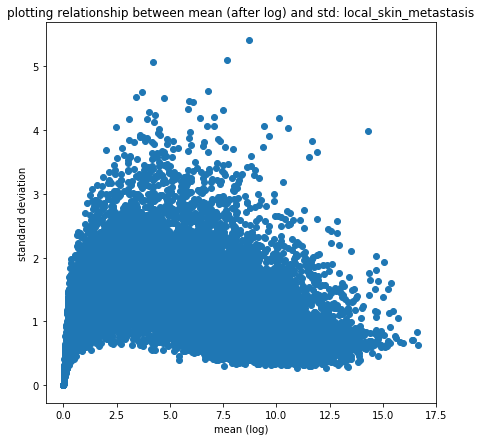

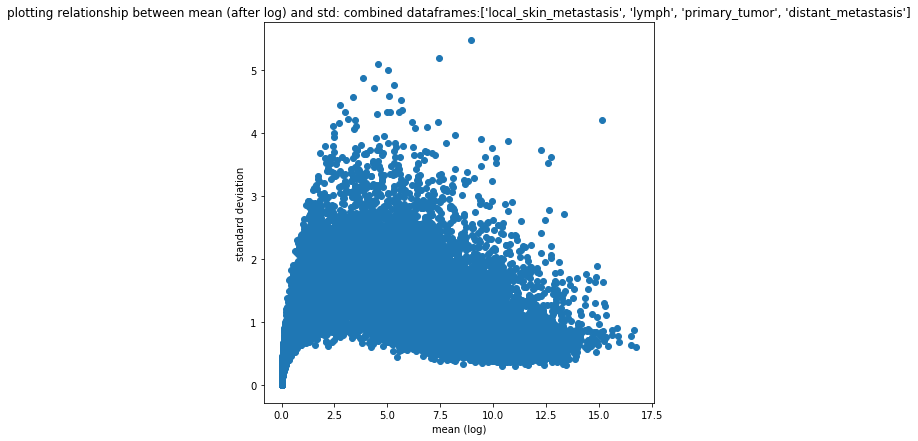

Transforming to str index.


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.152499  0.453963 -0.170074  295.096572
1    A1CF.29974  0.459766  0.712670 -0.544153    0.177044
2   A2BP1.54715  0.181863  0.490113 -3.363195    4.772783
3   A2LD1.87769  0.000368  0.029413 -0.378166  100.737678
4  A2ML1.144568  0.235261  0.548093 -1.033807  255.480583

Running Rank-Sum Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.411592  0.692368 -0.170074  295.096572
1    A1CF.29974  0.489858  0.748281 -0.544153    0.177044
2   A2BP1.54715  0.617295  0.829207 -3.363195    4.772783
3   A2LD1.87769  0.000820  0.043208 -0.378166  100.737678
4  A2ML1.144568  0.002878  0.075533 -1.033807  255.480583

Printing MA plot: shows log2-fold changes vs mean expression


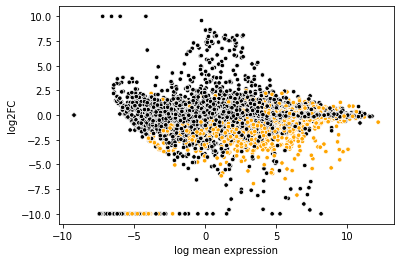


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



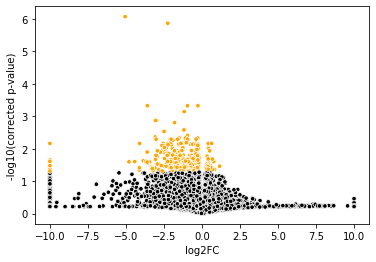

Rank-Sum test volcano plot:



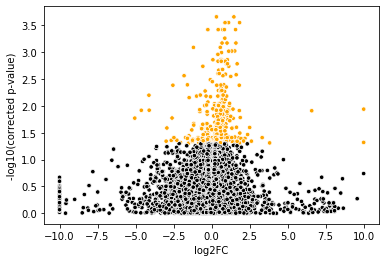

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


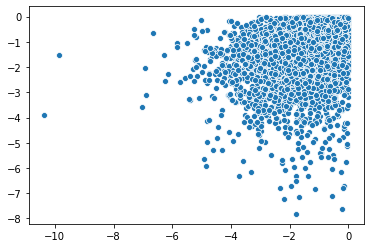


Determining which genes are highly/slightly expressed using:
p-value: 0.015 or lower
log2FoldChange: 2.5 or greater for highly expressed, -7 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, zero_variance]
Index: []


Slightly Expressed Genes:



gene      pval      qval       log2fc      mean  zero_mean  \
255       ADAM5P.255926  0.013648  0.155643 -1068.029004  0.013429      False   
1385       BEYLA.497634  0.006611  0.114858 -1067.471109  0.009122      False   
1773   C14orf177.283598  0.000571  0.035710 -1068.369180  0.017000      False   
2674      C9orf27.58483  0.013576  0.155195 -1067.688128  0.010603      False   
4200        CSTT.164380  0.001523  0.057293 -1067.824747  0.011656      False   
5570     FAM138D.677784  0.005760  0.107147 -1067.782044  0.011316      False   
6187    FRMPD2L1.728798  0.009336  0.131813 -1066.786031  0.005674      False   
6301      GABRR3.200959  0.000804  0.042127 -1067.738378  0.010979      False   
7483         HPVC1.3262  0.011013  0.141528 -1066.836011  0.005874      False   
9230   LOC154449.154449  0.004813  0.098901 -1068.571512  0.019559      False   
9307   LOC285375.285375  0.003613  0.085683 -1067.890665  0.012201      False   
11380        NPVF.64111  0.010035  0.136150 -1069.500843  0.037248      False   
11584         OCM2.4951  0.002930  0.078133 -1068.376730  0.017089      False   
11656     OR10A5.144124  0.000208  0.022345 -1067.926034  0.012504      False   
11669      OR10H2.26538  0.003975  0.090547 -1068.463660  0.018150      False   
11670      OR10H3.26532  0.011913  0.146076 -1066.702021  0.005353      False   
11676     OR10K1.391109  0.001376  0.055231 -1067.965487  0.012850      False   
11683     OR10V1.390201  0.000248  0.024668 -1068.538689  0.019119      False   
11722      OR1I1.126370  0.002563  0.073607 -1067.830537  0.011703      False   
11775     OR2M1P.388762  0.001534  0.057374 -1068.213053  0.015256      False   
11828       OR4E2.26686  0.010347  0.137922 -1066.949957  0.006356      False   
11860     OR51B6.390058  0.004551  0.095985 -1067.835189  0.011741      False   
11890     OR52J3.119679  0.003207  0.081594 -1067.214380  0.007635      False   
11907      OR5A1.219982  0.000482  0.033293 -1068.137692  0.014479      False   
11962      OR6C4.341418  0.004227  0.092956 -1067.750165  0.011069      False   
11964     OR6C68.403284  0.014447  0.159970 -1066.568673  0.004880      False   
13060    PPIAL4E.730262  0.000013  0.006854 -1068.568274  0.019515      False   
13292       PRNT.149830  0.001131  0.048939 -1068.045730  0.013585      False   
14682   SCARNA11.677780  0.009215  0.131495 -1066.933689  0.006285      False   
14714    SCGB1C1.147199  0.002909  0.077973 -1067.428258  0.008855      False   
15522    SLC7A13.157724  0.006690  0.114878 -1067.349841  0.008387      False   
15773    SNORA5B.677795  0.008358  0.126585 -1067.011143  0.006632      False   
18041       UCMA.221044  0.003520  0.085547 -1068.502849  0.018650      False   
18290      VN1R4.317703  0.004718  0.097685 -1066.850001  0.005931      False   
18662    ZCCHC13.389874  0.007546  0.121170 -1067.387503  0.008608      False   

       zero_variance  
255            False  
1385           False  
1773           False  
2674           False  
4200           False  
5570           False  
6187           False  
6301           False  
7483           False  
9230           False  
9307           False  
11380          False  
11584          False  
11656          False  
11669          False  
11670          False  
11676          False  
11683          False  
11722          False  
11775          False  
11828          False  
11860          False  
11890          False  
11907          False  
11962          False  
11964          False  
13060          False  
13292          False  
14682          False  
14714          False  
15522          False  
15773          False  
18041          False  
18290          False  
18662          False


Rank-Sum Results:

Highly Expressed Genes:



gene      pval      qval       log2fc      mean  \
6692       GOLGA2P3.401634  0.000947  0.045348     2.619784  0.008406   
8706      KRTAP12.4.386684  0.000076  0.012319     6.583566  0.017171   
8727   KRTAP20.4.100151643  0.000598  0.038960     3.323473  0.004849   
10425         MOGAT2.80168  0.011620  0.143297     4.152697  0.787708   
11378           NPS.594857  0.013921  0.153947     2.876768  0.130530   
11685        OR10Z1.128368  0.001083  0.047897  1067.178888  0.001394   
11729         OR1L4.254973  0.001132  0.048916     3.814875  0.003111   
12020         OR8U1.219417  0.000061  0.011508  1068.053966  0.002557   
12733        PLA2G2E.30814  0.001083  0.047897  1070.661835  0.015590   
13181      PRAMEF17.391004  0.006571  0.111698     2.642588  0.007494   
14888        SEPT14.346288  0.004026  0.089472     3.261222  2.674755   
15229      SLC16A12.387700  0.000270  0.025230     2.504863  5.751699   
16545           SYCP1.6847  0.005061  0.100155     4.722200  1.654349   
17730            TSHB.7252  0.002372  0.070109     3.330768  0.008244   
19200       ZNF705D.728957  0.003330  0.081305     2.989391  0.030234   

       zero_mean  zero_variance  
6692       False          False  
8706       False          False  
8727       False          False  
10425      False          False  
11378      False          False  
11685      False          False  
11729      False          False  
12020      False          False  
12733      False          False  
13181      False          False  
14888      False          False  
15229      False          False  
16545      False          False  
17730      False          False  
19200      False          False


Slightly Expressed Genes:



Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, zero_variance]
Index: []


Overall highly expresed:


pval_x  log2fc_x  mean_x                 gene    pval_y     log2fc_y  \
0      NaN       NaN     NaN      GOLGA2P3.401634  0.000947     2.619784   
1      NaN       NaN     NaN     KRTAP12.4.386684  0.000076     6.583566   
2      NaN       NaN     NaN  KRTAP20.4.100151643  0.000598     3.323473   
3      NaN       NaN     NaN         MOGAT2.80168  0.011620     4.152697   
4      NaN       NaN     NaN           NPS.594857  0.013921     2.876768   
5      NaN       NaN     NaN        OR10Z1.128368  0.001083  1067.178888   
6      NaN       NaN     NaN         OR1L4.254973  0.001132     3.814875   
7      NaN       NaN     NaN         OR8U1.219417  0.000061  1068.053966   
8      NaN       NaN     NaN        PLA2G2E.30814  0.001083  1070.661835   
9      NaN       NaN     NaN      PRAMEF17.391004  0.006571     2.642588   
10     NaN       NaN     NaN        SEPT14.346288  0.004026     3.261222   
11     NaN       NaN     NaN      SLC16A12.387700  0.000270     2.504863   
12     NaN       NaN     NaN           SYCP1.6847  0.005061     4.722200   
13     NaN       NaN     NaN            TSHB.7252  0.002372     3.330768   
14     NaN       NaN     NaN       ZNF705D.728957  0.003330     2.989391   

      mean_y  
0   0.008406  
1   0.017171  
2   0.004849  
3   0.787708  
4   0.130530  
5   0.001394  
6   0.003111  
7   0.002557  
8   0.015590  
9   0.007494  
10  2.674755  
11  5.751699  
12  1.654349  
13  0.008244  
14  0.030234


Overall slightly expresed:


gene    pval_x     log2fc_x    mean_x  pval_y  log2fc_y  \
0      ADAM5P.255926  0.013648 -1068.029004  0.013429     NaN       NaN   
1       BEYLA.497634  0.006611 -1067.471109  0.009122     NaN       NaN   
2   C14orf177.283598  0.000571 -1068.369180  0.017000     NaN       NaN   
3      C9orf27.58483  0.013576 -1067.688128  0.010603     NaN       NaN   
4        CSTT.164380  0.001523 -1067.824747  0.011656     NaN       NaN   
5     FAM138D.677784  0.005760 -1067.782044  0.011316     NaN       NaN   
6    FRMPD2L1.728798  0.009336 -1066.786031  0.005674     NaN       NaN   
7      GABRR3.200959  0.000804 -1067.738378  0.010979     NaN       NaN   
8         HPVC1.3262  0.011013 -1066.836011  0.005874     NaN       NaN   
9   LOC154449.154449  0.004813 -1068.571512  0.019559     NaN       NaN   
10  LOC285375.285375  0.003613 -1067.890665  0.012201     NaN       NaN   
11        NPVF.64111  0.010035 -1069.500843  0.037248     NaN       NaN   
12         OCM2.4951  0.002930 -1068.376730  0.017089     NaN       NaN   
13     OR10A5.144124  0.000208 -1067.926034  0.012504     NaN       NaN   
14      OR10H2.26538  0.003975 -1068.463660  0.018150     NaN       NaN   
15      OR10H3.26532  0.011913 -1066.702021  0.005353     NaN       NaN   
16     OR10K1.391109  0.001376 -1067.965487  0.012850     NaN       NaN   
17     OR10V1.390201  0.000248 -1068.538689  0.019119     NaN       NaN   
18      OR1I1.126370  0.002563 -1067.830537  0.011703     NaN       NaN   
19     OR2M1P.388762  0.001534 -1068.213053  0.015256     NaN       NaN   
20       OR4E2.26686  0.010347 -1066.949957  0.006356     NaN       NaN   
21     OR51B6.390058  0.004551 -1067.835189  0.011741     NaN       NaN   
22     OR52J3.119679  0.003207 -1067.214380  0.007635     NaN       NaN   
23      OR5A1.219982  0.000482 -1068.137692  0.014479     NaN       NaN   
24      OR6C4.341418  0.004227 -1067.750165  0.011069     NaN       NaN   
25     OR6C68.403284  0.014447 -1066.568673  0.004880     NaN       NaN   
26    PPIAL4E.730262  0.000013 -1068.568274  0.019515     NaN       NaN   
27       PRNT.149830  0.001131 -1068.045730  0.013585     NaN       NaN   
28   SCARNA11.677780  0.009215 -1066.933689  0.006285     NaN       NaN   
29    SCGB1C1.147199  0.002909 -1067.428258  0.008855     NaN       NaN   
30    SLC7A13.157724  0.006690 -1067.349841  0.008387     NaN       NaN   
31    SNORA5B.677795  0.008358 -1067.011143  0.006632     NaN       NaN   
32       UCMA.221044  0.003520 -1068.502849  0.018650     NaN       NaN   
33      VN1R4.317703  0.004718 -1066.850001  0.005931     NaN       NaN   
34    ZCCHC13.389874  0.007546 -1067.387503  0.008608     NaN       NaN   

    mean_y  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
5      NaN  
6      NaN  
7      NaN  
8      NaN  
9      NaN  
10     NaN  
11     NaN  
12     NaN  
13     NaN  
14     NaN  
15     NaN  
16     NaN  
17     NaN  
18     NaN  
19     NaN  
20     NaN  
21     NaN  
22     NaN  
23     NaN  
24     NaN  
25     NaN  
26     NaN  
27     NaN  
28     NaN  
29     NaN  
30     NaN  
31     NaN  
32     NaN  
33     NaN  
34     NaN

In [64]:
# Part (b) local skin metastasis vs (lymph, distant metastasis and primary tumor)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['local_skin_metastasis', 'lymph', 'primary_tumor', 'distant_metastasis'], single_df=True)

highly_expressed_local_skin, slightly_expressed_local_skin = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-7,
                                                                                                        log_2fc_top=2.5, 
                                                                                                         p_value=0.015)



current data is: primary_tumor


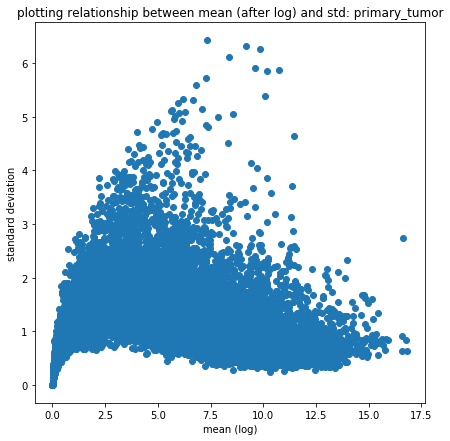

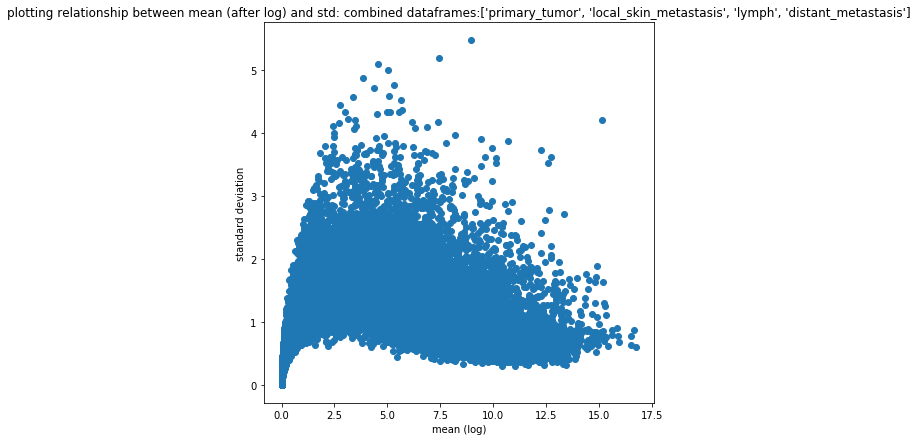

Transforming to str index.


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.001644  0.007949  0.525381  295.096551
1    A1CF.29974  0.893979  0.931751  0.139744    0.177044
2   A2BP1.54715  0.387398  0.526559  2.670516    4.772783
3   A2LD1.87769  0.042157  0.101087  0.206484  100.737661
4  A2ML1.144568  0.000076  0.000694  4.329034  255.480619

Running Rank-Sum Test:

           gene          pval          qval    log2fc        mean
0        A1BG.1  1.243063e-05  1.044633e-04  0.525381  295.096551
1    A1CF.29974  3.968551e-01  5.202993e-01  0.139744    0.177044
2   A2BP1.54715  8.207005e-01  8.769469e-01  2.670516    4.772783
3   A2LD1.87769  2.214456e-02  5.255819e-02  0.206484  100.737661
4  A2ML1.144568  4.566921e-15  4.465746e-13  4.329034  255.480619

Printing MA plot: shows log2-fold changes vs mean expression


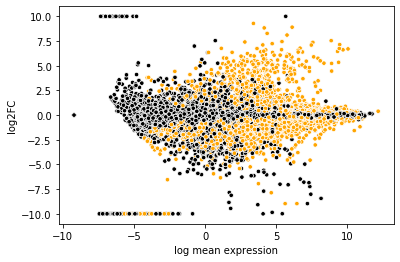


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



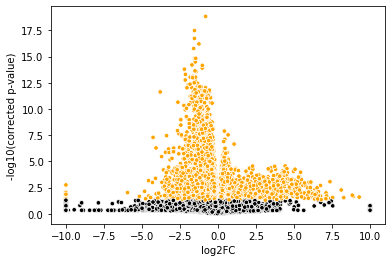

Rank-Sum test volcano plot:



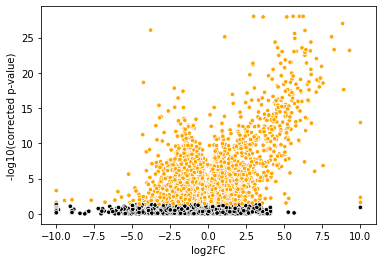

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


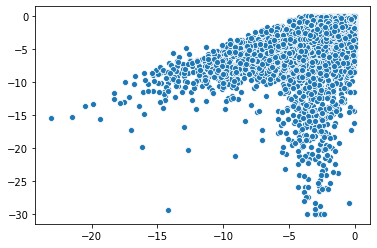


Determining which genes are highly/slightly expressed using:
p-value: 0.01 or lower
log2FoldChange: 8 or greater for highly expressed, -7 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



gene      pval      qval    log2fc        mean  zero_mean  \
4570      DEFB4A.1673  0.007151  0.025285  9.285960   29.715200      False   
8861     LCE3E.353145  0.008473  0.028871  8.271447   77.908478      False   
14575  S100A7A.338324  0.000991  0.005335  8.105805  315.307697      False   
16240     SPRR2G.6706  0.005679  0.021186  8.902770  451.948475      False   
18473   WFDC12.128488  0.004221  0.016673  8.830884   63.587896      False   

       zero_variance  
4570           False  
8861           False  
14575          False  
16240          False  
18473          False


Slightly Expressed Genes:



gene      pval      qval       log2fc      mean  \
5569       FAM138B.654412  0.000245  0.001759 -1069.642384  0.037927   
6533             GIP.2695  0.009075  0.030491 -1069.556453  0.035734   
9230     LOC154449.154449  0.004798  0.018497 -1068.686989  0.019559   
9307     LOC285375.285375  0.003599  0.014684 -1068.006142  0.012201   
9560     LOC730811.730811  0.002407  0.010732 -1067.584330  0.009108   
11687       OR11G2.390439  0.008943  0.030148 -1066.872887  0.005562   
11738       OR2A12.346525  0.001655  0.007989 -1067.668260  0.009653   
11763         OR2G3.81469  0.006784  0.024309 -1067.530834  0.008776   
11790       OR2T34.127068  0.008035  0.027701 -1067.143158  0.006708   
11837       OR4K14.122740  0.003607  0.014707 -1067.640559  0.009470   
12819        PLGLA.285189  0.007227  0.025515 -1067.393057  0.007977   
15748  SNORA38B.100124536  0.002058  0.009485 -1068.037043  0.012465   
16702        TAS2R7.50837  0.003306  0.013806 -1068.214788  0.014099   

       zero_mean  zero_variance  
5569       False          False  
6533       False          False  
9230       False          False  
9307       False          False  
9560       False          False  
11687      False          False  
11738      False          False  
11763      False          False  
11790      False          False  
11837      False          False  
12819      False          False  
15748      False          False  
16702      False          False


Rank-Sum Results:

Highly Expressed Genes:



gene          pval          qval       log2fc        mean  \
4543   DEFB108B.245911  8.215085e-03  2.314498e-02  1067.528743    0.002507   
4570       DEFB4A.1673  6.802406e-27  6.485414e-24     9.285960   29.715200   
8686         KRT9.3857  1.029960e-15  1.135219e-13    10.898171  287.819553   
8858      LCE3B.353143  8.215085e-03  2.314498e-02  1068.863119    0.006323   
8861      LCE3E.353145  5.142064e-27  5.160467e-24     8.271447   77.908478   
11850      OR4P4.81300  8.215085e-03  2.314498e-02  1068.002888    0.003483   
11939     OR5L1.219437  8.215085e-03  2.314498e-02  1067.005570    0.001745   
14575   S100A7A.338324  4.919929e-29  7.817767e-26     8.105805  315.307697   
14717   SCGB1D4.404552  8.215085e-03  2.314498e-02  1069.215766    0.008073   
16114   SPAG11A.653423  1.186403e-03  4.650971e-03  1067.747207    0.002917   
16240      SPRR2G.6706  8.291291e-21  2.359677e-18     8.902770  451.948475   
18473    WFDC12.128488  3.762638e-31  1.024942e-27     8.830884   63.587896   

       zero_mean  zero_variance  
4543       False          False  
4570       False          False  
8686       False          False  
8858       False          False  
8861       False          False  
11850      False          False  
11939      False          False  
14575      False          False  
14717      False          False  
16114      False          False  
16240      False          False  
18473      False          False


Slightly Expressed Genes:



gene      pval      qval       log2fc         mean  \
2204   C20orf70.140683  0.003694  0.011913    -7.703571    60.975330   
4157         CSN2.1447  0.004052  0.012856    -9.454609     6.035927   
5569    FAM138B.654412  0.008630  0.024154 -1069.642384     0.037927   
14713     SCGB1A1.7356  0.000084  0.000508   -11.666158    58.641106   
16407       STATH.6779  0.003030  0.010097    -8.967983  1319.978544   

       zero_mean  zero_variance  
2204       False          False  
4157       False          False  
5569       False          False  
14713      False          False  
16407      False          False


Overall highly expresed:


gene    pval_x  log2fc_x      mean_x        pval_y  \
0       DEFB4A.1673  0.007151  9.285960   29.715200  6.802406e-27   
1      LCE3E.353145  0.008473  8.271447   77.908478  5.142064e-27   
2    S100A7A.338324  0.000991  8.105805  315.307697  4.919929e-29   
3       SPRR2G.6706  0.005679  8.902770  451.948475  8.291291e-21   
4     WFDC12.128488  0.004221  8.830884   63.587896  3.762638e-31   
5   DEFB108B.245911       NaN       NaN         NaN  8.215085e-03   
6         KRT9.3857       NaN       NaN         NaN  1.029960e-15   
7      LCE3B.353143       NaN       NaN         NaN  8.215085e-03   
8       OR4P4.81300       NaN       NaN         NaN  8.215085e-03   
9      OR5L1.219437       NaN       NaN         NaN  8.215085e-03   
10   SCGB1D4.404552       NaN       NaN         NaN  8.215085e-03   
11   SPAG11A.653423       NaN       NaN         NaN  1.186403e-03   

       log2fc_y      mean_y  
0      9.285960   29.715200  
1      8.271447   77.908478  
2      8.105805  315.307697  
3      8.902770  451.948475  
4      8.830884   63.587896  
5   1067.528743    0.002507  
6     10.898171  287.819553  
7   1068.863119    0.006323  
8   1068.002888    0.003483  
9   1067.005570    0.001745  
10  1069.215766    0.008073  
11  1067.747207    0.002917


Overall slightly expresed:


gene    pval_x     log2fc_x    mean_x    pval_y  \
0       FAM138B.654412  0.000245 -1069.642384  0.037927  0.008630   
1             GIP.2695  0.009075 -1069.556453  0.035734       NaN   
2     LOC154449.154449  0.004798 -1068.686989  0.019559       NaN   
3     LOC285375.285375  0.003599 -1068.006142  0.012201       NaN   
4     LOC730811.730811  0.002407 -1067.584330  0.009108       NaN   
5        OR11G2.390439  0.008943 -1066.872887  0.005562       NaN   
6        OR2A12.346525  0.001655 -1067.668260  0.009653       NaN   
7          OR2G3.81469  0.006784 -1067.530834  0.008776       NaN   
8        OR2T34.127068  0.008035 -1067.143158  0.006708       NaN   
9        OR4K14.122740  0.003607 -1067.640559  0.009470       NaN   
10        PLGLA.285189  0.007227 -1067.393057  0.007977       NaN   
11  SNORA38B.100124536  0.002058 -1068.037043  0.012465       NaN   
12        TAS2R7.50837  0.003306 -1068.214788  0.014099       NaN   
13     C20orf70.140683       NaN          NaN       NaN  0.003694   
14           CSN2.1447       NaN          NaN       NaN  0.004052   
15        SCGB1A1.7356       NaN          NaN       NaN  0.000084   
16          STATH.6779       NaN          NaN       NaN  0.003030   

       log2fc_y       mean_y  
0  -1069.642384     0.037927  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN  
5           NaN          NaN  
6           NaN          NaN  
7           NaN          NaN  
8           NaN          NaN  
9           NaN          NaN  
10          NaN          NaN  
11          NaN          NaN  
12          NaN          NaN  
13    -7.703571    60.975330  
14    -9.454609     6.035927  
15   -11.666158    58.641106  
16    -8.967983  1319.978544

In [65]:
# Part (b) primary tumor vs (lymph, distant metastasis and local skin metastasis)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['primary_tumor', 'local_skin_metastasis', 'lymph', 'distant_metastasis'], single_df=True)

highly_expressed_genes_primary_tumor, slightly_expressed_genes_primary_tumor = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-7,
                                                                                                        log_2fc_top=8)

In [66]:
# part (c)
# finding common expressed genes
def find_common_genes(list_of_lists_of_genes, title):
    """
    This function prints a list of all the common genes in the input lists.
    """
    seen = set()
    repeated = set()
    for l in list_of_lists_of_genes:
      for i in set(l):
        if i in seen:
          repeated.add(i)
        else:
          seen.add(i)
    if repeated:
        print(f'The {title} common genes are {repeated}')
    else:
        print (f"There are no {title} common genes")

In [73]:
# Finding common higly expressed genes in local skin metastases and primary tumor

highly_express_genes_list = [highly_expressed_genes_primary_tumor['gene'], 
                             highly_expressed_local_skin['gene']]

find_common_genes(highly_express_genes_list, 'highly')

# Finding common slightly expressed genes in local skin metastases and primary tumor

slightly_express_genes_list = [slightly_expressed_genes_primary_tumor['gene'], 
                             slightly_expressed_local_skin['gene']]

find_common_genes(slightly_express_genes_list, 'slightly')

There are no highly common genes
The slightly common genes are {'LOC154449.154449', 'LOC285375.285375'}


In [74]:
# Finding common higly expressed genes in local skin metastases, distant metastases, lymph nodes

highly_express_genes_list = [highly_expressed_genes_distant['gene'], 
                             highly_expressed_local_skin['gene'],
                           highly_expressed_genes_lymph['gene']]

find_common_genes(highly_express_genes_list, 'highly')

# Finding common slightly expressed genes in local skin metastases, distant metastases, lymph nodes

slightly_express_genes_list = [slightly_expressed_genes_distant['gene'], 
                             slightly_expressed_local_skin['gene'],
                             slightly_expressed_genes_lymph['gene']]

find_common_genes(slightly_express_genes_list, 'slightly')

There are no highly common genes
The slightly common genes are {'OR4E2.26686', 'OR51B6.390058', 'SNORA5B.677795', 'OR6C68.403284', 'OCM2.4951', 'VN1R4.317703', 'DEFB4A.1673', 'BEYLA.497634', 'HPVC1.3262', 'ZCCHC13.389874', 'FAM138D.677784', 'OR2M1P.388762', 'OR52J3.119679', 'OR6C4.341418', 'OR10H3.26532'}


In [76]:
# Finding common higly expressed genes in primary tumor, local skin metastases, distant metastases, lymph nodes

highly_express_genes_list = [highly_expressed_genes_primary_tumor['gene'], 
                            highly_expressed_genes_distant['gene'], 
                             highly_expressed_local_skin['gene'],
                               highly_expressed_genes_lymph['gene']]

find_common_genes(highly_express_genes_list, 'highly')

# Finding common slightly expressed genes in primary tumor, local skin metastases, distant metastases, lymph nodes

slightly_express_genes_list = [slightly_expressed_genes_primary_tumor['gene'],
                              slightly_expressed_genes_distant['gene'], 
                             slightly_expressed_local_skin['gene'],
                             slightly_expressed_genes_lymph['gene']]

find_common_genes(slightly_express_genes_list, 'slightly')

column='log2fc_x'
ax = slightly_expressed_genes_primary_tumor.plot.scatter(x='gene', y=column, color='blue', label='primary')
ax = slightly_expressed_genes_distant.plot.scatter(x='gene', y=column, ax=ax, color='red', label='distant')
ax = slightly_expressed_genes_lymph.plot.scatter(x='gene', y=column, ax=ax, color='green', label='lymph')
ax = slightly_expressed_local_skin.plot.scatter(x='gene', y=column, ax=ax, color='yellow', label='local skin')
ax.legend()


There are no highly common genes
The slightly common genes are {'OR4E2.26686', 'OR51B6.390058', 'SNORA5B.677795', 'OR6C68.403284', 'OR4K14.122740', 'OCM2.4951', 'VN1R4.317703', 'DEFB4A.1673', 'BEYLA.497634', 'HPVC1.3262', 'LOC285375.285375', 'ZCCHC13.389874', 'FAM138D.677784', 'OR2T34.127068', 'OR2M1P.388762', 'LOC154449.154449', 'OR52J3.119679', 'OR6C4.341418', 'OR10H3.26532'}


ValueError: scatter requires x column to be numeric

In [ ]:
# Running  the analysis
# Part (a) miRNAn:
divide_damples_by_organs(dataframe_name='micro_rna_data', column_name='micro_rna')

In [ ]:
# Part (b) primary tumor vs (lymph, distant metastasis and local skin metastasis)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['primary_tumor', 'local_skin_metastasis', 'lymph', 'distant_metastasis'], single_df=True)

highly_expressed_genes_primary_tumor, slightly_expressed_genes_primary_tumor = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-2,
                                                                                                        log_2fc_top=2)

In [ ]:
# Part (b) lymph vs (local skin metastasis, distant metastasis and primary tumor)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['lymph', 'local_skin_metastasis', 'primary_tumor', 'distant_metastasis'], single_df=True)

highly_expressed_genes_lymph, slightly_expressed_genes_lymph = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-1.2,
                                                                                                        log_2fc_top=1,
                                                                                                        p_value=0.015)

In [ ]:
# Part (b) local skin metastasis vs (lymph, distant metastasis and primary tumor)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['local_skin_metastasis', 'lymph', 'primary_tumor', 'distant_metastasis'], single_df=True)

highly_expressed_local_skin, slightly_expressed_local_skin = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-2.5,
                                                                                                        log_2fc_top=1, 
                                                                                                         p_value=0.02)

In [ ]:
# Part (b) distant metastasis vs (local skin metastasis, lymph and primary tumor)

data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['distant_metastasis', 'local_skin_metastasis', 'primary_tumor', 'lymph'], single_df=True)

highly_expressed_genes_distant, slightly_expressed_genes_distant = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        log2fc_bottom=-1.5,
                                                                                                        log_2fc_top=1.5,
                                                                                                         p_value=0.02)

In [ ]:
# part (c)
# finding common expressed genes

In [ ]:
# Finding common higly expressed genes in local skin metastases and primary tumor

highly_express_genes_list = [highly_expressed_genes_primary_tumor['gene'], 
                             highly_expressed_local_skin['gene']]

find_common_genes(highly_express_genes_list, 'highly')

# Finding common slightly expressed genes in local skin metastases and primary tumor

slightly_express_genes_list = [slightly_expressed_genes_primary_tumor['gene'], 
                             slightly_expressed_local_skin['gene']]

find_common_genes(slightly_express_genes_list, 'slightly')

In [ ]:
# Finding common higly expressed genes in local skin metastases, distant metastases, lymph nodes

highly_express_genes_list = [highly_expressed_genes_distant['gene'], 
                             highly_expressed_local_skin['gene'],
                           highly_expressed_genes_lymph['gene']]

find_common_genes(highly_express_genes_list, 'highly')

# Finding common slightly expressed genes in local skin metastases, distant metastases, lymph nodes

slightly_express_genes_list = [slightly_expressed_genes_distant['gene'], 
                             slightly_expressed_local_skin['gene'],
                             slightly_expressed_genes_lymph['gene']]

find_common_genes(slightly_express_genes_list, 'slightly')

In [ ]:
# Finding common higly expressed genes in primary tumor, local skin metastases, distant metastases, lymph nodes

highly_express_genes_list = [highly_expressed_genes_primary_tumor['gene'], 
                            highly_expressed_genes_distant['gene'], 
                             highly_expressed_local_skin['gene'],
                               highly_expressed_genes_lymph['gene']]

find_common_genes(highly_express_genes_list, 'highly')

# Finding common slightly expressed genes in primary tumor, local skin metastases, distant metastases, lymph nodes

slightly_express_genes_list = [slightly_expressed_genes_primary_tumor['gene'],
                              slightly_expressed_genes_distant['gene'], 
                             slightly_expressed_local_skin['gene'],
                             slightly_expressed_genes_lymph['gene']]

find_common_genes(slightly_express_genes_list, 'slightly')

column='pval_x'
ax = slightly_expressed_genes_primary_tumor.plot.scatter(x='gene', y=column, color='blue', label='primary')
ax = slightly_expressed_genes_distant.plot.scatter(x='gene', y=column, ax=ax, color='red', label='distant')
ax = slightly_expressed_genes_lymph.plot.scatter(x='gene', y=column, ax=ax, color='green', label='lymph')
ax = slightly_expressed_local_skin.plot.scatter(x='gene', y=column, ax=ax, color='yellow', label='local skin')
ax.legend()

  
<u>Question # 3</u> 
- see attached document

Research Questions and Analysis Methodology:

<u>Question # 4</u>

**Question: Which genes have a higher expression in tumors vs healthy skin? Are these genes similar to genes more highly expressed in metastases vs primary tumors?**

**Defining highly-expressed genes**

1. <u>Differential Gene Expression (DGE) Analysis</u>: (see description in "Methods")
    - **This analysis is designed to be performed on counts (expression), not normalized data!**
    - We selected to use 2 different methods for DGE Analysis:
        1. **Welch's t-tests**
        2. **Rank Sum tests**   
    - To determine if a gene has been significantly expressed, we will use in this section:
        - **P-value < 0.01** 
        - **log2FoldChange:** +/- 7.5 (the usual boundary is +/-2)
    - However, these tests are unfortunately not enough to deal with our data because we received gtex_data already partially normalized


2. <u>Our Version of Gene Expression Analysis</u>:
   - <u>why do we need this when we can use DGE analysis?</u>   
        - Most methods use a counts matrix that has not been normalized and perform calculations based on it. In the case of TCGA data, we have these counts matrix available. However, gtex data is a dataset we already received partially normalized (genes have a mean of zero). **Tests based on means cannot work for gtex data, because all of our means are zero**.
        - We read that to the actual count numbers in the gene expression dataset and the numbers that are the basis for the gtex dataset are derived by different methods, so one number cannot actually be compared to another directly.
        
   - <u>For these reasons, we also defined our own definition of highly-expressed genes, using our normalized datasets:</u> 
        - Per gene per dataset, we have a gene expression value per sample, but want to define a single gene expression value to use to represent that gene (so that we can compare all values and find large ones to be highly expressed)
        - We will use **median gene expression** per gene
            - The normalization affects the values, but medians per gene can have a range of values
            - We arbitrarily selected to look at genes with median values in the 99.9th percentile, but defined this as a parameter, and other values can also be examined
            - Per group of samples, we will select the genes with 99.9th percentile of highest median expression as "highly expressed" for that group
        
    
***Analysis Description:*** <br />
<u>Perform Differential Gene Expression (DGE) Analysis for Metastases Samples vs Primary Samples</u>:<br />
- Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe. As part of this process:
    1. Divide dataframe into a primary-samples-only dataframe and a metastases-samples-only-dataframe
    2. Plot the relationship between mean and std for the full dataframe, primary dataframe, metastases dataframe
    3. Transpose full dataframe to get a matrix where samples are rows, dimensions (genes/miRNA) for columns 
    4. Create a sample types dataset, where the condition is defined as: if metastasis sample: 1, otherwise 0
    5. Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
- Perform differential expression analysis
    1. Run 2 types of tests on the data: Welch's t-test and rank sum test
    2. Display an MA plot (this should be used to help define limits used to limit log2foldchange for high, low expression)
    3. Graph volcano plots based on both tests to help differentiate significant values
    4. Plot a comparison of both tests
    5. Create a dataset of highly expressed genes/miRNAs and slightly expressed genes/miRNAs using 
        pvalue=0.01
        log2foldchange: lower than -7.5 for slightly expressed, higher than 7.5 for highly expressed
    6. merge all highly expressed genes into one dataframe, slightly expressed genes into one dataframe
    7. return highly expressed and slightly expressed dataframes

<u>Prep GTEX Data for Analysis</u>: <br />
- We had to match ensemble_ids in the gtex_data dataset, that contains healthy people skin samples, to 'genes' in the gene_data dataset <br />
    1. We researched the various types of gene IDs that exist, in order to understand which IDs we are actually looking at and need to translate between, because there are numerous gene id versions. According to our research: <br />
        - our gtex dataset uses enemble_ids, also referred to as: "gene stable id" <br />
        - our gene expression dataset uses a combination of "gene name" and "NCBI gene id", separated by a period  <br />
    2. We searched for methods for converting between these genes ids, and found several options: <br />
        - packages available only in R
        - an online conversion interface, http://www.ensembl.org/biomart/martview/
        - an online conversion interface, https://mygene.info/demo (we used it, but it had many missing translations)
    3. Eventually we managed to convert the most IDs using http://www.ensembl.org/biomart/martview/, so we selected that method, with the following parameters: <br />
        - FILTERS:  
            - GENE: Input external references ID list [Max 500 advised]: "Gene stable ID(s) 
        - ATTRIBUTES:
            - GENE: Ensembl: "Gene stable ID", "Gene name"
            - EXTERNAL: External References: NCBI Gene ID        
    4. Dealing with interface limitations: the interface can translate a maximum of 500 gene IDs at a time, therefore we divided the ensemble_ids in gtex_data into sub-datasets of 500 ids or less <br />
        - gtex_data contains 16593 ensemble_ids, so the dataset had to be divided int 34 datasets
        - each file was uploaded to the interface, and the results were saved in 34 text files called "mart_export (#).txt" 
        - the 34 result text files were combined into a single conversions dataset
        - a gene column was added to the conversions dataset, created using: "gene name"."NCBI gene id" where "NCBI gene id" was available, and "gene name" only where it was not available.
    5. The new conversions 'gene' column was merged into the gtex_data dataset
    6. Gtex_data was merged with the 'gene' column of gene_data, to examine the genes that could be matched
        - it is important to note that gene_data contains only genes that have high variance, because we removed all genes that had low variance values as part of the normalization and data cleaning process
    7. Only matched genes (a total of 5181 genes) were left in the gtex dataset


<u>Our Version of Gene Expression Analysis</u>:<br /> 
- Finding most highly expressed genes in metastases vs primary samples:<br />
    - We divided the gene expression dataset into a primary tumor dataset (01 samples) and a metastases dataset (06 samples)
    - We calculated the median value per gene (according to all samples in the group)
    - We graphed the median gene expression by sample type (primary/metastasis) to help select a cutoff line
    - We defined a cutoff line at gene expression medians in the  99.9 percentile (this percentile was arbitrarily selected, based on graphing, but it is a parameter that can be changed in the analysis)
    - We created a dataset for 01 samples and 06 samples that contains only genes with median values equal or greater than the 99.9th percentile value, and combined these results into one single dataset (highly_expressed_06_vs_01)
    
- compare to healthy skin to tumor sample <br />
    - We could not directly compare gene expression values in gene_data to the numbers in the gtex_data dataset, even for matching genes, because according to our research, the numbers are obtained through different processes before they are normalized
    - Per dataset (gtex_data, gene_data (all samples, 01 and 06 combined)) we calculated the median value per gene according to all relevant samples
    - We defined a cutoff line at medians in the  99.9 percentile
    - We created a dataset for gtex samples and tumor samples that contains only genes with median values equal or greater than the 99.9th percentile value, and combined these results into one single dataset (highly_expressed_gtex_vs_cancer)
    
- We created a combined dataset for highly-expressed genes in all datasets: highly_expressed_comparison (by combining highly_expressed_gtex_vs_cancer and highly_expressed_06_vs_01), and also graphed the dataset. <br />

***Conclusion:*** <br />

- Unfortunately, we could not use only differential gene expression analysis to get results for this question ecause the gtex data we received is already with zero means. 
- When we obtain highly-expressed genes for metastases vs primary with DGE and highly-expressed genes for cancer vs healthy skin in the different method we devised, there are no gene similarities. 
- However, if we use the method we created to analyze both cancer vs healthy skin and metastasis vs primary, we find similarities in some of our resulting genes:
    - We see that out of 11 genes that have a high expression in tumors, 7 (64%) are also highly expressed in metastases. These genes are: CSAG1.158511, MAGEA12.4111, MAGEA3.4102, MAGEA2.4101, CSAG3.389903, MAGEA6.4105, RPS28.6234
    - We see that out of 5 highly expressed genes in healthy skin, 1 gene (20%) is also highly expressed in metastases: RPS4Y1.6192



<u> Part 1: Differential Gene Expression Analysis For Metastases vs Primary Tumor </u>

In [ ]:
# differential expression analysis using diffxpy 
# (installation instructions: https://github.com/theislab/diffxpy/blob/master/docs/installation.rst)

# import relevant packagees
import anndata
import logging
import scipy.stats
import batchglm
import diffxpy.api as de


# titles is a list of 3 titles to be used for log_and_plot graphs (in order)
# axis_name should either be 'gene' or 'miRNA', depending on the dataframe
"""
Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe
As part of this process:
1. Divide dataframe into a primary-samples-only dataframe and a metastases-samples-only-dataframe
2. Plot the relationship between mean and std for the full dataframe, primary dataframe, metastases dataframe
3. Transpose full datafrane to get a matrix where samples are rows, dimensions (genes/miRNA) for columns 
4. Create a sample types dataset, where the condition is defined as: if metastases sample: 1, otherwise 0
5. Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
"""
def create_data_to_find_highly_and_slightly_expressed(dataframe_name, titles, axis_name):
    
    """
    divide not_normalized_dataframes[dataframe_name] into 
    - a dataset for primary samples (df_01)
    - a dataset for metastases samples (df_06)
    """
    
    # create dataset for primary samples (df_01)
    df_01 = pd.concat(
                [not_normalized_dataframes[dataframe_name][axis_name], 
                not_normalized_dataframes[dataframe_name].filter(like='.01',axis=1)], 
                axis=1, 
                sort=False)

    # create dataset for metastases samples (df_06)
    df_06 = pd.concat(
                [not_normalized_dataframes[dataframe_name][axis_name], 
                not_normalized_dataframes[dataframe_name].filter(like='.06',axis=1)], 
                axis=1, 
                sort=False)
    
    
    """
    per non-normalized dataframe, plot the relationship between mean and std
    """
    
    print("Graphing relationship between dataframe mean and std (after log2):\n")
    
    print("Full dataframe:")
    log_and_plot(not_normalized_dataframes[dataframe_name], axis_name, titles[0])
    
    print("Partial dataframe: primary tumor samples only:")
    log_and_plot(df_01, axis_name, titles[1])
    
    print("Partial dataframe: metastases samples only:")
    log_and_plot(df_06, axis_name, titles[2])    
    
    
    """
    transpose data to get a matrix of samples for rows, dimensions (genes) for columns (same function as Q1)
    """
    
    def transform_data(dataframe):
        a = dataframe.T
        a.columns = a.iloc[0]
        a = a.iloc[1:, :]
        X = a.to_numpy()  # convert a to numpy array (no row, column names) because algos we will use need this
        return a, X

    
    """
    per sample, create a dataset that describes the sample types
    
    ** condition definition ** : 1 for metastases, 0 for primary (because of the semantics of the question)

    example:

    if this is our original dataframe:
            sample1_01  sample2_01  sample3_06
    gene_a       x           y          z
    gene_b       a           b          c
    ...
    gene_n       f           g          h


    then this is our sample types dataset:
    # if 1 means metastases and 0 means not metastases --> primary:
    # the batch is needed because the data is accepted in this format
            condition   batch
    sample1     0         0
    sample2     0         0
    sample3     1         0

    """
    
    def create_sample_description_dataset(dataframe):
        sample_descriptions = pd.DataFrame([0 if x[-2:] == '01' else 1 for x in list(dataframe.index)])
        sample_descriptions['batch'] = 0
        sample_descriptions.columns = ['condition', 'batch']
        return sample_descriptions

    a, X = transform_data(not_normalized_dataframes[dataframe_name])
    sample_descriptions = create_sample_description_dataset(a)

    
    """
    create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels
    """
    
    data = anndata.AnnData(
        X=X,
        var=pd.DataFrame(index=list(a.columns)), #labels: genes or miRNA
        obs=sample_descriptions
    )

    return data


"""
    Perform differential expression analysis
    1. Run 2 types of tests on the data: Welch's t-test and rank sum test
    2. Display an MA plot (this should be used to define the values of top, bottom)
    3. Graph volcano plots based on both tests to help differentiate significant values
    4. Plot a comparison of both tests
    5. Create a dataset of highly expressed genes/miRNAs and slightly expressed genes/miRNAs using 
        pvalue=0.01
        log2foldchange: lower than bottom for slightly expressed, higher than top for highly expressed
    6. merge all highly expressed genes into one dataframe, slightly expressed genes into one dataframe
    7. return highly expressed and slightly expressed dataframes
"""

def differential_expression_analysis(data, axis_name, bottom=-7.5, top=7.5, pval=0.01):
    
    """
    Running differential expression tests:
    
    1. Welch's t-test
    2. Rank sum test
    
    For t-tests and rank sum tests, the grouping argument indicates the the name of the relevant condition column 
    in the sample description
    """
    
    print("Performing differential expression tests and displaying sample results\n")
    
    print("Running Welch's T-Test:\n")
    
    # Welch's t-test
    test_tt = de.test.t_test(
        data=data,
        grouping="condition")
    
    # this model is built for analyzing genes, we want to change the 'gene' column to miRNA if necessary
    res_tt = test_tt.summary()
    res_tt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    print(res_tt.iloc[:5, :-2])
    
    
    print("\nRunning Rank-Sum Test:\n")
    # Rank sum test
    test_rank = de.test.rank_test(
        data=data,
        grouping="condition"
    )
    
    # this model is built for analyzing genes, we want to change the 'gene' column to miRNA if necessary
    res_rt = test_rank.summary()
    res_rt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    print(res_rt.iloc[:5, :-2])    
    
    
    """
    MA Plot
    An MA-plot is a 2D plot that shows the log2-fold change vs mean expression
    """
    print("\nPrinting MA plot: shows log2-fold changes vs mean expression")
    test_tt.plot_ma()

        
    """
    Volcano Plot
    A volcano plot is a 2D scatter plot shaped like a volcano
    It is used to show statistically significant gene expression changes from two different conditions
    It displays log fold change vs p-value

    """
    print("\nGraphing volcano plot: shows log fold change vs p-value\n")
    
    print("T-Test volcano plot:\n")
    test_tt.plot_volcano()

    print("Rank-Sum test volcano plot:\n")
    test_rank.plot_volcano()
   

    """
    Scatter plot of log10_pval for t-test vs log10_pval for rank sum test:
    """
    
    print("Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)")
    # compare 2 results
    sns.scatterplot(x=test_tt.log10_pval_clean(), y=test_rank.log10_pval_clean())
    plt.show()
    
    
    """
    Returning Highly and Slightly Expressed Genes
    To determine if a gene has been significantly expressed, we use:
    1. P-value: 0.01
    2. log2FoldChange: we add as a parameter to the function. 
        we read that fold-change of +/- 2 is often used as the threshold for defining significant differential 
        expression, therefore we will use a minimum of log fold-change +2 to define highly-expressed genes and
        a maximum of -2 to define slightly expressed genes. However, we will select actual values to use by 
        examining an MA-Plot and seeing outlying values graphically.     
    """
    
    print("\nDetermining which {}s are highly/slightly expressed using:".format(axis_name))
    print("p-value: 0.01 or lower")
    print("log2FoldChange: {} or greater for highly expressed, {} or lower for slightly expressed".format(top, bottom))

    # defining highly-expressed genes based on t-test
    highly_expressed_tt = test_tt.summary()
    highly_expressed_tt = highly_expressed_tt[(highly_expressed_tt.pval < pval) & (highly_expressed_tt.log2fc >= top)]
    
    # defining slightly-expressed genes based on t-test
    slightly_expressed_tt = test_tt.summary()
    slightly_expressed_tt = slightly_expressed_tt[
                                                (slightly_expressed_tt.pval < pval) & 
                                                (slightly_expressed_tt.log2fc <= bottom)]
    
    
    # this model is built for analyzing genes, we want to change the 'gene' to miRNA if necessary
    highly_expressed_tt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    slightly_expressed_tt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    
    print("\nT-Test Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_tt)
    
    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_tt)
    
    # defining highly-expressed genes based on rank-sum test
    highly_expressed_rt = test_rank.summary()
    highly_expressed_rt = highly_expressed_rt[(highly_expressed_rt.pval < pval) & (highly_expressed_rt.log2fc >= top)]

    # defining slightly-expressed genes based on t-test
    slightly_expressed_rt = test_rank.summary()
    slightly_expressed_rt = slightly_expressed_rt[
                                                (slightly_expressed_rt.pval < pval) &
                                                (slightly_expressed_rt.log2fc <= bottom)]
    
    
    # this model is built for analyzing genes, we want to change the 'gene' column to miRNA if necessary
    highly_expressed_rt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    slightly_expressed_rt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    
    print("\nRank-Sum Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_rt)
    
    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_rt)

    # combine hightly-expressed dataframes
    highly_expressed = pd.merge(
                            highly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']] , 
                            highly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']], 
                            on=axis_name, 
                            how='outer')

    slightly_expressed = pd.merge(
                            slightly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']] , 
                            slightly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']], 
                            on=axis_name, 
                            how='outer')
    
    print("\nOverall highly expresed:")
    display(highly_expressed)
    print("\nOverall slightly expresed:")
    display(slightly_expressed)
    
    return highly_expressed, slightly_expressed


In [ ]:
# prep gene expression data for differential expression analysis and graph log mean vs std

titles = ['Gene Expression Data (All)', 'Gene Expression Data (Primary Only)', 'Gene Expression Data (Metastases Only)']
data_genes = create_data_to_find_highly_and_slightly_expressed('gene_data', titles, 'gene')


In [ ]:
# perform differential expression analysis and find hgihly/slightly expressed genes

highly_expressed_genes_06_vs_01, slightly_expressed_genes_06_vs_01 = differential_expression_analysis(data_genes,
                                                                                                      'gene')


<u> Part 2: Our Version of Gene Expression Analysis For Heathly Skin vs Tumors </u>

In [ ]:
# pass 'mean' or 'median' as mean_or_median
def plot_highly_expressed_genes(data, mean_or_median, title_additions):           
    plt.figure(figsize=(10, 10))
    plt.title('{} gene expression {}'.format(mean_or_median, title_additions))
    sns.barplot(x = data['gene'], y = data['{}_exp'.format(mean_or_median)])
    plt.xlabel("highly expressed genes {}".format(title_additions))
    plt.xticks(rotation=90)
    plt.ylabel("{} gene expression value after normalizing".format(mean_or_median))

    
def find_highly_expressed_medians(data, quantile, title_additions):
    # creade a dataset of gene name, median gene expression per gene based on given data
    medians = pd.concat([data['gene'], data.iloc[:, 1:].median(axis=1)], axis=1, sort=False)
    medians.columns = ['gene', 'median_exp']
    
    # sort new dataset by median gene expression (high to low), this is used for making a pretty graph
    medians = medians.sort_values(by = 'median_exp', ascending=False)
    
    # we want to define the top quantile-th percentile of values
    medians_limit = round(medians['median_exp'].quantile(quantile), 2)
    print("medians ", quantile*100, "-th percentile value: ", medians_limit)

    # keep only values greater or equal to limit
    highly_expressed_medians = medians[medians['median_exp'] >= medians_limit]
    
    # graph results
    plot_highly_expressed_genes(highly_expressed_medians, 'median', title_additions)
    
    highly_expressed_medians.columns = ['gene', 'median_exp']
    return medians, highly_expressed_medians


def combine_highly_expressed_datasets(highly_expressed_data_1, highly_expressed_data_2, name_data_1, name_data_2):
    if name_data_1 is not None and name_data_2 is not None:
        highly_expressed_data_1.columns = ['gene', 'median_exp_{}'.format(name_data_1)]
        highly_expressed_data_2.columns = ['gene', 'median_exp_{}'.format(name_data_2)]
    return pd.merge(highly_expressed_data_1, highly_expressed_data_2, on='gene', how='outer')


# pass 'mean' or 'median' as mean_or_median
def plot_mean_or_median_gene_expression(mean_or_median, data, ylabel_additions):
    #plotting means of genes exp (this is a subset of data we previously normalized)
    plt.figure(figsize=(10, 10))
    plt.title("{} gene expression by gene".format(mean_or_median))
    sns.barplot(x = data['gene'], y = data['{}_exp'.format(mean_or_median)]) #this takes a long time
    plt.xlabel("gene")
    plt.ylabel("{} gene expression value {}".format(mean_or_median, ylabel_additions))

Match GTEX ensemble_id with gene expression gene ids:

   1. clean data
   2. export ensemble ids in batches small enough for inputing into http://www.ensembl.org/biomart/martview/ -> max 500, resulting in exported 34 files
   3. enter http://www.ensembl.org/biomart/martview/
       FILTERS:  
       - GENE: Input external references ID list [Max 500 advised]: "Gene stable ID(s) 
       ATTRIBUTES:
       - GENE: Ensembl: "Gene stable ID", "Gene name"
       - EXTERNAL: External References: NCBI Gene ID
       Results were saved in 34 text files called "mart_export (#).txt"
   4. Importing results and combine them into one df (conversions)
   5. Creating a 'gene' column using 'Gene name'.'NCBI gene ID'
   6. Merging into gtex data only genes with names that were also found in gene expression data
   7. Drop unecessary columns (used for matching and merging), and re-order columns

In [ ]:
# clean gtex_data dataframe


# remove quotations from ensemble_id (the dataset has each ensemble_id enveloped by quotations)
def remove_quotations(row):
    row.ensemble_id = row.ensemble_id.strip('"')
    return row

dataframes['gtex_data'] = dataframes['gtex_data'].apply(remove_quotations, axis = 'columns')

In [ ]:
# export ensemble ids in batches small enough for inputing into http://www.ensembl.org/biomart/martview/ -> max 500


# divide gtex_data's ensemble ids into sections of 500 genes or less, so we need 34 datasets of 500 genes
ensemble_dfs = {}

data = dataframes['gtex_data']['ensemble_id']
for x in range(34):
    df = pd.DataFrame()
    df = data[:500]
    ensemble_dfs[x] = df
    data = data[500:]

# export values to CSV
for x in range(34):
    ensemble_dfs[x].to_csv('{}.csv'.format(x), index=False)

In [ ]:
# importing results and combining them into one df

names = ['ensemble_id' , 'Gene name', 'NCBI gene ID']
conversions = pd.read_csv('mart_export (0).txt', names=names, skiprows=1, sep=",")

for x in range(1, 34):
    df = pd.read_csv('mart_export ({}).txt'.format(x), names=names, skiprows=1, sep=",")
    conversions = pd.concat([conversions, df], axis=0, sort=False).reset_index(drop=True)


print("shape: ", conversions.shape)
display(conversions.head())

In [ ]:
import math

def create_gene_name(row):
    ncbi_gene_id = float(row['NCBI gene ID'])
    if not math.isnan(ncbi_gene_id):
        ncbi_gene_id = str(int(ncbi_gene_id))
        row.gene = row['Gene name'] + "." + ncbi_gene_id
    else:
        row.gene = row['Gene name']
    return row

# in order for apply to work, the column ['gene'] should already exist in dataframe
conversions['gene'] = np.nan

# update conversions to include a row of "Gene name"."NCBI gene ID", they both exist
conversions = conversions.apply(create_gene_name, axis = 'columns')

In [ ]:
# merging

dataframes['gtex_data'] = pd.merge(
                                dataframes['gtex_data'], 
                                conversions[['ensemble_id', 'gene']], 
                                on='ensemble_id', 
                                how='left')

# trying to match rows from dataframes['gene_data']
dataframes['gene_data']['gene2'] = dataframes['gene_data']['gene']

m = pd.merge(
        dataframes['gtex_data'], 
        dataframes['gene_data'][['gene', 'gene2']], 
        on='gene', 
        how='inner')


In [ ]:
# We managed to match only 5181 genes (this is not terrible, taking into account gene expression data removed many genes)
# we'll preform the analysis with only matched genes


# comparing only matched genes
dataframes['gtex_data'] = m
dataframes['gtex_data'].head()
dataframes['gtex_data'] = dataframes['gtex_data'].drop(columns=['ensemble_id', 'gene2'])


# reorder columns for gtex_data
cols = list(dataframes['gtex_data'].columns)
cols = [cols[-1]] + [x for x in cols[:-1]]
dataframes['gtex_data']  = dataframes['gtex_data'][cols]

dataframes['gtex_data'].head()

In [ ]:
print("Highly Expressed Genes: GTEX ")
df_gtex, highly_expressed_medians_gtex = find_highly_expressed_medians(dataframes['gtex_data'], 0.999, "(gtex)")

In [ ]:
print("Highly Expressed Genes: Tumors(primary/metastases) ")
df_cancer, highly_expressed_medians_cancer = find_highly_expressed_medians(dataframes['gene_data'], 0.999, "(melanoma gene expression)")

In [ ]:
highly_expressed_gtex_vs_cancer = combine_highly_expressed_datasets(
                                                                highly_expressed_medians_gtex, 
                                                                highly_expressed_medians_cancer, 
                                                                'gtex', 
                                                                'tumor')

highly_expressed_gtex_vs_cancer

Option 1 Results

In [ ]:
highly_expressed_v1 = pd.merge(
        highly_expressed_genes_06_vs_01[['gene', 'mean_x', 'mean_y']], 
        highly_expressed_gtex_vs_cancer, 
        on='gene', 
        how='outer')

highly_expressed_v1

Option 2 Results

In [ ]:
# We will try to use the same method we invented to analyze gene expression data for 01, 06 separately

df_01 = pd.concat(
                [dataframes['gene_data']['gene'], 
                dataframes['gene_data'].filter(like='.01',axis=1)], 
                axis=1, 
                sort=False)

# create dataset for metastases samples (df_06)
df_06 = pd.concat(
                [dataframes['gene_data']['gene'], 
                dataframes['gene_data'].filter(like='.06',axis=1)], 
                axis=1, 
                sort=False)

print("Highly Expressed Genes: Primary Tumor")
df_01, highly_expressed_medians_01 = find_highly_expressed_medians(df_01, 0.999, "(primary)")

print("Highly Expressed Genes: Metastases")
df_06, highly_expressed_medians_06 = find_highly_expressed_medians(df_06, 0.999, "(metastases)")


# combining resulting dataframes
highly_expressed_06_vs_01_v2 = combine_highly_expressed_datasets(
                                                        highly_expressed_medians_01, 
                                                        highly_expressed_medians_06, 
                                                        '01', 
                                                        '06')


# compare highly_expressed_gtex_vs_cancer with highly_expressed_06_vs_01_v2

highly_expressed_comparison = combine_highly_expressed_datasets(
                                                        highly_expressed_gtex_vs_cancer, 
                                                        highly_expressed_06_vs_01_v2, 
                                                        None, 
                                                        None)


In [ ]:
print("Compare Highly Expressed Genes for: gtex data, tumor data, only primary tumor data (01), only metastases (06)\n")
print("A gene is considered highly expressed if the median of its samples is in the 99.9th percentile of values in that dataset")
display(highly_expressed_comparison)


# create a categorical graph of the results
print("\nDisplay a categorical graph of these results:")
fig, ax1 = plt.subplots(figsize=(25, 7))
tidy = pd.melt(highly_expressed_comparison, id_vars=['gene'])
sns.barplot(x='gene', y='value', hue='variable', data=tidy, ax=ax1, palette="rocket")
sns.despine(fig)
plt.xticks( rotation=90)
plt.show()


Research Questions and Analysis Methodology:

<u>Question # 5</u>

**Question: There are miRNAs for which we know what genes expressions they affect. Are miRNAs that act differently between primary tumors and metastases known to be responsible for genes expressed differently between primary tumors and metastases? To answer this question, we should use external DBs that map known relationships between miRNA and genes, such as http://www.mirdb.org/faq.html**<br />

**Analysis Description:**<br />
1. Perform differential expression analysis for non-normalized micro rna data, and return highly and slightly expressed gene lists (using functions defined in Q4)<br />
2. Display results from highly/slightly_expressed_genes_06_vs_01 found in Q4, vs results for micro_rna
3. Check http://www.mirdb.org/faq.html to determine:
   - if highly expressed genes are known to be related to highly expressed mRNA<br />
   - if slightly expressed genes are known to be related to slightly expressed mRNA<br />
4. Section 3 should be done by searching for relevant gene symbol, and then relevant gene NCBI ids in the db. One of these is not enough because in some cases there is a mis-match in the TCGA gene id format (see conclusion)
   
**Conclusion**<br />
- We found very few relevant relationships:<br />
   - The only known relationship found between highly expressed genes and highly expressed mRNA was between <u>CSN2</u> and hsa-miR-153-5p (while hsa-miR-153-2 was in our list). We found an additional relationship between a highly-expressed gene and a slightly-expressed miRNA: <u>SCGB1A1</u> and hsa-miR-203a-5p (while hsa-miR-203 was a slightly-expressed miRNA in our list).
   - the only known relationship found between slightly expressed genes and slightly expressed mRNA was between <u>S100A7A</u> and hsa-miR-203a-3p (while hsa-miR-203 was in our list)
- We can point to several possible explanations:<br />
    - We defined "highly/slightly" expressed genes/miRNA using arbitrary choices for pvalues/logfoldchanges that we selected based on MA plots and in order not to get **many** results, in our opinion. Changing these arbitrary limits would have resulted in far more highly/slightly expressed results, and thus might have increased the number of relationships we would have found
    - Not all genes in our results were found mapped in mirdb. This could be because they have no known mapping, and could also be a result of a mix-up in gene id formatting. While most gene names in the TCGA dataset are formatted by placing "gene name/symbol"."NCBI gene id", we have found several genes that seem to have different formats. Many genes we searched for were missing, and maybe this has to do with name formatting
    - We both don't know biology, so had a difficulty in understanding how miRNA/genes we found with similar names to miRNA/genes in our list are actually similar...

In [ ]:
# Find miRNA that act differently between primary and metastases using differential expression analysis

# prep miRNA data for differential expression analysis and graph log mean vs std
titles = ['miRNA Data (All)', 'miRNA Data (Primary Only)', 'miRNA Data (Metastases Only)']
data_mirna = create_data_to_find_highly_and_slightly_expressed('micro_rna_data', titles, 'micro_rna')



In [ ]:
# perform differential expression analysis and find hgihly/slightly expressed mirna

highly_expressed_mirna_06_vs_01, slightly_expressed_mirna_06_vs_01 = differential_expression_analysis(data_mirna, 
                                                                                                      'micro_rna', 
                                                                                                      -2, 
                                                                                                      2)


In [ ]:
# we need to change micro rna names to a format which matches the format hsa-miR-124-3p (used in http://www.mirdb.org)

highly_expressed_mirna_06_vs_01['micro_rna'] = pd.Series(highly_expressed_mirna_06_vs_01['micro_rna']).str.replace('.', '-', regex=True).str.replace('mir', 'miR', regex=True)
slightly_expressed_mirna_06_vs_01['micro_rna'] = pd.Series(slightly_expressed_mirna_06_vs_01['micro_rna']).str.replace('.', '-', regex=True).str.replace('mir', 'miR', regex=True)



In [ ]:
# after finding genes and miRNA that act differently between primary and metastases samples, display highly expressed

print("Highly Expressed Genes Metastases vs Primary (Q4 Result)")
display(highly_expressed_genes_06_vs_01)

print("\nHighly Expressed miRNA Metastases vs Primary")
display(highly_expressed_mirna_06_vs_01)


We used the website http://www.mirdb.org/faq.html to examine the relationship between the resulting miRNA and the resulting genes

**Highly expressed results:**
- by gene symbol found in mirdb:
    - CSN2 (casein beta) - a relationshp with hsa-miR-153-5p has been found with a target rank of 19 and a target score of 81 (while hsa-miR-153-2 is in our list and seems similar though not exactly identical)
    - SCGB1A1 (secretoglobin family 1A member 1) - a relationship with hsa-miR-203a-5p has been found with a target rank of 6 and a target score of 56 (while hsa-miR-203 is a **slightly-expressed** mRNA in our next list)
    - GIP - no relationship in found between our 2 lists
    - STATH - no relationship in found between our 2 lists
- by ncdbi ids found in mirdb (cases where the relevant gene symbol was not found)
    - 140683 -> no relationship in found between our 2 lists
    
    
* we are adding a disclaimer here that we both don't actually know biology so we don't know how similar/different these almost-matches actually are...

In [ ]:
# after finding genes and miRNA that act differently between primary and metastases samples, display slightly expressed

print("Slightly Expressed Genes Metastases vs Primary (Q4 Result)")
display(slightly_expressed_genes_06_vs_01)

print("\nSlightly Expressed miRNA Metastases vs Primary (Q4 Result)")
display(slightly_expressed_mirna_06_vs_01)

We used the website http://www.mirdb.org/faq.html to examine the relationship between the resulting miRNA and the resulting genes

**Slightly expressed results:**
- by gene symbol found in mirdb:
    - S100A7A (S100 calcium binding protein A7A) - a relationshp with hsa-miR-203a-3p has been found with a target rank of 139 and a target score of 51 (while hsa-miR-203 is in our list )
    - DEFB4A - no relevant relationship in found 
    - KRT6C - no relevant relationship in found 
    - LCE3E - no relevant relationship in found
    - S100A7A - no relevant relationship in found
    - WFDC12 - no relevant relationship in found
    - KRT9 - no relevant relationship in found
    - SCGB1D4 - no relevant relationship in found
    - SPAG11A - no relevant relationship in found
    
    
    
    
* we are adding a disclaimer here that we both don't actually know biology so we don't know how similar/different these almost-matches actually are... 
* we found some additional similarities, for example micro rna in our list that end in numbers that are part of a micro rna where we found a relationship (eg: hsa-miR-2052 vs hsa-miR-205) but decided to ignore these cases

Research Questions and Analysis Methodology:

<u>Question # 6</u>

**Question: Among the genes and miRNA that are highly expressed in metastases vs primary tumors, are there genes/miRNA that affect the prognosis of the patient?**

**Analysis Description:**<br />
1. We performed differential expression analysis for genes and micro rna using the patient's prognosis as a condition (instead of the sample type we used previously).
2. To do this, we used the isDead column of dataframes['survival_data']: if died, 1, else 0. 
    - to do this we edited a version of the create_data_to_find_highly_and_slightly_expressed to create a relevant AnnData object slightly differently from the previous questions
    - we realize this is a slightly problematic way to look at our data, because it doesn't take into account the number of days the patient was actually a part of the study before dying, however it is the best idea we came up with to tackle this question
3. We compared the resulting highly/slightly expressed genes and miRNA lists to results found for metastases vs primary tumors.


**Conclusion**<br />
- We found two miRNAs that were highly expressed for the metastases vs primary analysis and also highly/slightly expressed for the analysis by prognosis:
    - mRNA hsa.mir.1289.2
    - mRNA hsa.mir.3919
- We found no genes that were highly expressed for the metastases vs primary analysis and also highly/slightly expressed for the analysis by prognosis



In [ ]:
# edit survival_data df

# change 'survival_data' PatientID values from being separated by dashes to being separated by periods
dataframes['survival_data']['PatientID'] = pd.Series(dataframes['survival_data']['PatientID']).str.replace('-', 
                                                                                                           '.', 
                                                                                                           regex=True)

# some values of isDead are NaN so we will remove these rows as they are irrelevant to our prognosis analysis
dataframes['survival_data'] = dataframes['survival_data'][dataframes['survival_data']['isDead'].notnull()]


In [ ]:

# axis_name should either be 'gene' or 'miRNA', depending on the dataframe
"""
Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe
This is an edited version of create_data_to_find_highly_and_slightly_expressed, specifically for the prognosis
As part of this process:
1. Transpose full datafrane to get a matrix where samples are rows, dimensions (genes/miRNA) for columns
2. Merge dataframe with IsDead column of 'survival_data' in order to know sample prognosis (which samples died)
3. Create a sample types dataset, where the condition is defined as: if died: 1, otherwise 0
5. Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
"""

def create_data_to_find_highly_and_slightly_expressed_prognisis(dataframe_name, axis_name):
    
    """
    transpose data to get a matrix of samples for rows, dimensions (genes) for columns (same function as Q1)
    """
    
    def transform_data(dataframe):
        a = dataframe.T
        a.columns = a.iloc[0]
        a = a.iloc[1:, :]
        a['PatientID'] = a.index
        a = pd.merge(a, dataframes['survival_data'][['PatientID', 'isDead']], on='PatientID', how='inner')
        b = a.drop(['PatientID', 'isDead'], axis=1)
        Y = b.to_numpy()  # convert a to numpy array (no row, column names) because algos we will use need this
        cols = list(b.columns) # we change them soon
        return a, Y, cols

    
    """
    per sample, create a dataset that describes the sample types
    
    ** condition definition ** : 1 for metastases, 0 for primary (because of the semantics of the question)

    example:

    if this is our original dataframe:
            sample1_01  sample2_01  sample3_06 
    gene_a       x           y          z
    gene_b       a           b          c
    ...
    gene_n       f           g          h


    this is our dataframe after tansposing and adding an IsDead column
                gene_a    gene_b    ...    gene_n    isDead   
    sample1_01    x          a                f         1
    sample2_01    y          b                g         0
    sample3_06    z          c                h         1

    
    then this is our sample types dataset:
    # if 1 means died and 0 means did not die --> alive:
    # the batch is needed because the data is accepted in this format
            condition   batch
    sample1     1         0
    sample2     0         0
    sample3     1         0

    """
    
    
    def create_sample_description_dataset(dataframe):
        sample_descriptions = pd.DataFrame([int(x) for x in list(dataframe.isDead)])
        sample_descriptions['batch'] = 0
        sample_descriptions.columns = ['condition', 'batch']
        return sample_descriptions

    
    a, Y, cols = transform_data(not_normalized_dataframes[dataframe_name])
    sample_descriptions = create_sample_description_dataset(a)

    
    """
    create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels
    """
    
    data_obj = anndata.AnnData(
        X=Y,
        var=pd.DataFrame(index=cols), #labels: samples
        obs=sample_descriptions
    )

    return data_obj


Check Genes

In [ ]:
#perform differential expression analysis and find hgihly/slightly expressed genes

data_prognosis_genes = create_data_to_find_highly_and_slightly_expressed_prognisis('gene_data', 
                                                                                   'gene')


highly_expressed_genes_prog, slightly_expressed_genes_prog = differential_expression_analysis(data_prognosis_genes,
                                                                                              'gene', 
                                                                                              -2, 
                                                                                              2)


In [ ]:
print("highly expressed genes: prognosis (dead vs not dead)")
display(highly_expressed_genes_prog)

print("\nslightly expressed genes: prognosis (dead vs not dead)")
display(slightly_expressed_genes_prog)

# check if these genes exist in highly_expressed_genes_06_vs_01 or slightly_expressed_genes_06_vs_01
highly_expressed_genes_06_vs_01_list = list(highly_expressed_genes_06_vs_01['gene'])
slightly_expressed_genes_06_vs_01_list = list(slightly_expressed_genes_06_vs_01['gene'])


print("Checking if prognosis highly expressed genes were found in a previous metastases vs primary analysis:")
c1 = 0
for x in list(highly_expressed_genes_prog['gene']):
    for y in highly_expressed_genes_06_vs_01_list:
        if x == y:
            c1 += 1
            print("gene {} (highly expressed prognosis) was a highly_expressed gene in metastases vs primary analysis".format(x))
    for y in slightly_expressed_genes_06_vs_01_list:
        if x == y:
            c1 += 1
            print("gene {} (highly expressed prognosis) was a slightly_expressed gene in metastases vs primary analysis".format(x))
if c1 == 0:
    print("None of these genes were found in metastases vs primary analysis\n")
    
            
print("Checking if prognosis slightly expressed genes were found in a previous metastases vs primary analysis:")
c2 = 0
for x in list(slightly_expressed_genes_prog['gene']):
    for y in highly_expressed_genes_06_vs_01_list:
        if x == y:
            c2 += 1
            print("gene {} (slightly expressed prognosis) was a highly_expressed gene in metastases vs primary analysis".format(x))
    for y in slightly_expressed_genes_06_vs_01_list:
        if x == y:
            c2 += 1            
            print("gene {} (slightly expressed prognosis) was a slightly_expressed gene in metastases vs primary analysis".format(x))
if c2 == 0:
    print("None of these genes were found in metastases vs primary analysis\n")

Check miRNA

In [ ]:
#perform differential expression analysis and find hgihly/slightly expressed miRNA

data_prognosis_mirna = create_data_to_find_highly_and_slightly_expressed_prognisis('micro_rna_data', 'micro_rna')

highly_expressed_mirna_prog, slightly_expressed_mirna_prog = differential_expression_analysis(data_prognosis_mirna,
                                                                                            'micro_rna', 
                                                                                              -2, 
                                                                                              2, 
                                                                                              0.05)


In [ ]:
print("highly expressed miRNA: prognosis (dead vs not dead)")
display(highly_expressed_mirna_prog)

print("\nslightly expressed miRNA: prognosis (dead vs not dead)")
display(slightly_expressed_mirna_prog)

# check if these mRNA exist in highly_expressed_mirna_06_vs_01 or slightly_expressed_mirna_06_vs_01
highly_expressed_mirna_06_vs_01_list = [x.replace('-', '.').replace('R', 'r') for x in list(highly_expressed_mirna_06_vs_01['micro_rna'])]
slightly_expressed_mirna_06_vs_01_list = [x.replace('-', '.').replace('R', 'r') for x in list(slightly_expressed_mirna_06_vs_01['micro_rna'])]

print("Checking if prognosis highly expressed mRNA were found in a previous metastases vs primary analysis:")
c1 = 0
for x in list(highly_expressed_mirna_prog['micro_rna']):
    for y in highly_expressed_mirna_06_vs_01_list:
        if x == y:
            c1+=1
            print("mRNA {} (highly expressed prognosis) was a highly_expressed mRNA in metastases vs primary analysis".format(x))
    for y in slightly_expressed_mirna_06_vs_01_list:
        if x == y:
            c1+=1
            print("mRNA {} (highly expressed prognosis) was a slightly_expressed mRNA in metastases vs primary analysis".format(x))
if c1 == 0:
    print("None of these mRNA were found in metastases vs primary analysis\n")

print("\nChecking if prognosis slightly expressed genes were found in a previous metastases vs primary analysis:")
c2 = 0
for x in list(slightly_expressed_mirna_prog['micro_rna']):
    for y in highly_expressed_mirna_06_vs_01_list:
        if x == y:
            c2+=1
            print("mRNA {} (slightly expressed prognosis) was a highly_expressed mRNA in metastases vs primary analysis".format(x))
    for y in slightly_expressed_mirna_06_vs_01_list:
        if x == y:
            c2+=1
            print("mRNA {} (slightly expressed prognosis) was a slightly_expressed mRNA in metastases vs primary analysis".format(x))
if c2 == 0:
    print("None of these mRNA were found in metastases vs primary analysis\n")

Research Questions and Analysis Methodology:

<u>Question # 7</u>

**Question: It is possible that highly-expressed genes for metastases will be related to the immune system, because the tumor may be larger and therefore the immune system may attack it more. Try removing such genes from your analysis**

**Analysis Description:**<br />
1. First we tried to determine which genes are related to the immune system. 
    - We did this by downloading the data in https://www.immport.org/shared/ (based on an explanation we found in https://www.innatedb.com/redirect.do?go=resourcesGeneLists) into dataframes['immune_genes']
2. We created a new non-normalized dataframe that contains only genes that are not related to the immune system, and called it: not_normalized_dataframes['gene_data_without_immune']
3. We preformed differential gene expression analysis using the functions defined in Q4 on the data without immune cells

**Conclusion**<br />
- The results contain the same genes as our original analysis, except some of the original genes are missing (specifically: SCGB1A1.7356 is missing from the highly-expressed list and DEFB4A.1673, DEFB108B.245911 are missing from the slightly-expressed list)
- There is no bigger change in our results because we didn't change the limits for the log2foldchange (which we originally selected based on the MA plot) or the pvalue: by keeping them the same as before, we did not leave any major room for change in the data except for having some genes missing from our new list


In [ ]:
# first, we'll try to determine which genes are related to the immune system
# we researched several options and eventually decided to use https://www.immport.org/shared/, based on explanation in 
# https://www.innatedb.com/redirect.do?go=resourcesGeneLists

# we downloaded the list by selecting view list --> download
    
dataframes['immune_genes'] = pd.read_csv('InnateDB_genes.csv', sep=",")
dataframes['immune_genes'].head()

In [ ]:
# we want to create a column of 'gene' composed of 'name'.'entrez'
# however, some genes have multiple entrez, we want to create a value per gene 

# we'll create a list, multiple_ids, to deal with cases where a single gene name has multiple id values
multiple_ids = []
multiple_entrez = list(dataframes['immune_genes']['entrez'][dataframes['immune_genes']['entrez'].notnull() &
                         dataframes['immune_genes']['entrez'].str.contains(',', regex=False)])
relevant_gene_symbols = list(dataframes['immune_genes']['name'][dataframes['immune_genes']['entrez'].notnull() &
                        dataframes['immune_genes']['entrez'].str.contains(',', regex=False)])

for x in range(len(multiple_entrez)):
    relevant_ids = multiple_entrez[x].split(",")
    for id_val in relevant_ids:
        multiple_ids.append(relevant_gene_symbols[x] + "." + id_val)
        
# we'll create a list, single_ids, to deal with cases where a single gene name has one id value

single_ids = []
single_entrez = list(dataframes['immune_genes']['entrez'][dataframes['immune_genes']['entrez'].notnull() &
                         (~dataframes['immune_genes']['entrez'].str.contains(',', regex=False, na=False))])
relevant_gene_symbols = list(dataframes['immune_genes']['name'][dataframes['immune_genes']['entrez'].notnull() &
                         (~dataframes['immune_genes']['entrez'].str.contains(',', regex=False, na=False))])

for x in range(len(single_entrez)):
    single_ids.append(relevant_gene_symbols[x] + "." + single_entrez[x])
    
# add all relevant ids to multiple_ids
multiple_ids.extend(single_ids)


# create new dataframe, 'gene_data_without_immune', containing only genes not related to the immune system

not_normalized_dataframes['gene_data_without_immune'] = not_normalized_dataframes['gene_data'][
                                                ~not_normalized_dataframes['gene_data']['gene'].isin(multiple_ids)]

In [ ]:
# find highly-expressed genes for gene expression data, without immune system genes

In [ ]:
# prep gene expression data for differential expression analysis and graph log mean vs std

titles = ['Gene Expression Data (All)', 'Gene Expression Data (Primary Only)', 'Gene Expression Data (Metastases Only)']
data_genes_new = create_data_to_find_highly_and_slightly_expressed('gene_data_without_immune', titles, 'gene')


In [ ]:
# perform differential expression analysis and find hgihly/slightly expressed genes

highly_expressed_genes_06_vs_01_new, slightly_expressed_genes_06_vs_01_new = differential_expression_analysis(data_genes_new,
                                                                                                      'gene')


In [ ]:
# the results contain the same genes, except some of the original genes are missing
# this is because we didn't change our limits for the log2foldchange and kept them the same

print("print missing genes\n")
print("highly expressed:")
for x in list(highly_expressed_genes_06_vs_01['gene']):
    if x not in list(highly_expressed_genes_06_vs_01_new['gene']):
        print("gene {} is related to the immune system and is now missing".format(x))

print("\nslightly expressed:")
for x in list(slightly_expressed_genes_06_vs_01['gene']):
    if x not in list(slightly_expressed_genes_06_vs_01_new['gene']):
        print("gene {} is related to the immune system and is now missing".format(x))
   

